In [29]:
from datetime import datetime
import re
import requests
import bs4
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
whatUrl = "champions"
whatYear = 2023
nCsv = whatUrl + '-' + str(whatYear) + '.csv'

The following cell is designed to scrap vlr.gg's stats for the Champion's Tour in 2023 only. 

The dataframe should be the shape of:<br>
    name: str <br>
    team: str(Could be inconsistent)<br>
    agent: str<br>
    rating: float<br>
    acs: int  (average combat score)<br>
    k: int  (kills)<br>
    d: int   deaths<br>
    a: int   assists<br>
    tkmd: int   total kills minus deaths<br>
    kast: float   kill, assist, survive, trade %<br>
    adr: int   average damage per round<br>
    hs: float   headshot %<br>
    fk: int   first kills<br>
    fd: int   first deaths<br>
    fkmd: int   first kills minus first deaths<br>
    clutch: float   win clutches / total experience clutches<br>

In [30]:
vlrgg_columns = ["match-datetime", "patch", "map", "team1", "team2", "team1-score", "team2-score",
                 "player-name", "player-team", "agent", "rating", "rating-t", "rating-ct", "acs", "acs-t", "acs-ct",
                 "k", "k-t", "k-ct", "d", "d-t", "d-ct", "a", "a-t", "a-ct", "tkmd", "tkmd-t", "tkmd-ct",
                 "kast", "kast-t", "kast-ct", "adr", "adr-t", "adr-ct", "hs", "hs-t", "hs-ct", "fk", "fk-t", "fk-ct",
                 "fd", "fd-t", "fd-ct", "fkmd", "fkmd-t", "fkmd-ct"]


def vct_Scrapper(url: str) -> pd.DataFrame:
    page = requests.get(url)
    soup = bs4.BeautifulSoup(page.content, "html.parser")
    data_table = []
    match_stats = soup.find("div", {"class": "match-header-date"})
    datetime_stat = match_stats.find("div", {"class": "moment-tz-convert"}).get("data-utc-ts")
    patch_stat = match_stats.find("div", {"style": "margin-top: 4px;"}).find("div", {"style": "font-style: italic;"})
    match_datetime = datetime.strptime(datetime_stat, "%Y-%m-%d %H:%M:%S").replace(year=2023)
    patch = patch_stat.string.strip().replace("Patch ", "")
    # check if the match is a champions-tour match and if it is in 2023
    if whatUrl not in url or match_datetime.year != whatYear:
        return pd.DataFrame()

    map_stats = soup.find_all("div", {"class": "vm-stats-game"})
    map_stats = [map_stat for map_stat in map_stats if map_stat.get("data-game-id") != "all"]  # remove all game results

    for map_stat in map_stats:
        # team wise result for this map
        map_result = map_stat.find("div", {"class": "vm-stats-game-header"})
        map_name = map_result.find("div", {"class": "map"}).find("span", {"style": "position: relative;"}).contents[
            0].strip()
        team_stats = map_result.find_all("div", {"class": "team"})
        team1_stat, team2_stat = team_stats
        team1_name = team1_stat.find("div", {"class": "team-name"}).string.strip()
        team2_name = team2_stat.find("div", {"class": "team-name"}).string.strip()
        team1_score = team1_stat.find("div", {"class": "score"}).string
        team2_score = team2_stat.find("div", {"class": "score"}).string

        teams_player_stats = map_stat.find_all("table", "wf-table-inset")
        team1_player_stats, team2_player_stats = teams_player_stats

        def parseStats(team_player_stats: bs4.element.Tag, team_name: str = None) -> None:
            team_player_stats_list = team_player_stats.find("tbody").find_all("tr")
            for player_stats in team_player_stats_list:
                agent = player_stats.find("td", {"class": "mod-agents"}).find("img").get("title")
                # form the data
                split_pattern = r"[\t\n]+"
                player_stats_list = [match_datetime, patch, map_name, team1_name, team2_name, team1_score, team2_score]
                player_stats_list.extend(
                    [stat for stat in re.split(split_pattern, player_stats.text) if stat != "/" and stat != ""])
                player_stats_list.insert(9, agent)
                player_stats_list[8] = team_name if team_name is not None else player_stats_list[8]
                player_stats_list = [stat if stat != " " else np.nan for stat in player_stats_list]
                player_stats_list = [float(stat.replace("%", "")) / 100 if isinstance(stat, str) and "%" in stat else stat for stat in player_stats_list]
                data_table.append(player_stats_list)

        parseStats(team1_player_stats, team1_name)
        parseStats(team2_player_stats, team2_name)

    df = pd.DataFrame(data_table, columns=vlrgg_columns)
    return df


def getVctUrl(n_start: int, n_pages: int):
    match_url_list = []
    prefix = "https://www.vlr.gg"
    for i in range(n_start, n_pages):
        match_result_page = f"https://www.vlr.gg/matches/results/?page={i}"
        page = requests.get(match_result_page)
        soup = bs4.BeautifulSoup(page.content, "html.parser")
        match_cards = soup.find_all("div", {"class": "wf-card"})
        for match_card in match_cards:
            for url_element in match_card.find_all("a", {"class": "wf-module-item"}):
                match_url_list.append(prefix + url_element.get("href"))
    return match_url_list


if __name__ == "__main__":
    l1 = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280]
    for i in range(len(l1) - 1):
        url_list = getVctUrl(l1[i], l1[i + 1])
        df_list = []
        df_total = pd.DataFrame(columns=vlrgg_columns)
        error_count = 0
        count = 0
        for url in url_list:
            if count % 50 == 0:
                print(count / 50)
            try:
                df = vct_Scrapper(url)
                if df.shape[0] % 10 == 0:
                    df_list.append(df)
            except:
                error_count += 1
            count += 1
        df = pd.concat(df_list, ignore_index=True)
        filename = f"test{l1[i]}-{l1[i + 1]}.csv"
        df.to_csv(filename)  # Save the df DataFrame instead of df_total
        if os.path.getsize(filename) <= 287:
            num = int(filename.split("-")[1].split("0")[0])
            print(f"{filename} is empty or less than 3 bytes. Breaking out of loop.")
            break

        



0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
test60-70.csv is empty or less than 3 bytes. Breaking out of loop.


This allows for the files to be merged. I wanted to make sure that they weren't any errors present and technically one could choose to cut off the data they would like with smaller csv files.

In [31]:
files = ['test1-10.csv', 'test10-20.csv', 'test20-30.csv', 'test30-40.csv', 'test40-50.csv']
df = pd.DataFrame()
for file in files:
    data = pd.read_csv(file)
    df = pd.concat([df, data], axis=0, ignore_index=True)
df.to_csv(nCsv, index=False)
df = df[df['team1'] != 'Team Bunny']

Let's begin with taking some averages in common catergories to help us determine a baseline for players. With most competitive videogames, an individual's K/D/A(Kills, Death, Assist ratio) is an important metric to determine your team's performance. We can consider it somewhat similar to points and assists in basketball, with deaths being a little harder to pinpoint in a simple metric. We'll also look at average rating and ACS since they are more advanced metrics to showcase a more wholistic perspective on performance.

In [32]:
avgK = df['k'].mean()
avgD = df['d'].mean()
avgA = df['a'].mean()
avgRate = df['rating'].mean()
avgACS = df['acs'].mean()
stdK = df['k'].std()
stdD = df['d'].std()
stdA = df['a'].std()
stdRate = df['rating'].std()
stdACS = df['acs'].std()
print(f"Average K: {avgK:.2f}\n"
      f"Average D: {avgD:.2f}\n"
      f"Average A: {avgA:.2f}\n"
      f"Average rating: {avgRate:.2f}\n"
      f"Average ACS: {avgACS:.2f}\n"
      f"Standard deviation of K: {stdK:.2f}\n"
      f"Standard deviation of D: {stdD:.2f}\n"
      f"Standard deviation of A: {stdA:.2f}\n"
      f"Standard deviation of rating: {stdRate:.2f}\n"
      f"Standard deviation of ACS: {stdACS:.2f}")

Average K: 14.90
Average D: 14.78
Average A: 6.60
Average rating: 1.01
Average ACS: 198.25
Standard deviation of K: 5.34
Standard deviation of D: 3.95
Standard deviation of A: 4.06
Standard deviation of rating: 0.29
Standard deviation of ACS: 56.78


Next, lets look at all of the data in when correlated. It should be close to zero since we have all of the data here and since it includes both the winners and losers of every match in here.

In [33]:
df.corr(numeric_only=True)

Unnamed: 0         patch   team1-score   team2-score    rating  \
Unnamed: 0     1.000000 -2.047698e-01  2.157763e-02  6.124241e-02 -0.001305   
patch         -0.204770  1.000000e+00  2.318513e-02 -1.988651e-02  0.000436   
team1-score    0.021578  2.318513e-02  1.000000e+00 -4.082261e-01  0.007316   
team2-score    0.061242 -1.988651e-02 -4.082261e-01  1.000000e+00  0.004319   
rating        -0.001305  4.363502e-04  7.315681e-03  4.318741e-03  1.000000   
rating-t       0.002938 -4.071438e-03 -5.486251e-03 -1.172063e-02  0.721226   
rating-ct     -0.004328  4.379056e-03  2.068815e-02  1.920480e-02  0.723346   
acs            0.000272 -4.388352e-03  1.000000e-02  1.837202e-02  0.799999   
acs-t         -0.001201 -2.521064e-03  4.493359e-03  3.817957e-05  0.577774   
acs-ct         0.002793 -7.480158e-04  9.916018e-03  2.311790e-02  0.572984   
k              0.038774  8.090307e-04  2.484640e-01  2.921619e-01  0.706517   
k-t            0.022561  2.323011e-03  1.629037e-01  2.026582e-01  0.511132   
k-ct           0.025195 -5.565030e-04  1.876711e-01  2.144848e-01  0.490006   
d              0.069905  1.666470e-03  3.326429e-01  3.793966e-01 -0.464875   
d-t            0.031542 -8.105272e-04  2.661197e-01  3.107465e-01 -0.318991   
d-ct           0.051293 -1.099458e-03  2.343011e-01  2.768028e-01 -0.327930   
a              0.016090 -4.778191e-04  1.441653e-01  1.536083e-01  0.158764   
a-t            0.016497  4.729526e-03  1.012853e-01  1.210119e-01  0.128175   
a-ct           0.008971 -5.524676e-03  1.272577e-01  1.224035e-01  0.123388   
tkmd          -0.001104 -8.969211e-05 -1.047497e-04 -7.885300e-05  0.929150   
tkmd-t         0.008317  1.674528e-03 -2.459547e-02 -2.323641e-02  0.655101   
tkmd-ct       -0.009932 -1.811198e-03  2.455094e-02  2.325614e-02  0.648264   
kast           0.003534 -1.855413e-02  9.499612e-04  1.285993e-02  0.677560   
kast-t        -0.005285 -8.451156e-03 -1.272500e-02 -9.908890e-03  0.475094   
kast-ct        0.007013 -1.683619e-02  3.447893e-03  2.015442e-02  0.488012   
adr           -0.001086  2.931434e-03  2.265935e-02  2.552676e-02  0.766880   
adr-t         -0.001916 -5.406130e-04  2.069239e-02  7.029751e-03  0.561723   
adr-ct         0.002845  7.045797e-03  1.877778e-02  3.411609e-02  0.552139   
hs             0.001384  1.199431e-02  2.006143e-02 -1.606435e-02  0.153030   
hs-t           0.008205  1.598428e-03  1.429651e-02 -2.020105e-02  0.124772   
hs-ct         -0.004464  1.702957e-02  1.326684e-03 -1.880800e-02  0.094091   
fk             0.015554  1.004210e-04  1.028131e-01  1.202403e-01  0.280305   
fk-t           0.017083  4.768426e-03  6.831147e-02  7.477820e-02  0.217628   
fk-ct          0.007250 -4.394847e-03  9.045432e-02  1.106613e-01  0.216683   
fd             0.017416  1.083319e-04  1.109125e-01  1.297125e-01 -0.285054   
fd-t           0.007520 -4.255545e-03  8.758722e-02  1.071537e-01 -0.203656   
fd-ct          0.019981  5.451322e-03  7.809450e-02  8.548735e-02 -0.227268   
fkmd          -0.000503  3.708153e-18 -1.140931e-18  3.902086e-18  0.464061   
fkmd-t         0.006766  7.098550e-03 -2.009894e-02 -3.124556e-02  0.331709   
fkmd-ct       -0.007452 -7.076381e-03  2.003617e-02  3.114798e-02  0.321497   

             rating-t  rating-ct       acs     acs-t    acs-ct  ...     hs-ct  \
Unnamed: 0   0.002938  -0.004328  0.000272 -0.001201  0.002793  ... -0.004464   
patch       -0.004071   0.004379 -0.004388 -0.002521 -0.000748  ...  0.017030   
team1-score -0.005486   0.020688  0.010000  0.004493  0.009916  ...  0.001327   
team2-score -0.011721   0.019205  0.018372  0.000038  0.023118  ... -0.018808   
rating       0.721226   0.723346  0.799999  0.577774  0.572984  ...  0.094091   
rating-t     1.000000   0.106158  0.562378  0.811761  0.053393  ...  0.019346   
rating-ct    0.106158   1.000000  0.589249  0.077471  0.821144  ...  0.121959   
acs          0.562378   0.589249  1.000000  0.713631  0.717940  ...  0.077245   
acs-t        0.811761   0.077471  0.713631  

array([[<Axes: title={'center': 'Unnamed: 0'}>,
        <Axes: title={'center': 'patch'}>,
        <Axes: title={'center': 'team1-score'}>,
        <Axes: title={'center': 'team2-score'}>,
        <Axes: title={'center': 'rating'}>,
        <Axes: title={'center': 'rating-t'}>],
       [<Axes: title={'center': 'rating-ct'}>,
        <Axes: title={'center': 'acs'}>,
        <Axes: title={'center': 'acs-t'}>,
        <Axes: title={'center': 'acs-ct'}>,
        <Axes: title={'center': 'k'}>, <Axes: title={'center': 'k-t'}>],
       [<Axes: title={'center': 'k-ct'}>, <Axes: title={'center': 'd'}>,
        <Axes: title={'center': 'd-t'}>,
        <Axes: title={'center': 'd-ct'}>, <Axes: title={'center': 'a'}>,
        <Axes: title={'center': 'a-t'}>],
       [<Axes: title={'center': 'a-ct'}>,
        <Axes: title={'center': 'tkmd'}>,
        <Axes: title={'center': 'tkmd-t'}>,
        <Axes: title={'center': 'tkmd-ct'}>,
        <Axes: title={'center': 'kast'}>,
        <Axes: title={'cente

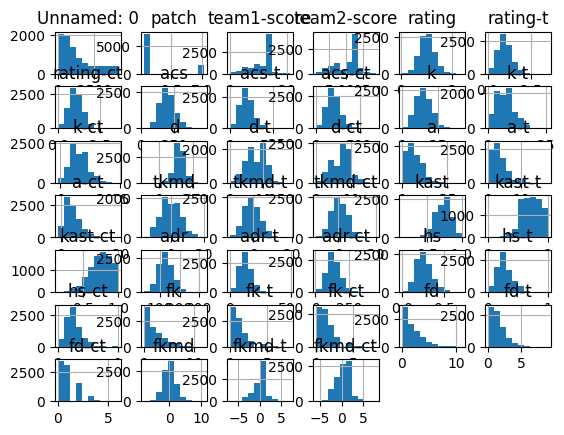

In [34]:
df.hist()

Now, the original data does not have any column for wins as it is just the raw data from vlr.gg. On the website, it uses color to show who has won the map. To remedy this and give the data something to correlate to, we'll make a two new columns named team1_win and team2_win which will give us who has won and who has lost each match(They are also encoded as 1 for wins and 0 for losses due so that we can do correlation on them in the future).

In [35]:
df['team1_win'] = df.apply(lambda row: row['team1-score'] > row['team2-score'], axis=1)
df['team2_win'] = df.apply(lambda row: row['team2-score'] > row['team1-score'], axis=1)

# replace True/False with 'Win'/'Loss'
df['team1_win'] = df['team1_win'].map({True: 'Win', False: 'Loss'})
df['team2_win'] = df['team2_win'].map({True: 'Win', False: 'Loss'})

df['team1_win_encoded'] = df['team1_win'].map({'Win': 1, 'Loss': 0})
df['team2_win_encoded'] = df['team2_win'].map({'Win': 1, 'Loss': 0})


Now that we have that, we can look at some more correlation and see what we get. Let's test something by just looking at the correlation between our means and their wins/losses

In [36]:
base = ['k','d','a','acs','rating']
df[base].corr()

k         d         a       acs    rating
k       1.000000  0.176294  0.019170  0.834965  0.706517
d       0.176294  1.000000  0.093673 -0.135686 -0.464875
a       0.019170  0.093673  1.000000 -0.055558  0.158764
acs     0.834965 -0.135686 -0.055558  1.000000  0.799999
rating  0.706517 -0.464875  0.158764  0.799999  1.000000

In [37]:
# Create a new column indicating which team won
df['winning_team'] = np.where(df['team1-score'] > df['team2-score'], 'team1', 'team2')

# Filter to only include rows where the winning team is either team1 or team2
winning_stats = df.loc[(df['winning_team'] == 'team1') | (df['winning_team'] == 'team2')]

# Calculate statistics on the winning team
winning_stats_mean = winning_stats.mean(numeric_only=True)
winning_stats_std = winning_stats.std(numeric_only=True)

stats_df = pd.DataFrame({
    "Mean": winning_stats_mean,
    "Std": winning_stats_std
})

print(stats_df)

                          Mean          Std
Unnamed: 0         1306.951977  1122.614436
patch                 6.252554     0.359693
team1-score          10.909605     3.320518
team2-score          10.549153     3.539026
rating                1.007849     0.289228
rating-t              0.967978     0.401711
rating-ct             1.046025     0.406160
acs                 198.248405    56.777435
acs-t               194.214123    78.674578
acs-ct              203.450388    78.991132
k                    14.895819     5.341369
k-t                   7.412429     3.804326
k-ct                  7.534915     3.804579
d                    14.776158     3.947554
d-t                   7.669704     2.692506
d-ct                  7.224260     2.614884
a                     6.598747     4.059409
a-t                   3.272096     2.571253
a-ct                  3.326651     2.552271
tkmd                 -0.006264     5.906866
tkmd-t               -0.325279     4.225487
tkmd-ct               0.318829  

We can see that begin to have some categories that are correlated. Let's now move on to looking at what we really want to discover, what is most needed for a win, and is it something that a team can provide or is it player driven. For now, we'll continue with player driven metrics and see some of these stats with wins/losses involved.

In [38]:
baseWL = ['k','d','a','acs','rating','team1_win_encoded','team2_win_encoded']
df[baseWL].corr()

k         d         a       acs    rating  \
k                  1.000000  0.176294  0.019170  0.834965  0.706517   
d                  0.176294  1.000000  0.093673 -0.135686 -0.464875   
a                  0.019170  0.093673  1.000000 -0.055558  0.158764   
acs                0.834965 -0.135686 -0.055558  1.000000  0.799999   
rating             0.706517 -0.464875  0.158764  0.799999  1.000000   
team1_win_encoded -0.028445 -0.021860 -0.003385 -0.007574  0.000388   
team2_win_encoded  0.028445  0.021860  0.003385  0.007574 -0.000388   

                   team1_win_encoded  team2_win_encoded  
k                          -0.028445           0.028445  
d                          -0.021860           0.021860  
a                          -0.003385           0.003385  
acs                        -0.007574           0.007574  
rating                      0.000388          -0.000388  
team1_win_encoded           1.000000          -1.000000  
team2_win_encoded          -1.000000           1.000000

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Drop rows with missing values
df.dropna(inplace=True)

# Define features and target for Team 1 win prediction
target1 = 'team1_win_encoded'
base = ['k', 'd', 'a', 'acs', 'rating']

# Train-test split for Team 1 win prediction
train1, test1 = train_test_split(df, test_size=0.2)

# Train the Random Forest model for Team 1 win prediction
clf1 = RandomForestClassifier(n_estimators=1000)
clf1.fit(train1[base], train1[target1])

# Extract feature importances for Team 1 win prediction
importances1 = pd.DataFrame()
importances1['features'] = base
importances1['importance'] = clf1.feature_importances_
importances1.sort_values(by='importance', ascending=False, inplace=True)

# Define features and target for Team 2 win prediction
target2 = 'team2_win_encoded'
base2 = ['acs', 'rating', 'a', 'd', 'k']

# Train-test split for Team 2 win prediction
train2, test2 = train_test_split(df, test_size=0.2)

# Train the Random Forest model for Team 2 win prediction
clf2 = RandomForestClassifier(n_estimators=1000)
clf2.fit(train2[base2], train2[target2])

# Extract feature importances for Team 2 win prediction
importances2 = pd.DataFrame()
importances2['features'] = base2
importances2['importance'] = clf2.feature_importances_
importances2.sort_values(by='importance', ascending=False, inplace=True)

print('Feature Importances for Team 1 Win Prediction:')
print('-' * 50)
for idx, row in importances1.iterrows():
    print(f"{idx + 1}. {row['features']}: {row['importance']:.4f}")

print()

print('Feature Importances for Team 2 Win Prediction:')
print('-' * 50)
for idx, row in importances2.iterrows():
    print(f"{idx + 1}. {row['features']}: {row['importance']:.4f}")


Feature Importances for Team 1 Win Prediction:
--------------------------------------------------
4. acs: 0.3004
5. rating: 0.2564
3. a: 0.1688
1. k: 0.1417
2. d: 0.1327

Feature Importances for Team 2 Win Prediction:
--------------------------------------------------
1. acs: 0.3029
2. rating: 0.2563
3. a: 0.1668
5. k: 0.1436
4. d: 0.1304


I've imported another part of the sklearn library so we can see the importance of our base statistics when it comes to an individual's impact on winning a game. With the data currently available, ACS is the most important of the base statistics when it comes to determining a win. It seems that KDA is not the most valuable stat when it comes to winning a map. This makes sense since you can win a game of Valorant by not killing a single person and you can technically not die in the game if you didn't want to. Strangely enough, it seems that dying is slightly more valuable to your team than killing an opponent.

Let us start to dig more into some of the more advanced statistics, although I do want to include that ACS is a more advanced statistic but I wanted to add it in our base stats due to it commonality and different databases calculate it differently than others. We'll also be adding some of the less discussed statistics since we have the data.

In [40]:
acs_mean = df['acs'].mean()
adr_mean = df['adr'].mean()
kast_mean = df['kast'].mean()
fk_mean = df['fk'].mean()
fd_mean = df['fd'].mean()

acs_std = df['acs'].std()
adr_std = df['adr'].std()
kast_std = df['kast'].std()
fk_std = df['fk'].std()
fd_std = df['fd'].std()

result_df = pd.DataFrame({
    'acs_mean': [acs_mean],
    'adr_mean': [adr_mean],
    'kast_mean': [kast_mean],
    'fk_mean': [fk_mean],
    'fd_mean': [fd_mean],
    'acs_std': [acs_std],
    'adr_std': [adr_std],
    'kast_std': [kast_std],
    'fk_std': [fk_std],
    'fd_std': [fd_std],
})
print(f"Average ACS: {acs_mean:.2f}\n"
      f"Average ADR: {adr_mean:.2f}\n"
      f"Average KAST: {kast_mean:.2f}\n"
      f"Average FK: {fk_mean:.2f}\n"
      f"Average FD: {fd_mean:.2f}\n"
      f"Standard deviation of ACS: {acs_std:.2f}\n"
      f"Standard deviation of ADR: {adr_std:.2f}\n"
      f"Standard deviation of KAST: {kast_std:.2f}\n"
      f"Standard deviation of FK: {fk_std:.2f}\n"
      f"Standard deviation of FD: {fd_std:.2f}")


Average ACS: 198.54
Average ADR: 130.01
Average KAST: 0.72
Average FK: 2.15
Average FD: 2.14
Standard deviation of ACS: 56.55
Standard deviation of ADR: 36.13
Standard deviation of KAST: 0.12
Standard deviation of FK: 1.82
Standard deviation of FD: 1.68


So now with our new columns we're going to do some more of what we were doing above with our importance models and we'll finalise this with utilising some more of what we used in our most recent lab to do some graphing and clustering too for some added fun.

In [41]:
adv = ['acs','adr','kast','fk','fd']
df[adv].corr()

acs       adr      kast        fk        fd
acs   1.000000  0.962678  0.468279  0.480805 -0.064078
adr   0.962678  1.000000  0.440034  0.438009 -0.058329
kast  0.468279  0.440034  1.000000  0.122052 -0.344490
fk    0.480805  0.438009  0.122052  1.000000  0.261471
fd   -0.064078 -0.058329 -0.344490  0.261471  1.000000

In [42]:
advWL = ['acs','adr','kast','fk','fd', 'team1_win_encoded','team2_win_encoded']
df[advWL].corr()

acs       adr      kast        fk        fd  \
acs                1.000000  0.962678  0.468279  0.480805 -0.064078   
adr                0.962678  1.000000  0.440034  0.438009 -0.058329   
kast               0.468279  0.440034  1.000000  0.122052 -0.344490   
fk                 0.480805  0.438009  0.122052  1.000000  0.261471   
fd                -0.064078 -0.058329 -0.344490  0.261471  1.000000   
team1_win_encoded -0.005303 -0.004528 -0.000050 -0.009984 -0.010779   
team2_win_encoded  0.005303  0.004528  0.000050  0.009984  0.010779   

                   team1_win_encoded  team2_win_encoded  
acs                        -0.005303           0.005303  
adr                        -0.004528           0.004528  
kast                       -0.000050           0.000050  
fk                         -0.009984           0.009984  
fd                         -0.010779           0.010779  
team1_win_encoded           1.000000          -1.000000  
team2_win_encoded          -1.000000           1.000000

In [43]:
final = ['kast','acs']
df[final].corr()

kast       acs
kast  1.000000  0.468279
acs   0.468279  1.000000

In [44]:
# Drop rows with missing values
df.dropna(inplace=True)

# Define features and target
adv = ['acs', 'adr', 'kast', 'fk', 'fd']
target1 = 'team1_win_encoded'
target2 = 'team2_win_encoded'

# Train-test split for Team 1
train1, test1 = train_test_split(df, test_size=0.2)
# Train the Random Forest model for Team 1
clf1 = RandomForestClassifier(n_estimators=1000)
clf1.fit(train1[adv], train1[target1])
# Extract feature importances for Team 1
importances1 = pd.DataFrame()
importances1['features'] = adv
importances1['importance'] = clf1.feature_importances_
importances1.sort_values(by='importance', ascending=False, inplace=True)

# Train-test split for Team 2
train2, test2 = train_test_split(df, test_size=0.2)
# Train the Random Forest model for Team 2
clf2 = RandomForestClassifier(n_estimators=1000)
clf2.fit(train2[adv], train2[target2])
# Extract feature importances for Team 2
importances2 = pd.DataFrame()
importances2['features'] = adv
importances2['importance'] = clf2.feature_importances_
importances2.sort_values(by='importance', ascending=False, inplace=True)

# Print feature importances for Team 1
print('Feature Importances for Team 1 Win Prediction:')
print('-' * 50)
for idx, row in importances1.iterrows():
    print(f"{idx + 1}. {row['features']}: {row['importance']:.4f}")

print()

# Print feature importances for Team 2
print('Feature Importances for Team 2 Win Prediction:')
print('-' * 50)
for idx, row in importances2.iterrows():
    print(f"{idx + 1}. {row['features']}: {row['importance']:.4f}")


Feature Importances for Team 1 Win Prediction:
--------------------------------------------------
1. acs: 0.3047
2. adr: 0.2840
3. kast: 0.1972
4. fk: 0.1074
5. fd: 0.1068

Feature Importances for Team 2 Win Prediction:
--------------------------------------------------
1. acs: 0.3037
2. adr: 0.2838
3. kast: 0.2016
5. fd: 0.1070
4. fk: 0.1038


Finally, we're going to look at some of the graphs for it all and we can conclude with some summations and conclusions.

In [45]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)

# Finding all of the numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
kmeans.fit(df[numeric_cols])

drops = df[numeric_cols].isna().any(axis=1)
drops = df[drops]

#Drop the rows with the missing data
df2 = df[ ~df.index.isin(drops.index) ].copy()
df2

# Normalize
for column in numeric_cols:
    df2[column] = df2[column] / df2[column].abs().max()
df2[numeric_cols]

#Let's train the data
kmeans.fit(df2[numeric_cols])

#Centroids
kmeans.cluster_centers_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([[ 3.06630032e-01,  8.89978681e-01,  6.30420829e-01,
         4.20675742e-01,  3.38290339e-01,  2.18540898e-01,
         2.37131006e-01,  3.40791984e-01,  2.24374974e-01,
         2.42756809e-01,  2.75283829e-01,  2.17775906e-01,
         2.45822803e-01,  4.82078579e-01,  4.54998596e-01,
         4.54036374e-01,  1.94697608e-01,  1.78273893e-01,
         1.69267947e-01, -2.17333614e-01, -1.33042167e-01,
        -9.09435552e-02,  6.57906487e-01,  6.48938500e-01,
         6.66668071e-01,  3.31508003e-01,  2.11097137e-01,
         2.48940299e-01,  3.52658495e-01,  2.57367313e-01,
         2.53235046e-01,  1.24192643e-01,  8.11394271e-02,
         1.05149537e-01,  2.28613005e-01,  1.49443040e-01,
         1.94959281e-01, -9.31301218e-02, -9.94102780e-02,
        -4.10699242e-02,  1.00000000e+00,  9.99200722e-16],
       [ 3.21928908e-01,  8.87772578e-01,  3.99332857e-01,
         6.98631855e-01,  4.25619465e-01,  2.77955108e-01,
         2.97216209e-01,  4.20399450e-01,  2.78307674e-

In [46]:
df2['cluster'] = kmeans.predict(df2[numeric_cols])

<Axes: xlabel='acs', ylabel='kast'>

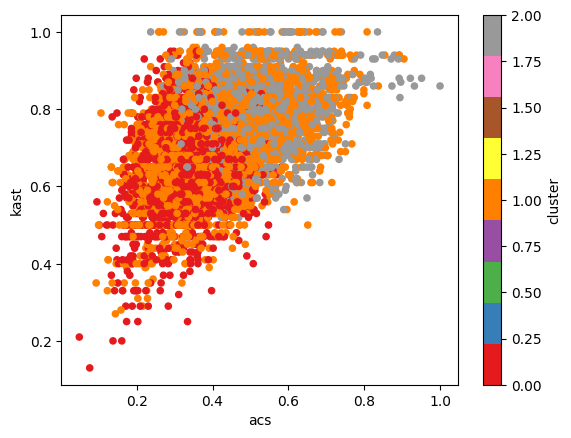

In [47]:
df2.plot.scatter(
    x='acs', 
    y='kast',
    c="cluster",
    colormap='Set1'
)

<Axes: xlabel='fk', ylabel='kast'>

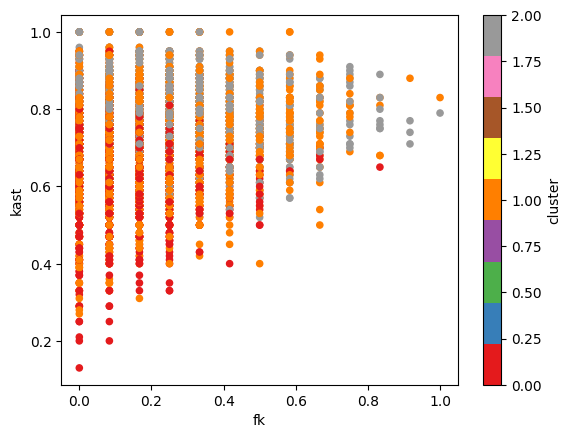

In [48]:
df2.plot.scatter(
    x='fk', 
    y='kast',
    c="cluster",
    colormap='Set1'
)

<Axes: xlabel='fk', ylabel='fd'>

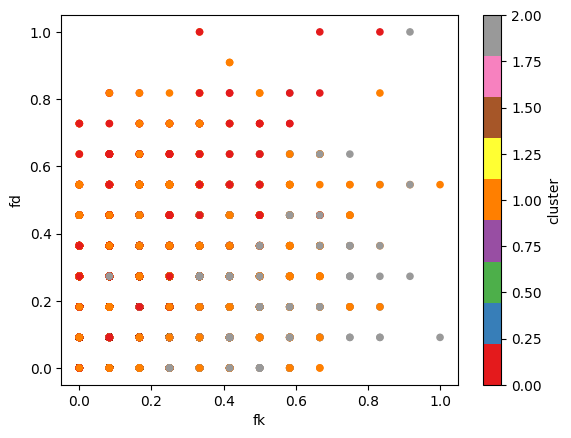

In [49]:
df2.plot.scatter(
    x='fk', 
    y='fd',
    c="cluster",
    colormap='Set1'
)

<Axes: xlabel='fd', ylabel='kast'>

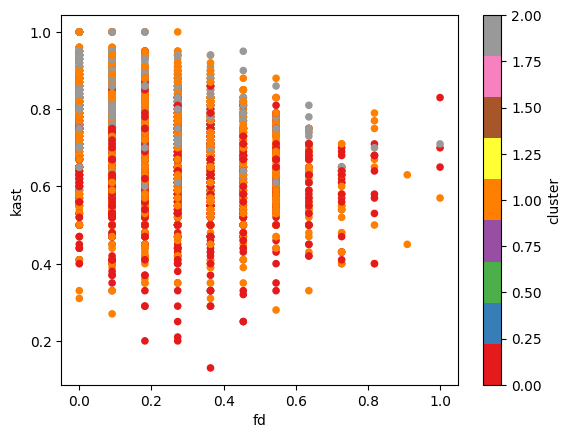

In [50]:
df2.plot.scatter(
    x='fd', 
    y='kast',
    c="cluster",
    colormap='Set1'
)

<Axes: xlabel='fkmd', ylabel='kast'>

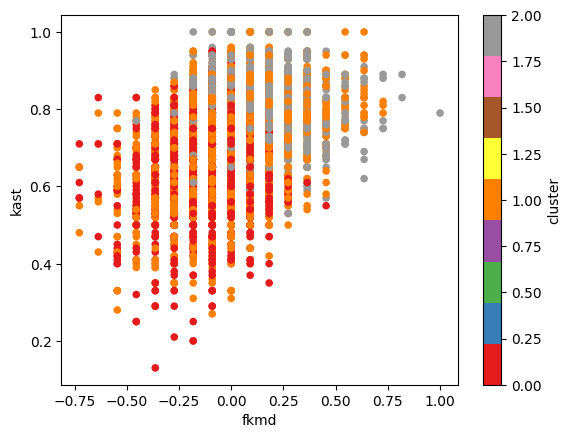

In [51]:
df2.plot.scatter(
    x='fkmd', 
    y='kast',
    c="cluster",
    colormap='Set1'
)

So here we are, we have looked a handful of stats and done quite a bit of python(even though I realise whilst writing this that it is quite a bit repetitive), now is the time give a conclusion and some credits. First off, I would like to give credit to qualidea1217 on kaggle for providing both inspiration and much of the web scraping code(Link:https://www.kaggle.com/datasets/qualidea1217/valorant-pro-matches-since-april-2021). I originally wanted to include some form of team based stats or atleast use some grouping techniques so we could view this analysis in terms of what a whole team produces rather than just an individual since one player can define a map, a series, and in some extreme cases a character(I'm sorry for not giving enough time to look into this). Now for a very concise conclusion which is to be continued in the write-up on canvas: From what we could gather from the importance tests, ACS and ADR play the highest significance when it comes down to how individuals impact the game with KAST coming in with relative importance. I think that there is still alot that can be pulled from this data and I hope to continue to iterate on this project and hopefully expand on what has been done in this short project. Thank you for reading and I hope you have a wonderful break!

In [52]:
team_colors = {
    "LOUD": "#76FB4C",
    "Cloud9" : "#55ABDF",
    "NRG Esports": "#121416",
    "Leviatán" : "#77A8D6",
    "Evil Geniuses" : "#080C77",
    "FURIA" : "#332F37",
    "100 Thieves" : "#CA453F",
    "Sentinels" : "#BD273C",
    "MIBR" : "#27486F",
    "KRÜ Esports" : "#E93A8C",
    "FNATIC" : "#EB642B",
    "Natus Vincere" : "#FCF451",
    "Team Liquid" : "#041435",
    "Giants Gaming" : "#2A64CF",
    "FUT Esports" : "#D43641",
    "BBL Esports" : "#2A173F",
    "Team Vitality" : "#F3DF4A",
    "Team Heretics" : "#8A7846",
    "KOI" : "#633CAC",
    "Karmine Corp" : "#5AC5FA",
    "DRX" : "#0D039D",
    "Paper Rex" : "#000062",
    "T1" : "#D32D37",
    "ZETA DIVISION" : "#4D4D4D",
    "Gen.G" : "#A58D41",
    "Rex Regum Qeon" : "#E7AC4F",
    "Team Secret" : "#2D2F43",
    "Global Esports" : "#1F3F89",
    "Talon Esports" : "#C82B45",
    "DetonatioN FocusMe" : "#3A62CD",
    "EDward Gaming" : "#D3312A",
    "FunPlus Phoenix" : "#E53623"
}
agent_colors = {
    "Brimstone": "#ED7B18",
    "Viper": "#42B883",
    "Omen": "#726FBB",
    "Cypher": "#755F43",
    "Sova": "#2899B2",
    "Sage": "#79C9A6",
    "Phoenix": "#E76F51",
    "Jett": "#84A6C2",
    "Raze": "#F05C8D",
    "Breach": "#E84A27",
    "Reyna": "#D32688",
    "Killjoy": "#F9C74F",
    "Skye": "#91C788",
    "Yoru": "#424B88",
    "Astra": "#AB9DEA",
    "Kayo": "#BBBAB7",
    "Chamber": "#A6999E",
    "Neon": "#008AC1",
    "Fade": "#A83C49",
    "Harbor": "#20616E",
    "Gekko": "#9ACD32",
}
fallback_palette = sns.color_palette("husl", 8)




In [53]:
# Assuming your data is stored in a CSV file
team_info = df[['team1','team2','map','winning_team', 'team1-score', 'team2-score', 'player-name', 'agent', 'acs','player-team']]
# Determine the winning team for each match
team_info['winning_team'] = team_info.apply(lambda row: row['team1'] if row['team1-score'] > row['team2-score'] else row['team2'], axis=1)

# Calculate the number of times each team played each map
map_team1_play_counts = team_info.groupby(["map", "team1"]).size().reset_index(name="play_count").rename(columns={"team1": "team"})
map_team2_play_counts = team_info.groupby(["map", "team2"]).size().reset_index(name="play_count").rename(columns={"team2": "team"})
map_team_play_counts = pd.concat([map_team1_play_counts, map_team2_play_counts])
map_team_play_counts = map_team_play_counts.groupby(["map", "team"])["play_count"].sum().reset_index()

# Calculate the total matches won by each team on each map
map_team_win_counts = team_info.groupby(["map", "winning_team"]).size().reset_index(name="win_count").rename(columns={"winning_team": "team"})

# Merge the win count and play count DataFrames
map_team_win_rate = map_team_win_counts.merge(map_team_play_counts, on=["map", "team"])

# Calculate win rates based on the total number of times the team played the map
map_team_win_rate["win_rate"] = map_team_win_rate["win_count"] / map_team_win_rate["play_count"]

# Create separate bar plots for each map showing the team win rates
unique_maps = team_info["map"].unique()

# Define your teams
teams = team_info['team1'].unique()


/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_49898/2655056950.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_info['winning_team'] = team_info.apply(lambda row: row['team1'] if row['team1-score'] > row['team2-score'] else row['team2'], axis=1)


/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_49898/120802710.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_info["rounds"] = team_info["team1-score"] + team_info["team2-score"]


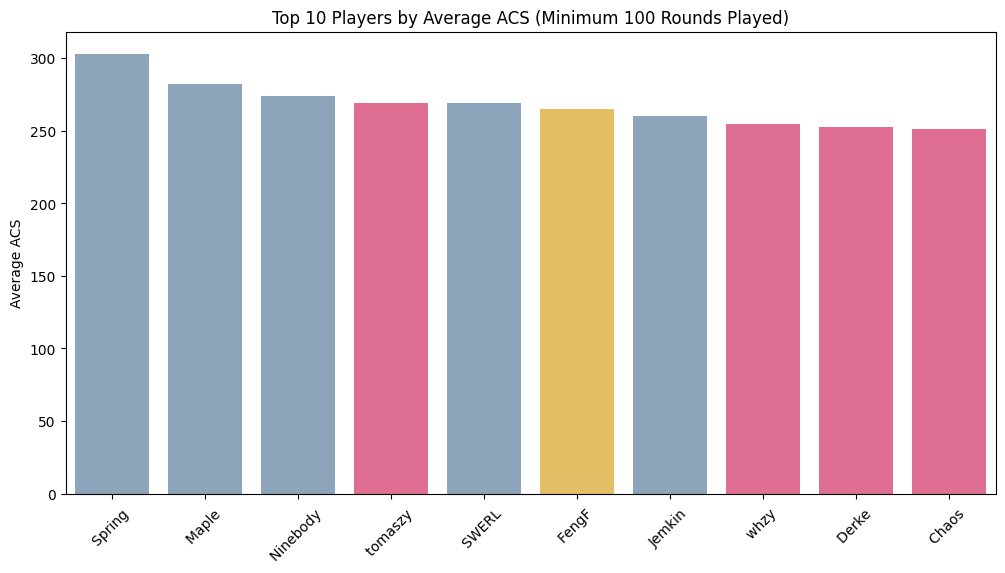

In [54]:
# Set the minimum number of rounds played
min_rounds_played = 100

# Calculate the total rounds played for each player in each map
team_info["rounds"] = team_info["team1-score"] + team_info["team2-score"]

# Group by player-name and filter based on the minimum number of rounds played
filtered_data = team_info.groupby("player-name").filter(lambda x: x["rounds"].sum() >= min_rounds_played)

# Calculate the average ACS for each player in the filtered data
player_acs = filtered_data.groupby("player-name")["acs"].mean().sort_values(ascending=False)

primary_agents = filtered_data.groupby("player-name")["agent"].agg(lambda x: x.value_counts().index[0])

# Display the top 10 players
top_10_players = player_acs.head(10)
top_10_agents = primary_agents.loc[top_10_players.index]
top_10_colors = top_10_agents.map(agent_colors)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_players.index, y=top_10_players.values, palette=top_10_colors)
plt.xlabel("")
plt.ylabel("Average ACS")
plt.title(f"Top 10 Players by Average ACS (Minimum {min_rounds_played} Rounds Played)")
plt.xticks(rotation=45)
plt.show()

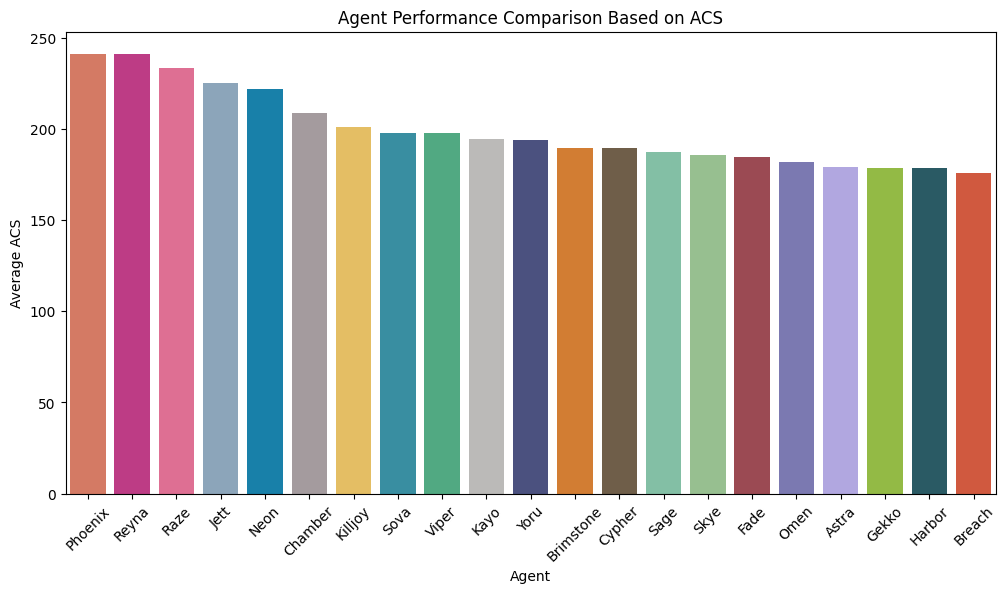

In [55]:
# Calculate average ACS for each agent
agent_acs = team_info.groupby("agent")["acs"].mean().sort_values(ascending=False)
agent_acs_colors = [agent_colors[agent] for agent in agent_acs.index]

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=agent_acs.index, y=agent_acs.values, palette=agent_acs_colors)
plt.xlabel("Agent")
plt.ylabel("Average ACS")
plt.title("Agent Performance Comparison Based on ACS")
plt.xticks(rotation=45)
plt.show()


KeyError: '9z Team'

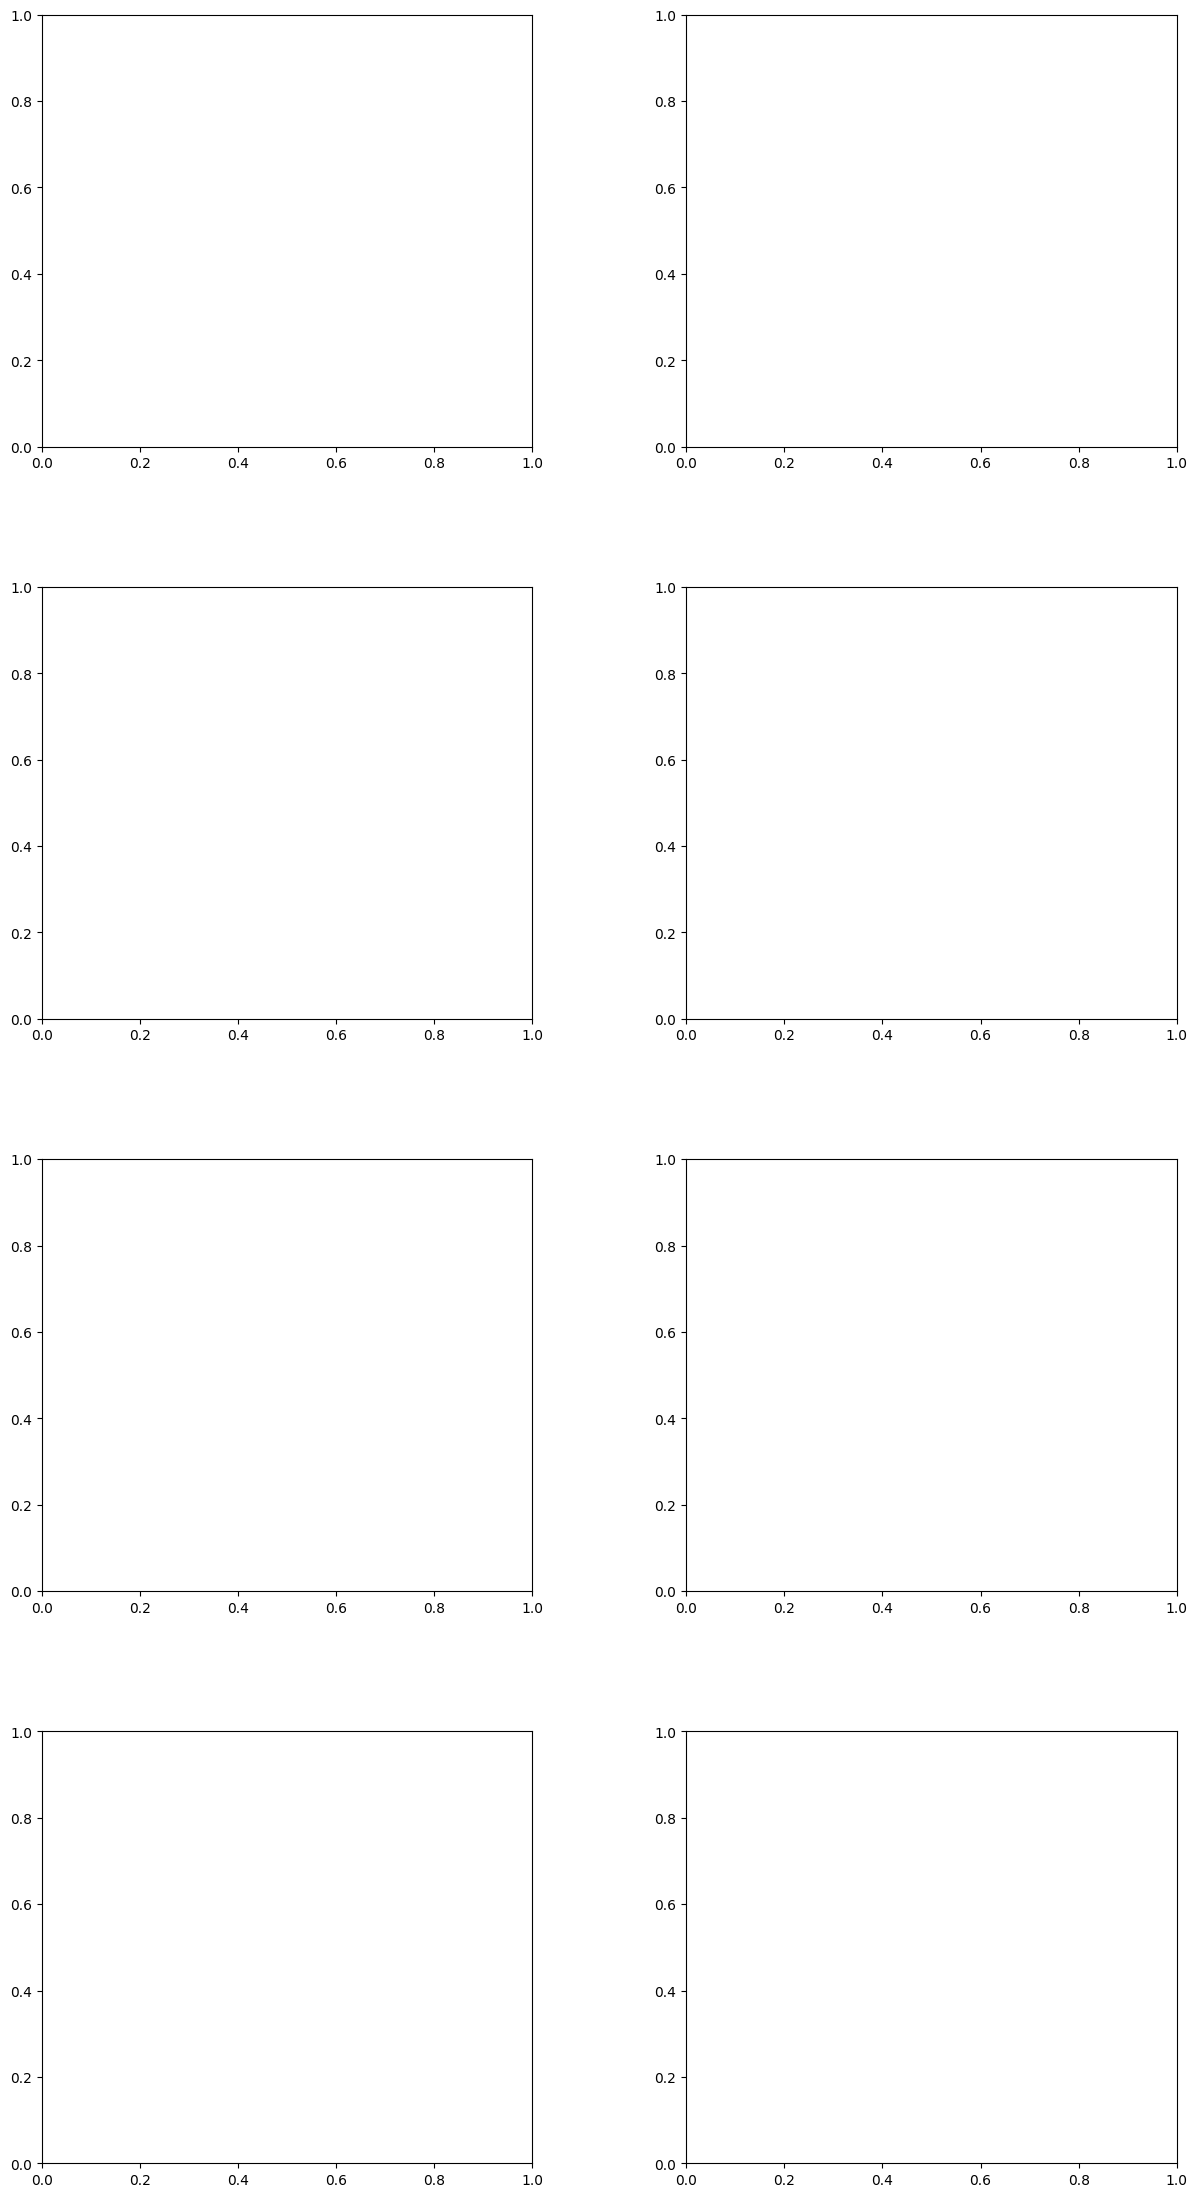

In [56]:
n_cols = 2
n_rows = int(np.ceil(len(unique_maps) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 6))
fig.tight_layout(pad=8)

for i, map_name in enumerate(unique_maps):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]

    map_data = map_team_win_rate[map_team_win_rate["map"] == map_name]

    sns.barplot(x="team", y="win_rate", data=map_data, ax=ax, palette=team_colors)
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.set_xlabel("")
    ax.set_ylabel("Win Rate")
    ax.set_title(f"Win Rates for {map_name}")
    ax.tick_params(axis="x", rotation=90)

for i in range(len(unique_maps), n_cols * n_rows):
    row = i // n_cols
    col = i % n_cols
    axes[row, col].axis("off")

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


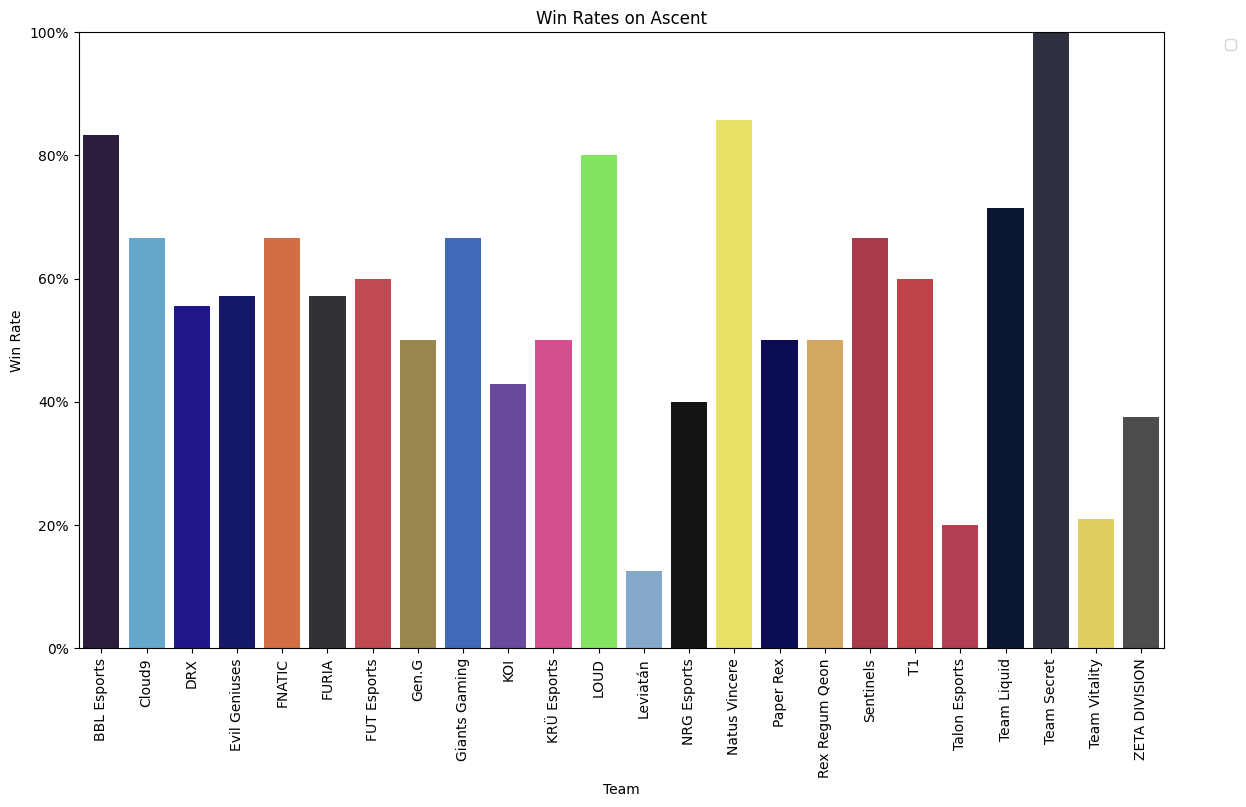

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


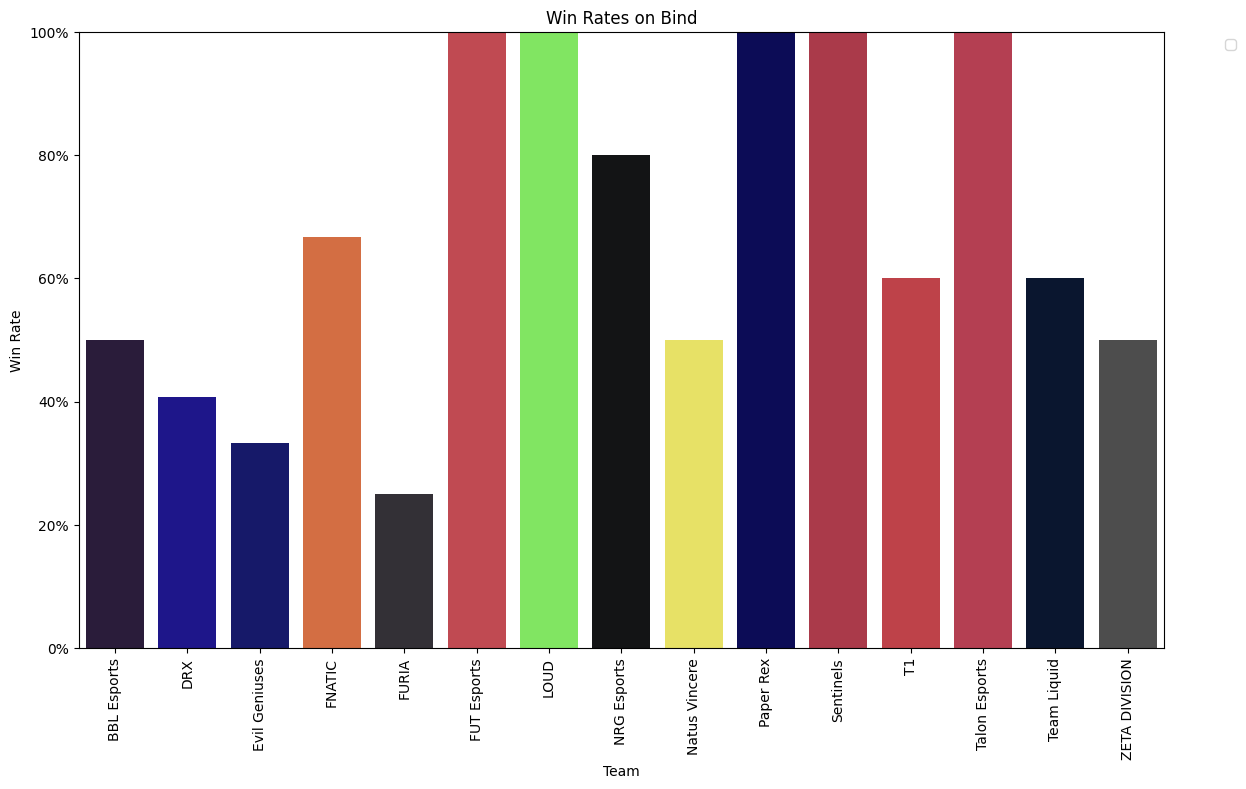

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


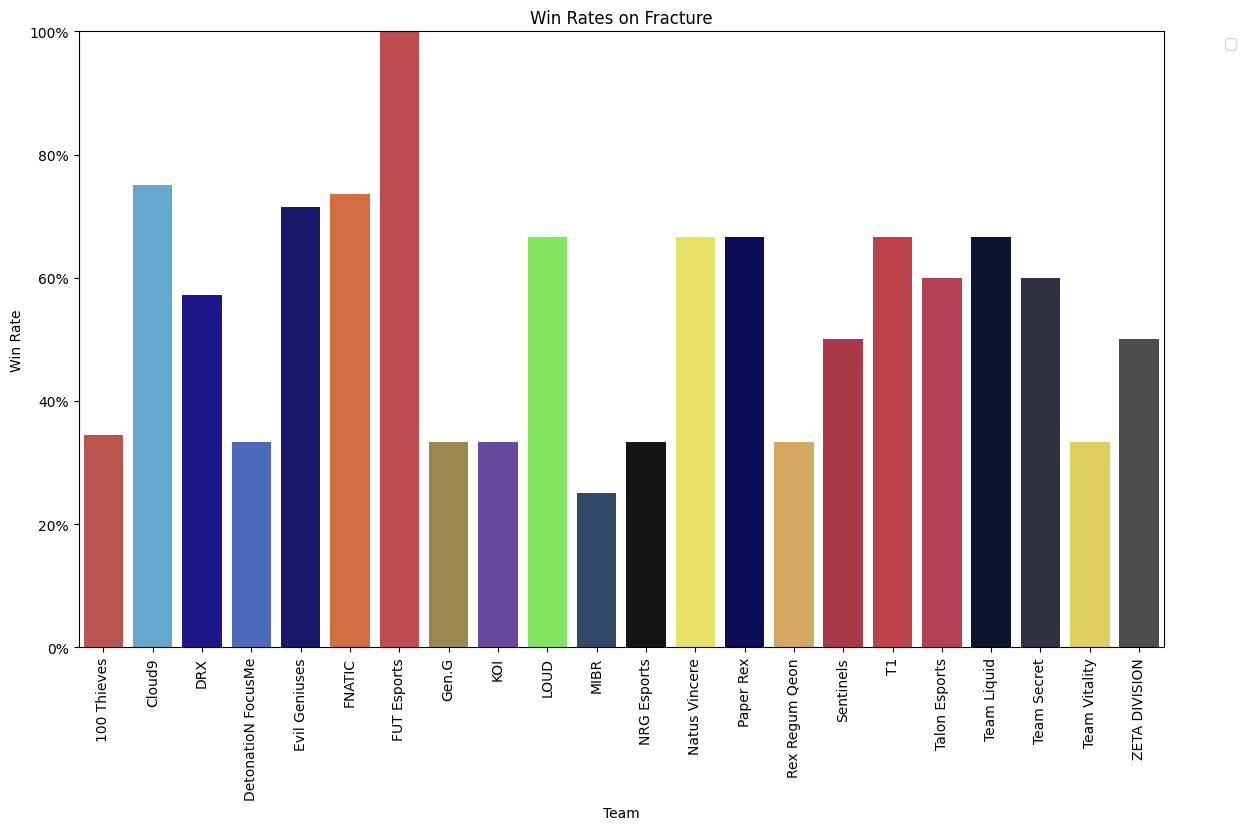

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


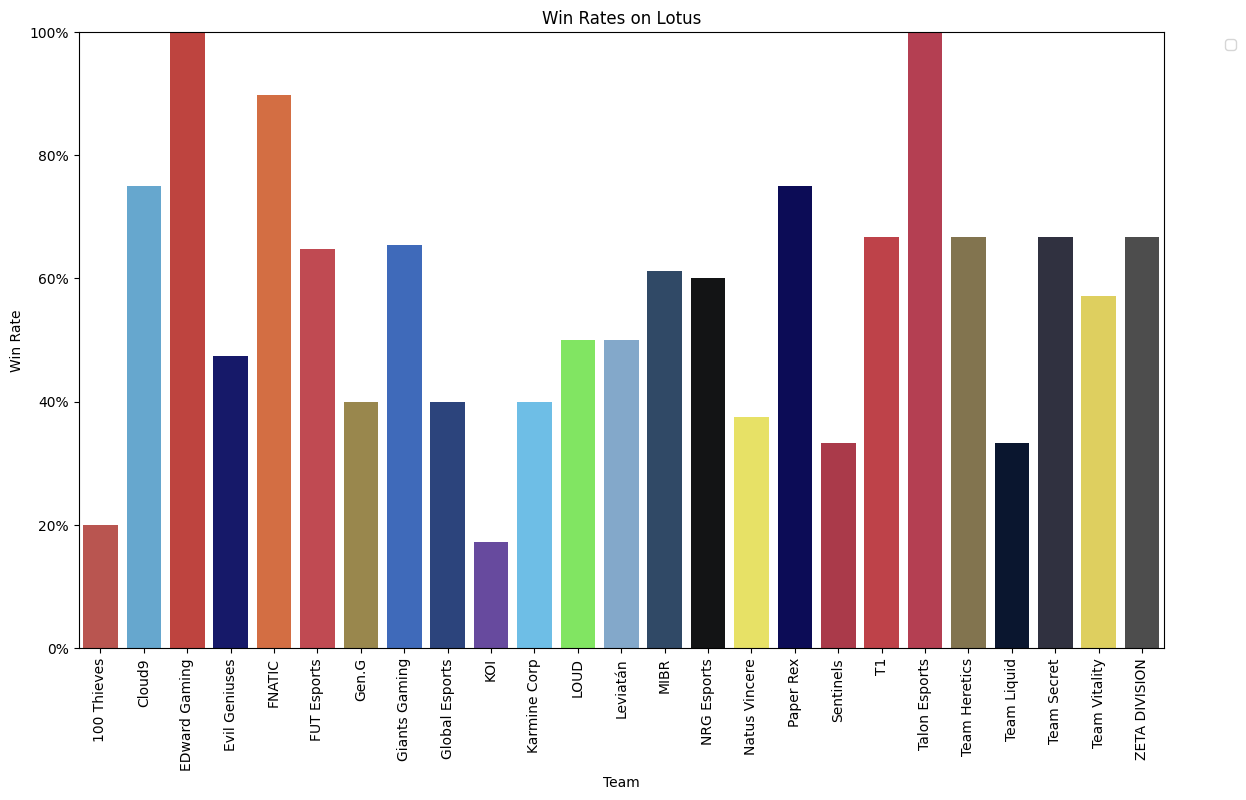

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


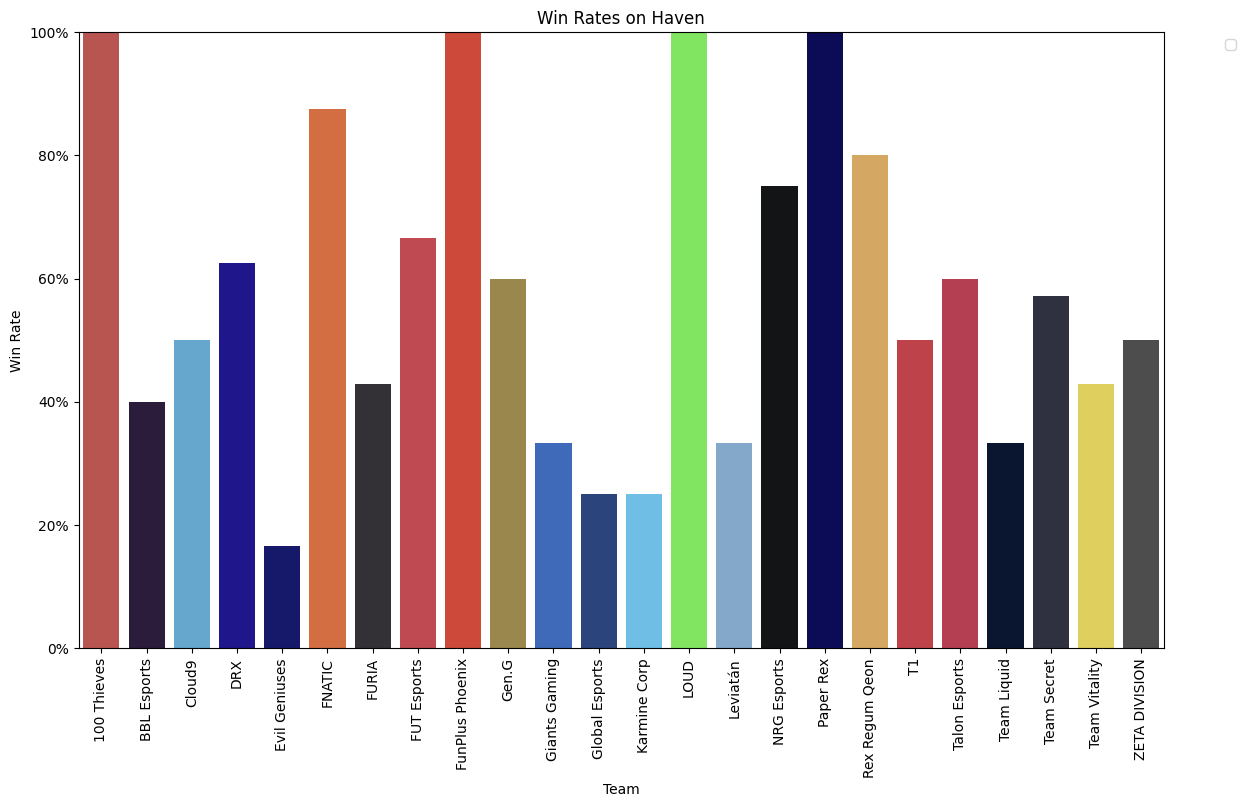

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


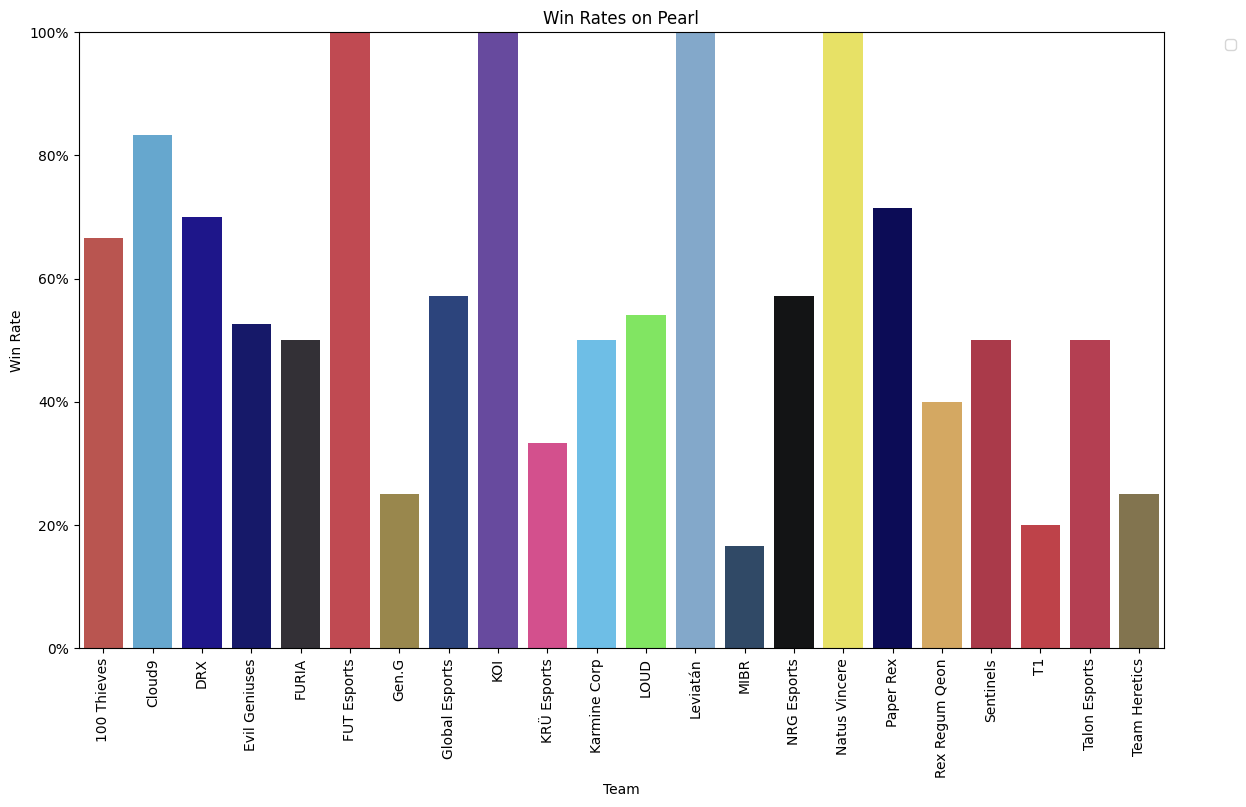

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


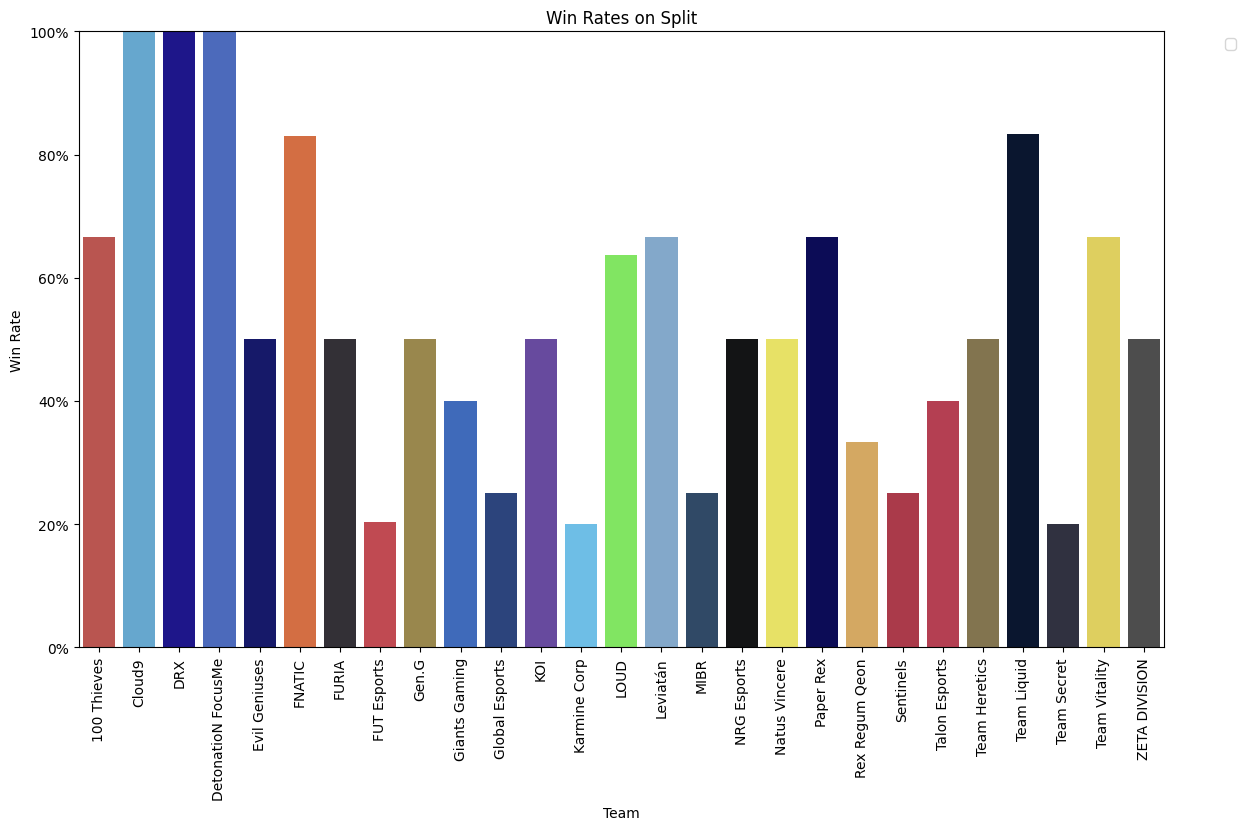

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


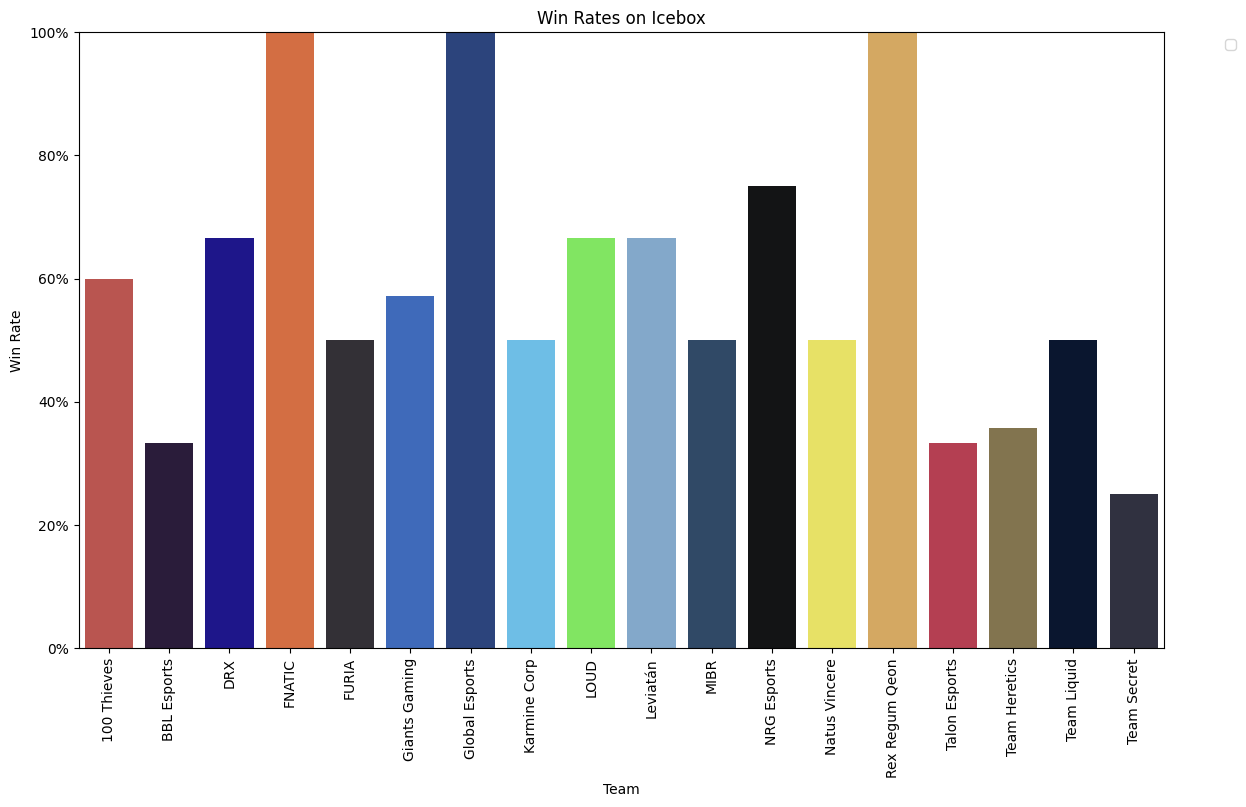

In [ ]:
for map_name in unique_maps:
    plt.figure(figsize=(14, 8))
    map_data = map_team_win_rate[map_team_win_rate['map'] == map_name]
    sns.barplot(x="team", y="win_rate", data=map_data, palette=team_colors)
    plt.xlabel("Team")
    plt.ylabel("Win Rate")
    plt.title(f"Win Rates on {map_name}")
    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylim(0, 1)  # Set y-axis limits to make sure it's between 0 and 1
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.show()


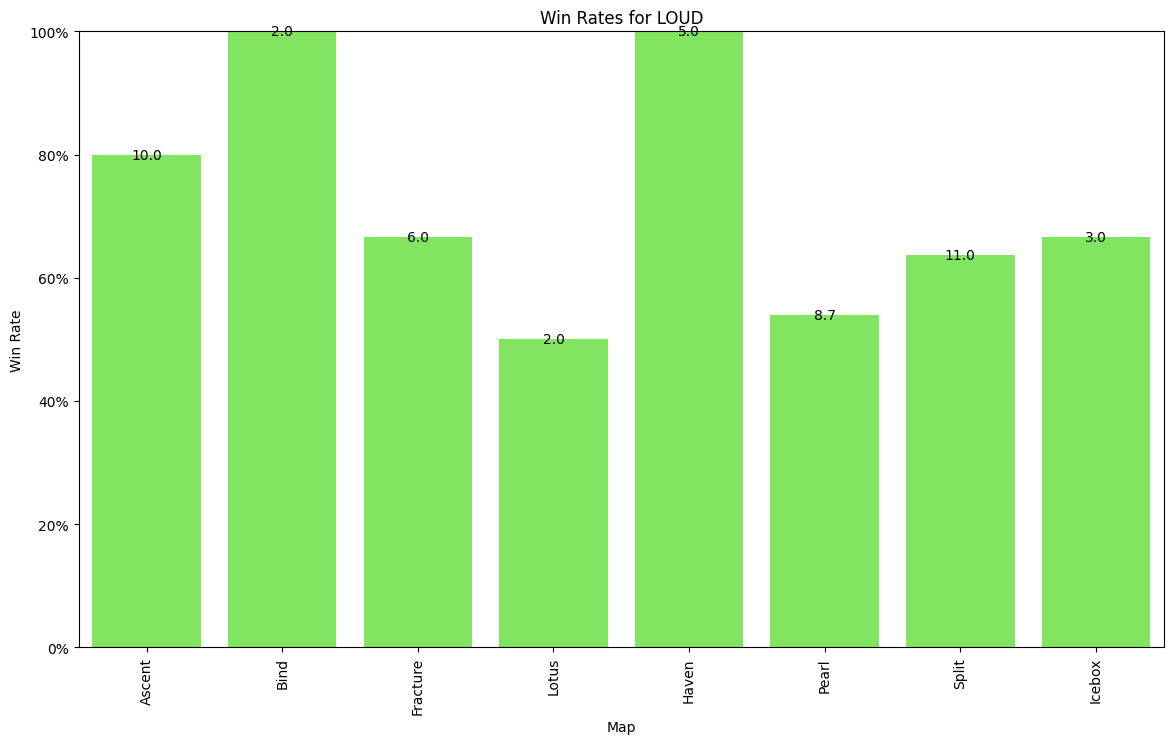

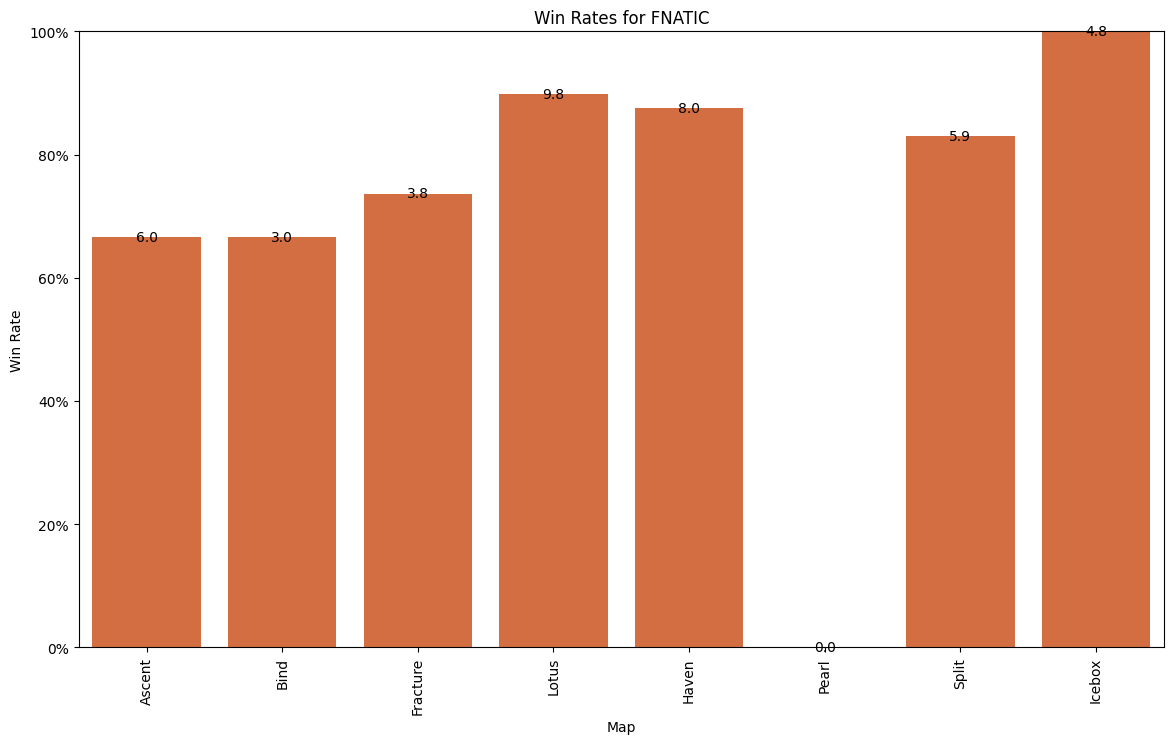

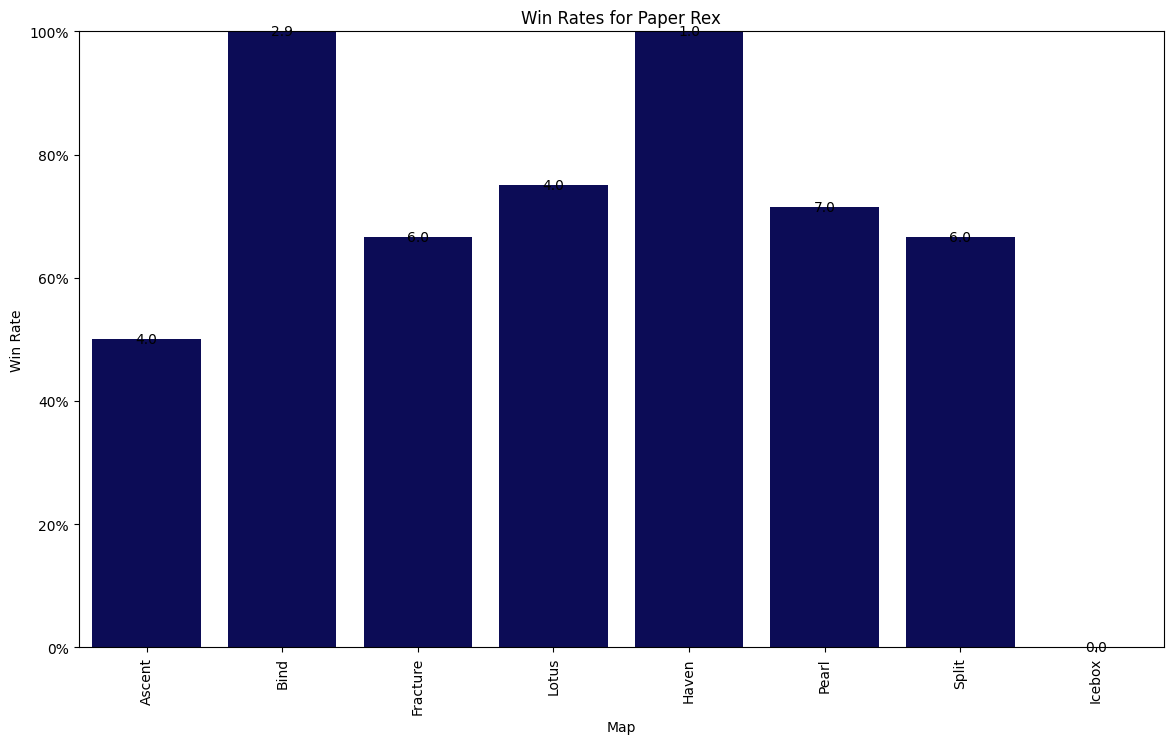

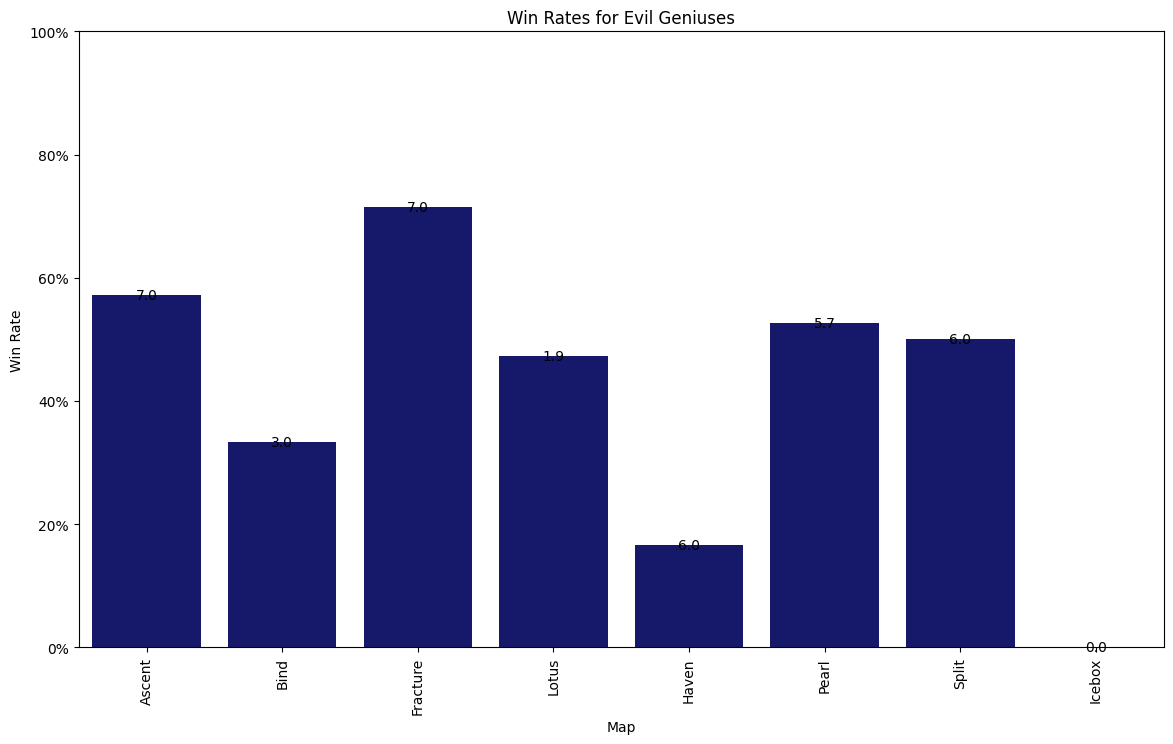

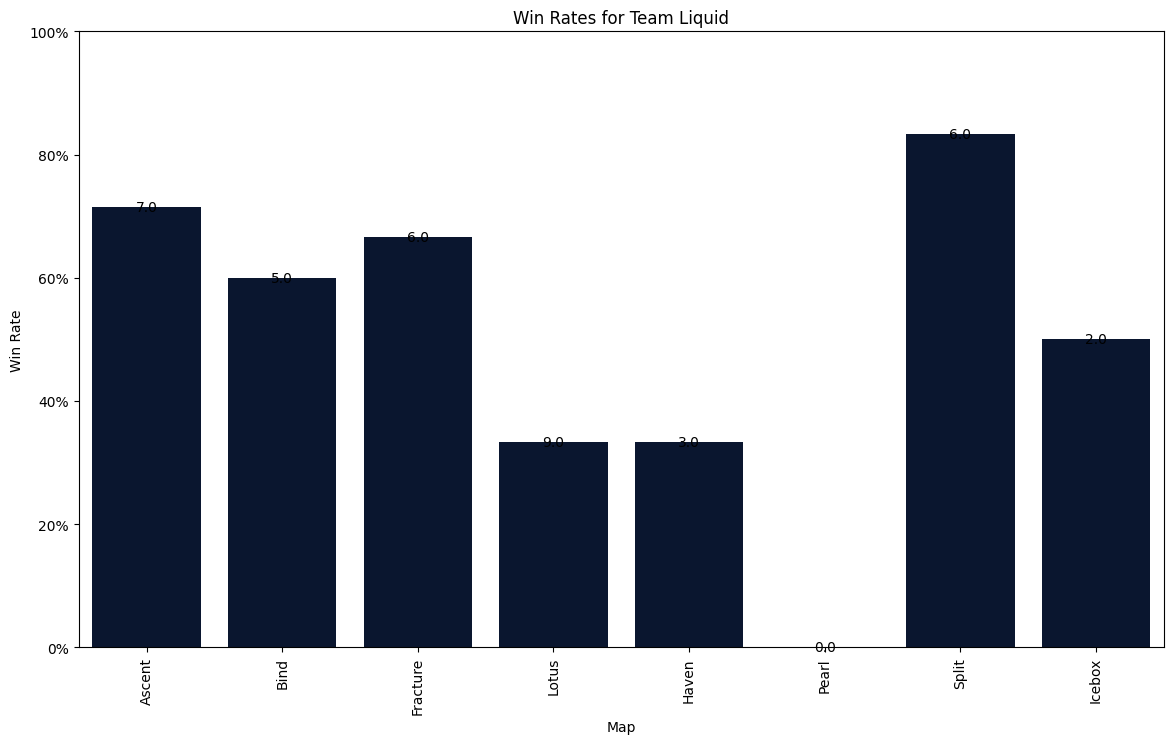

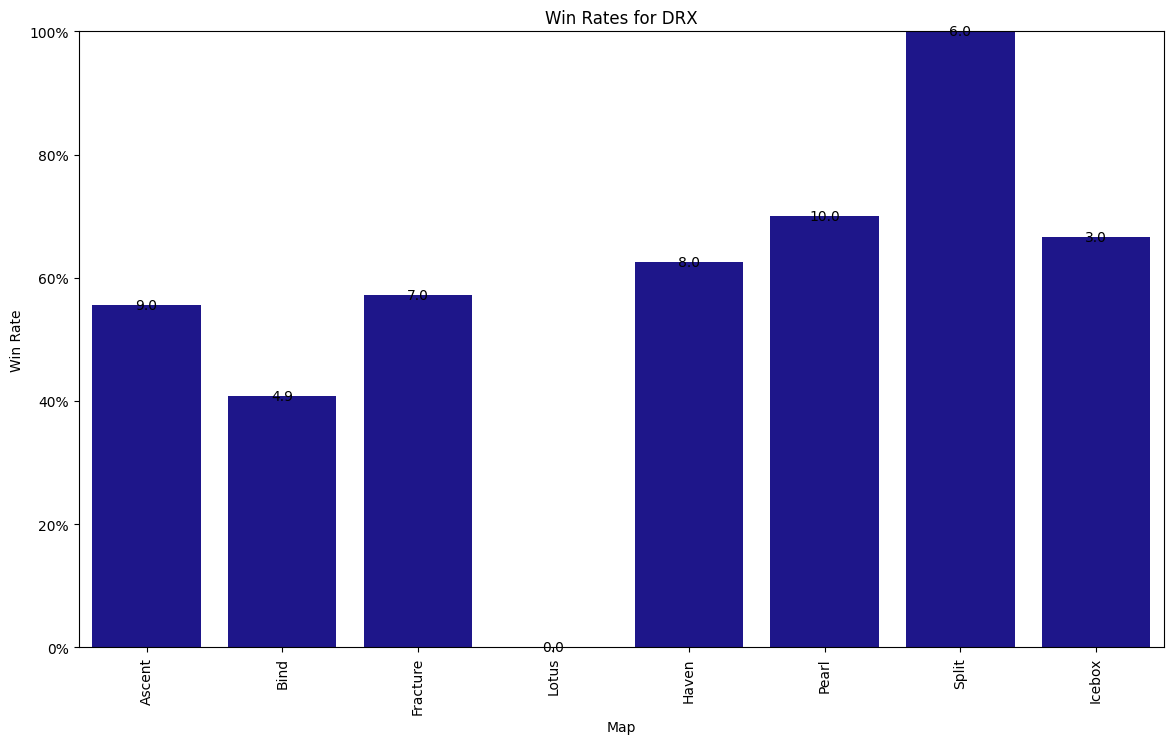

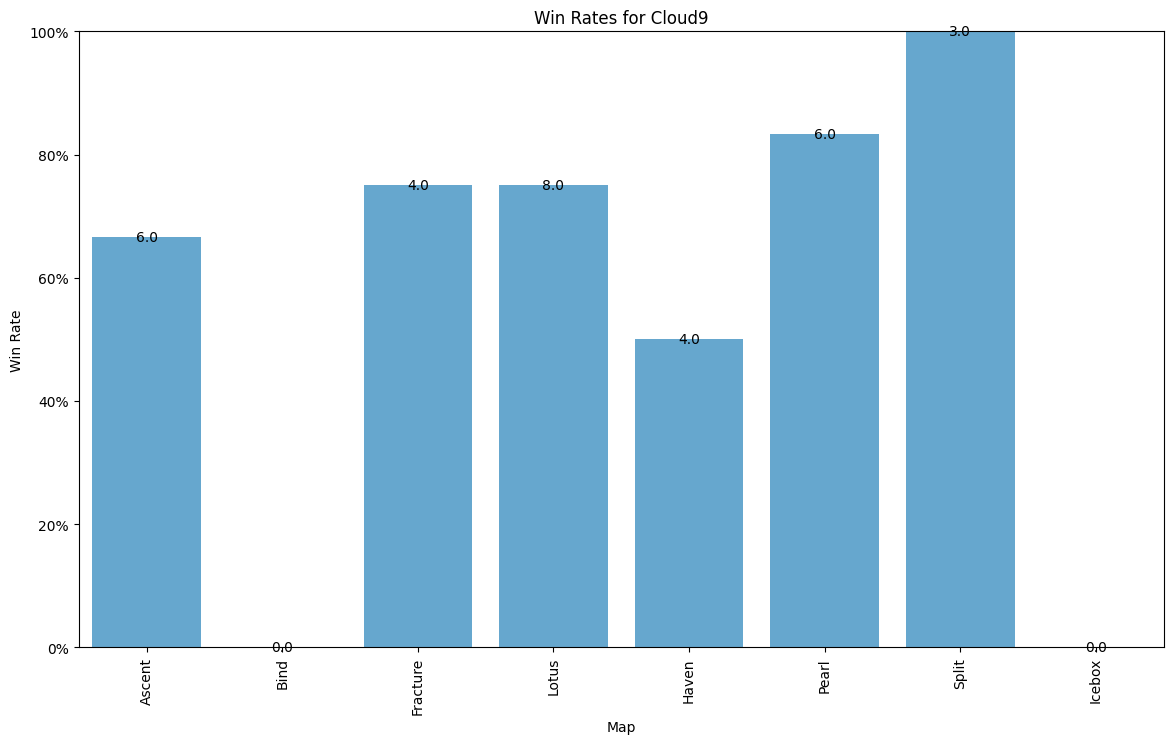

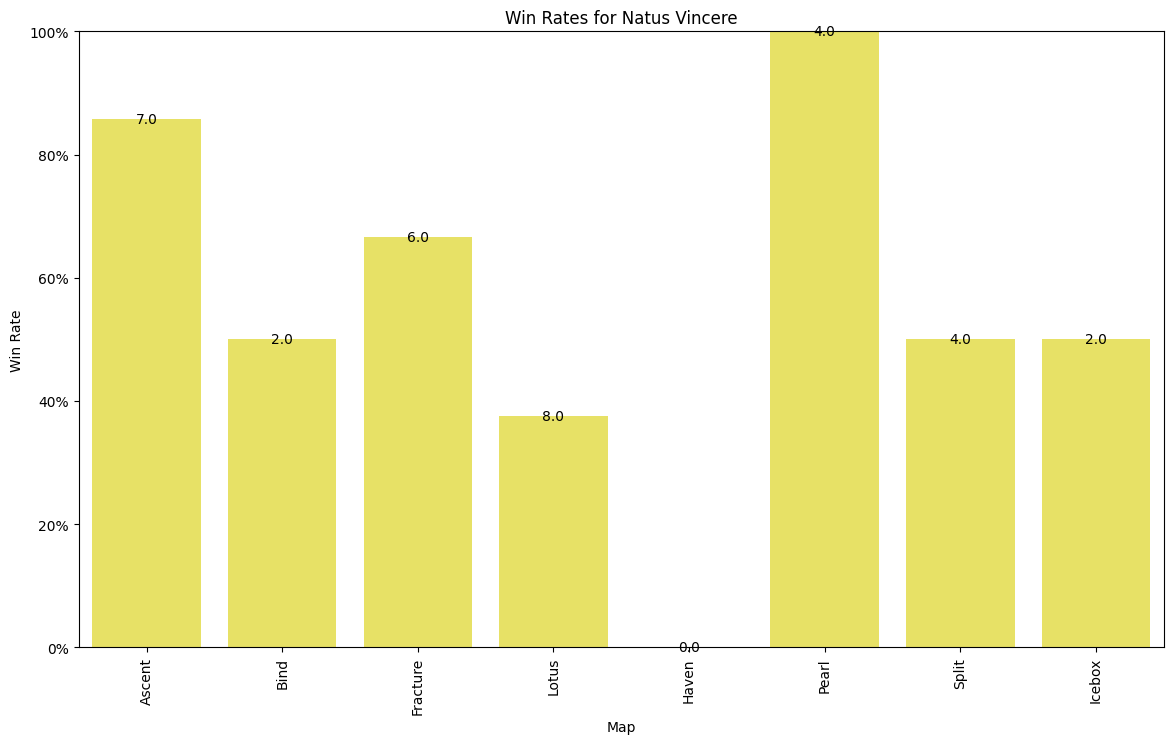

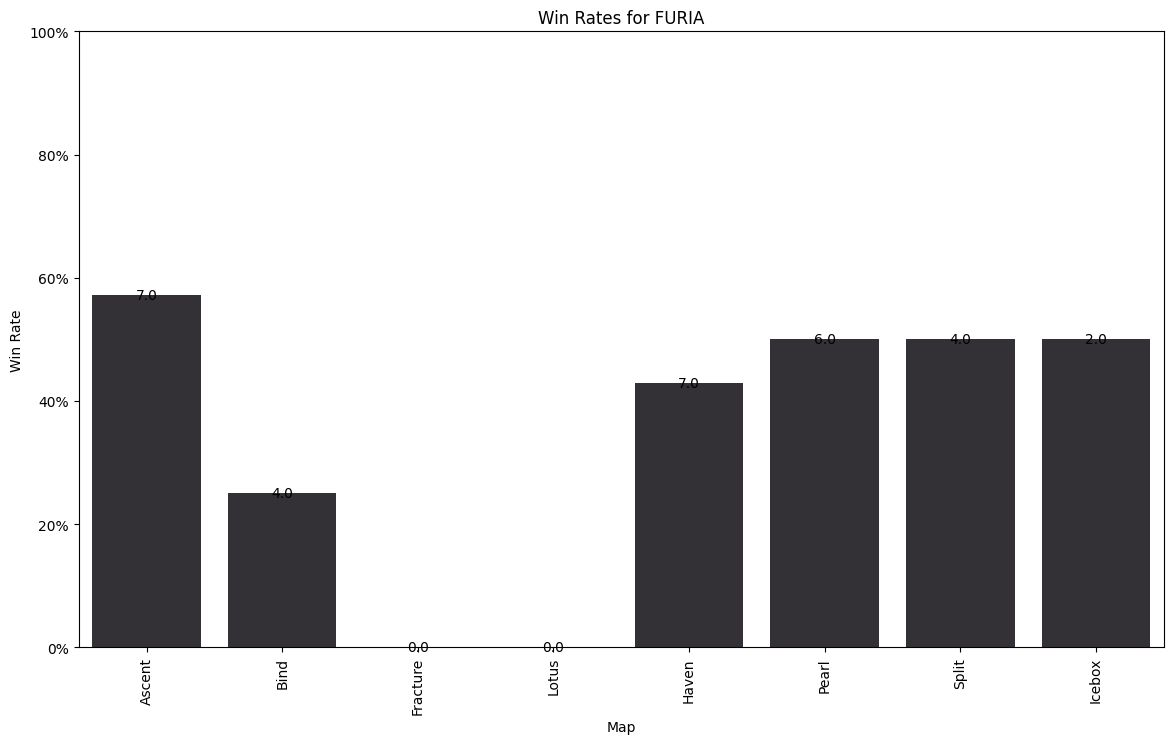

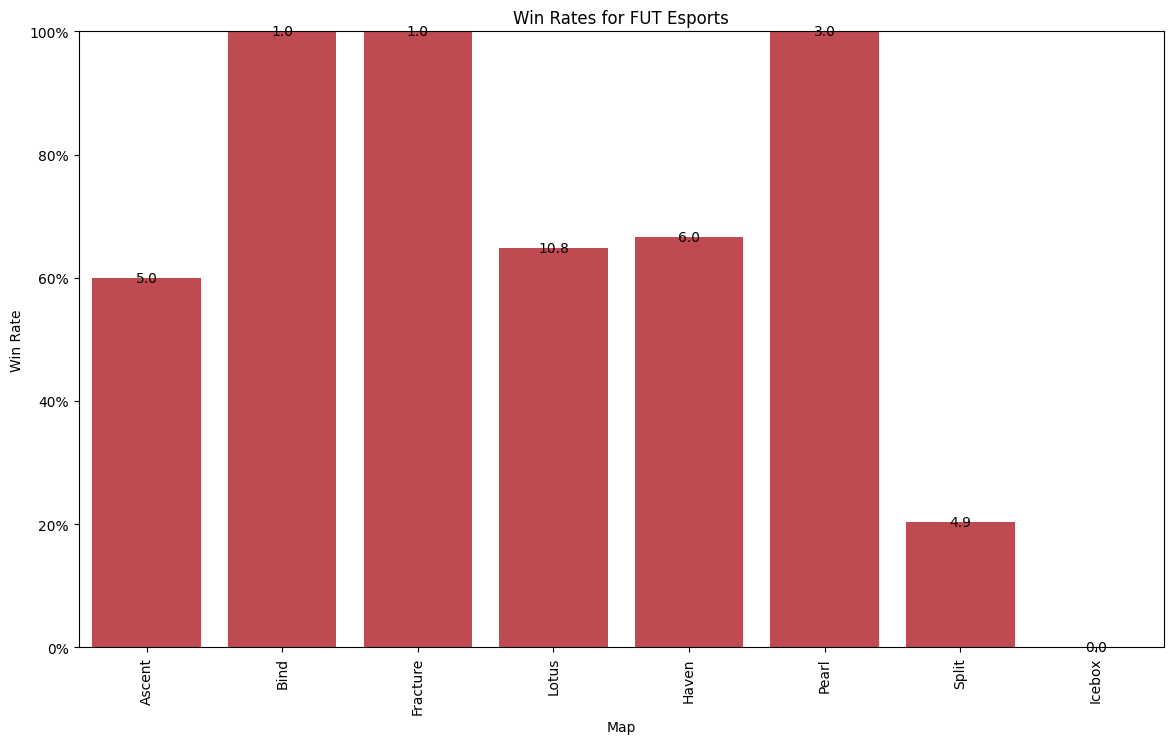

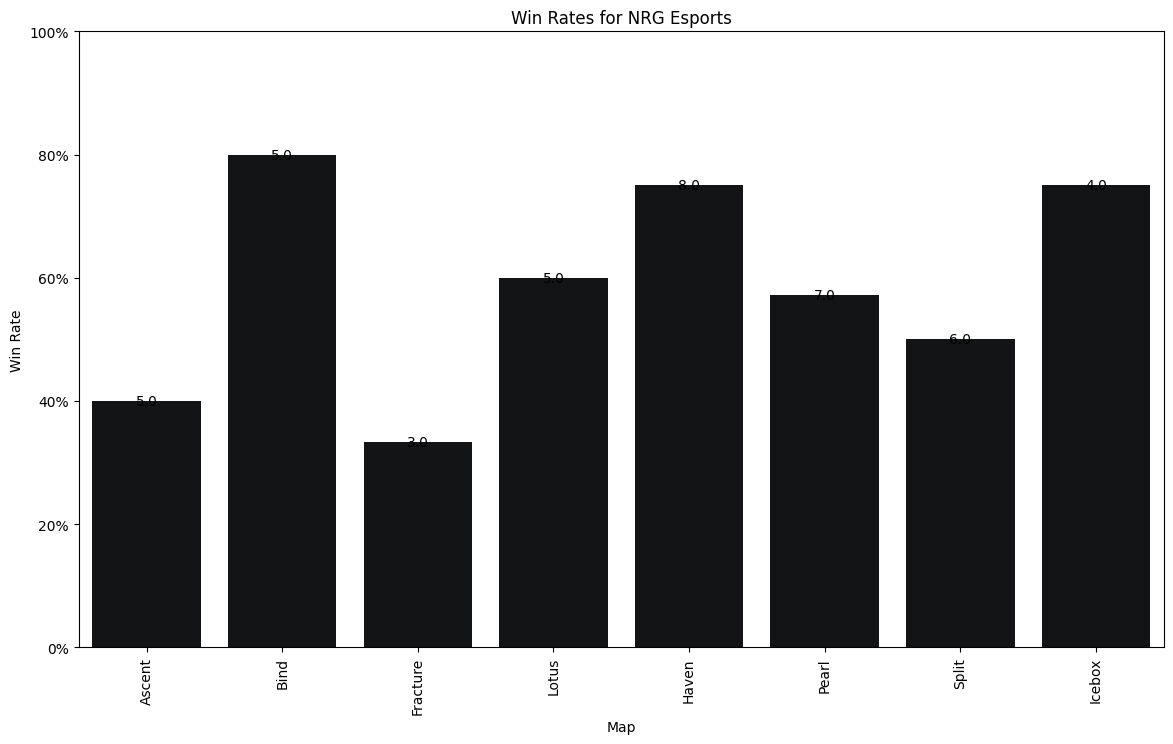

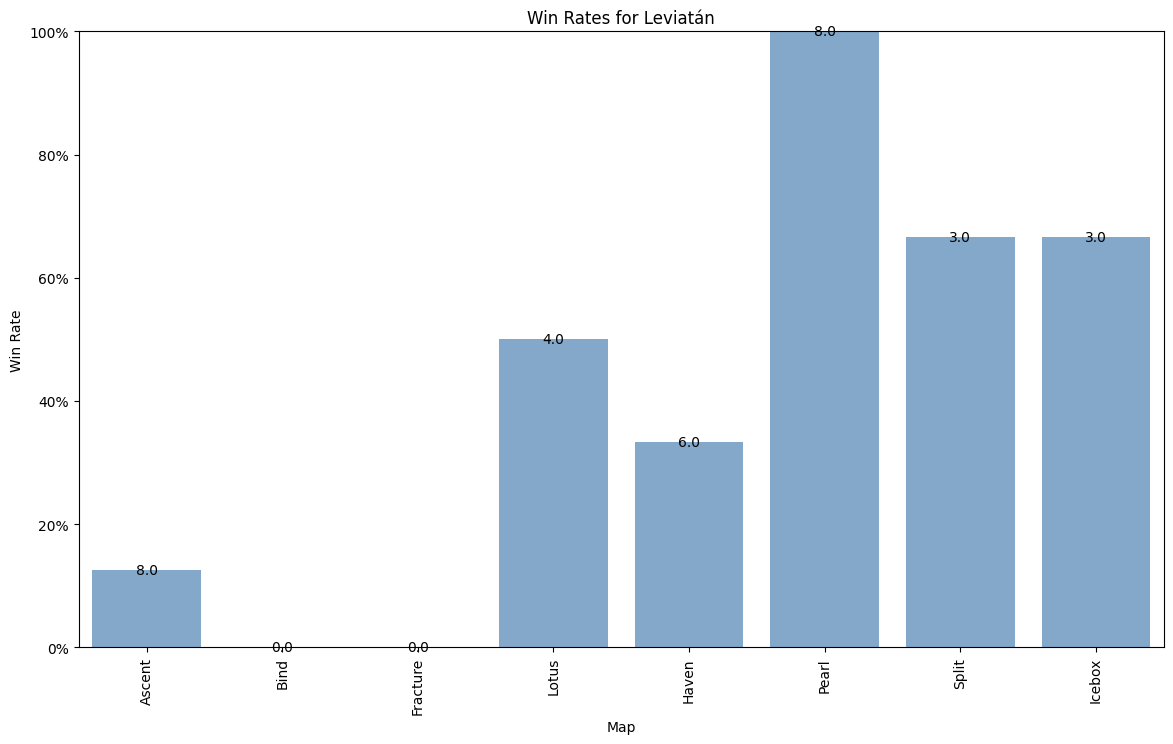

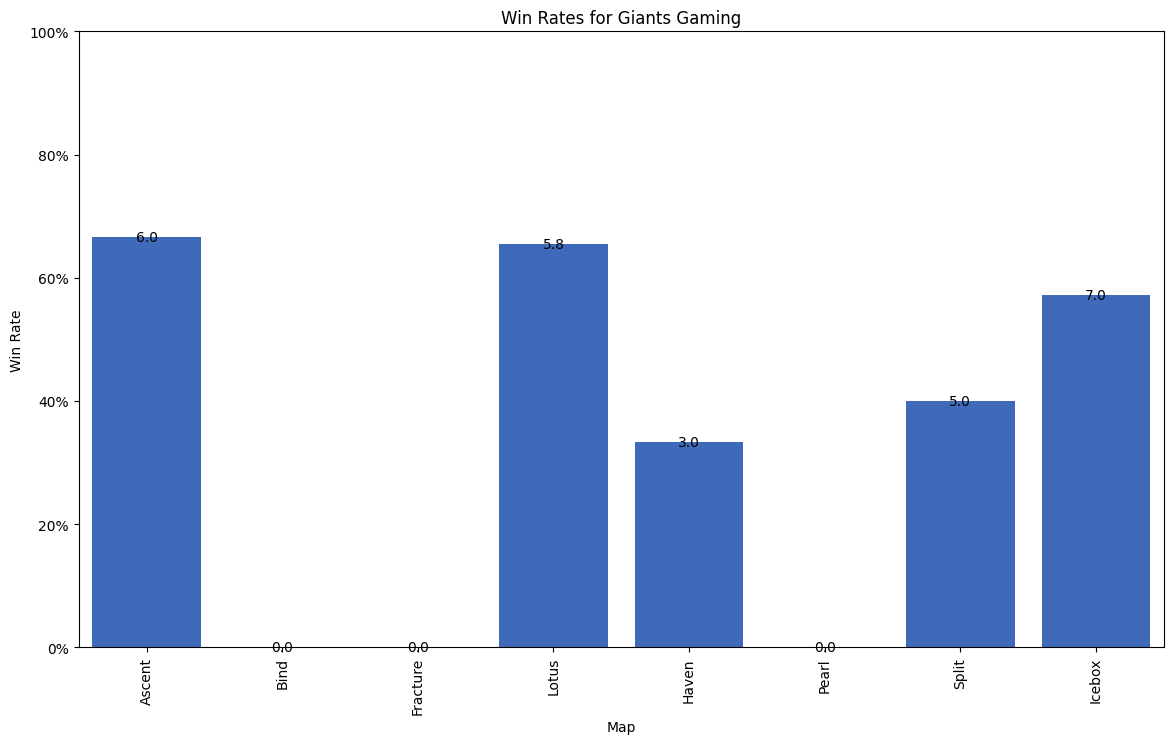

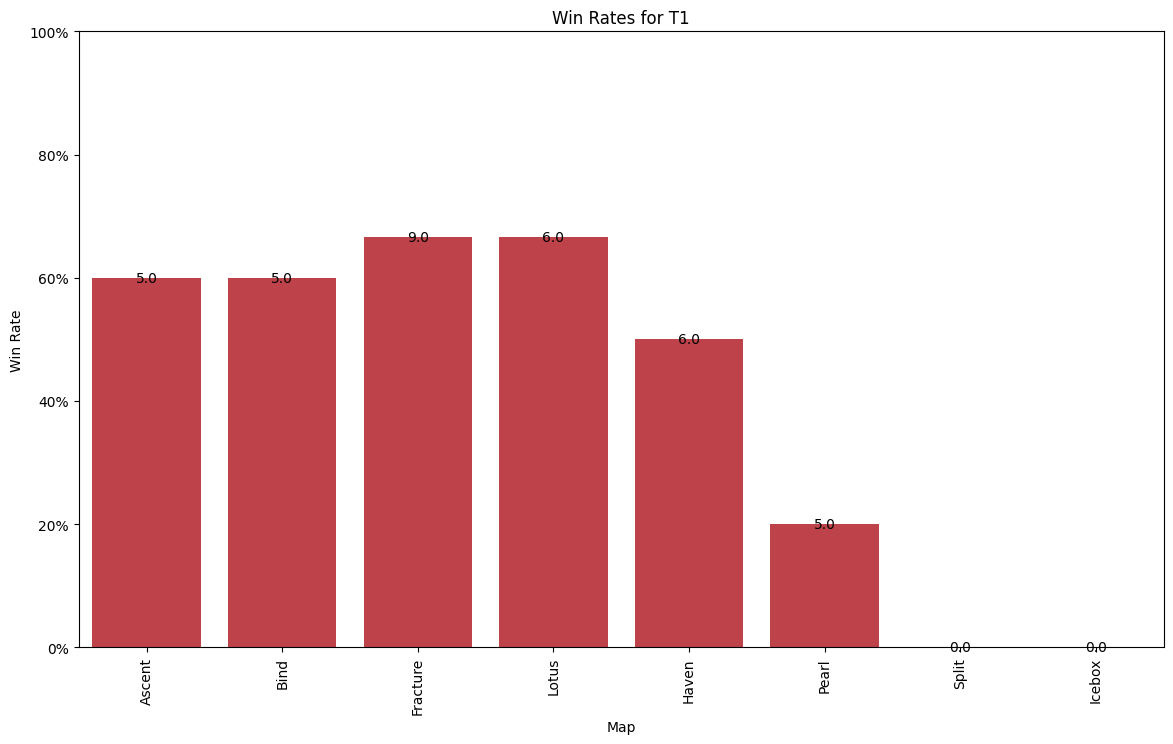

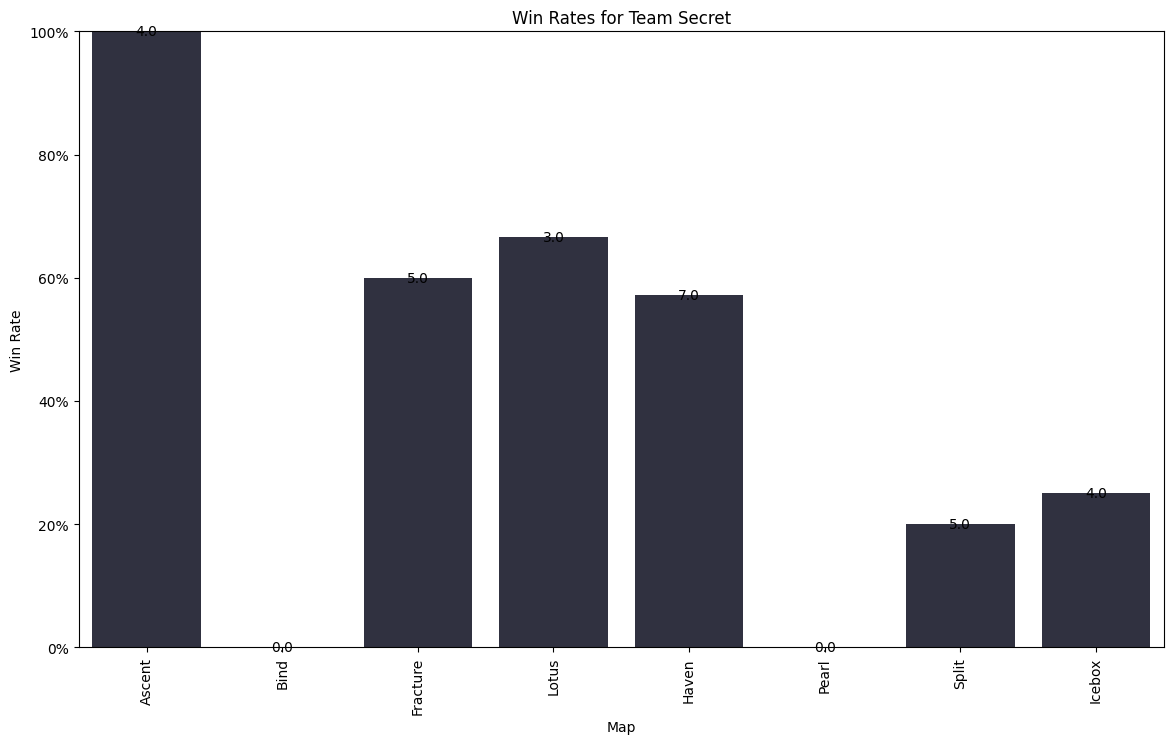

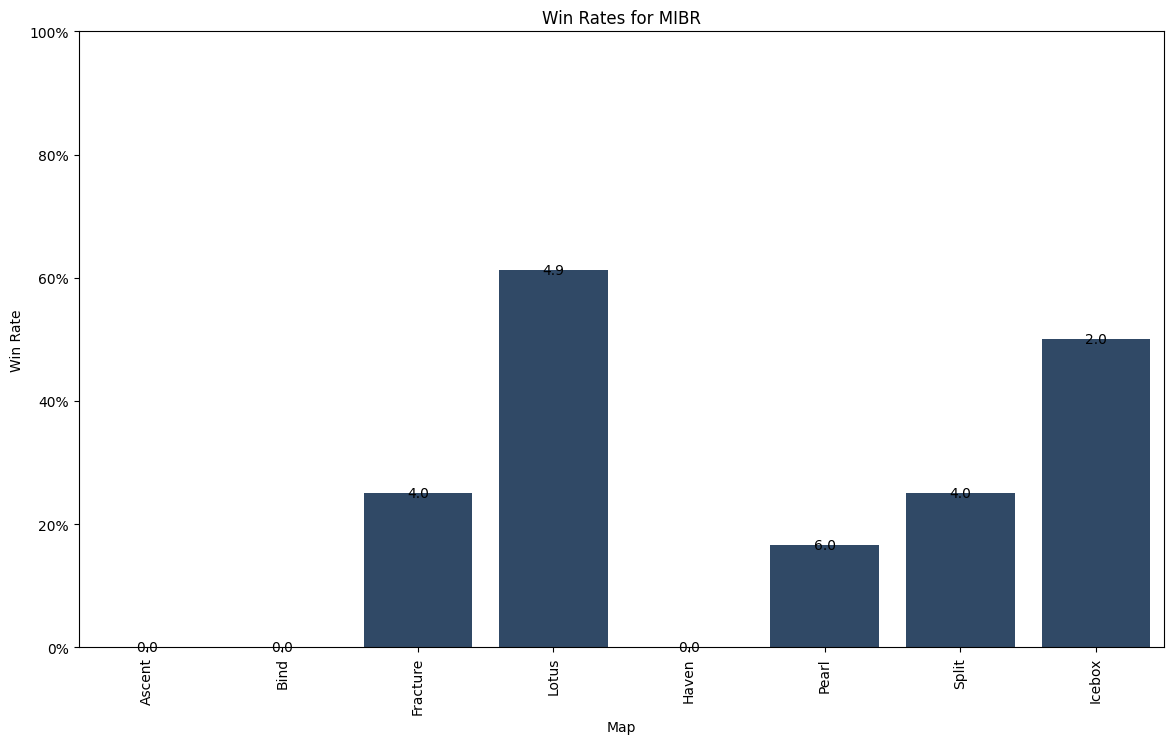

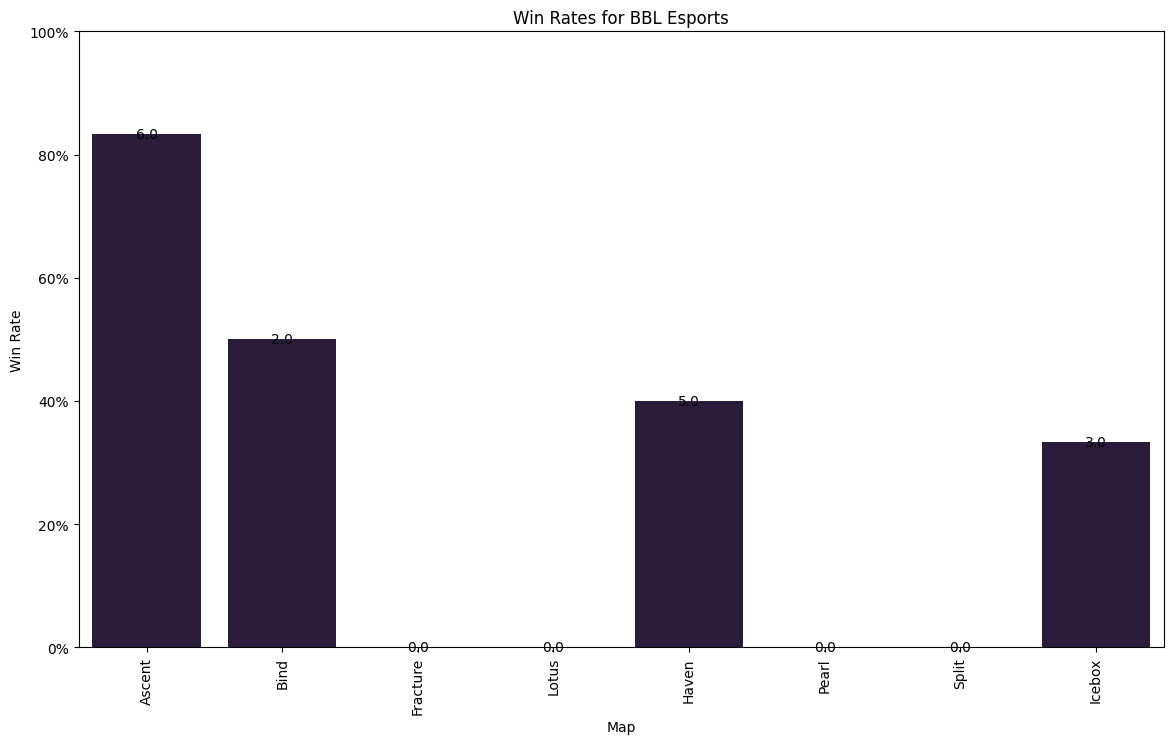

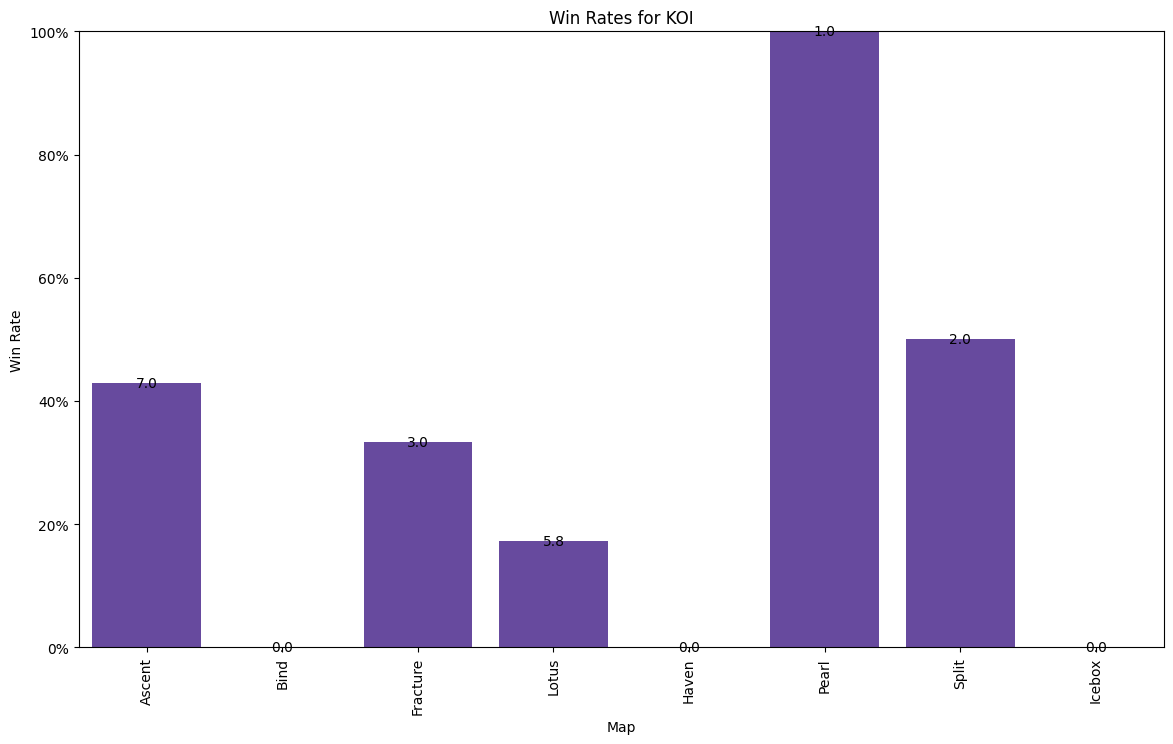

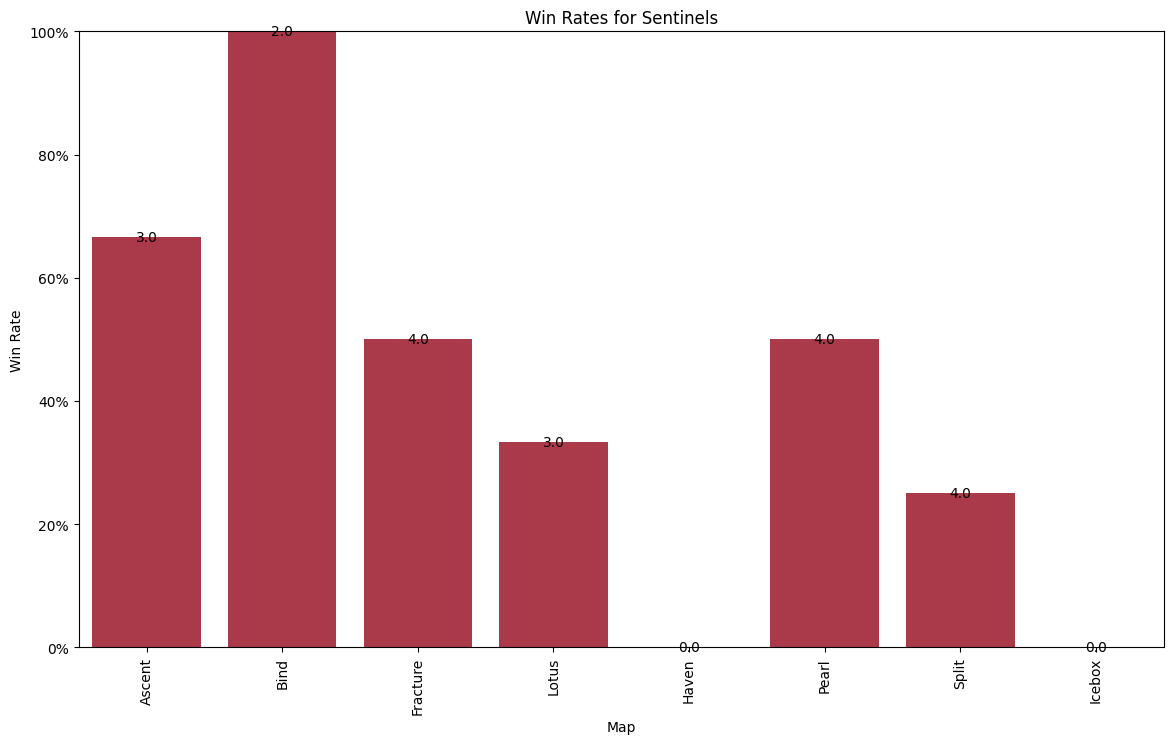

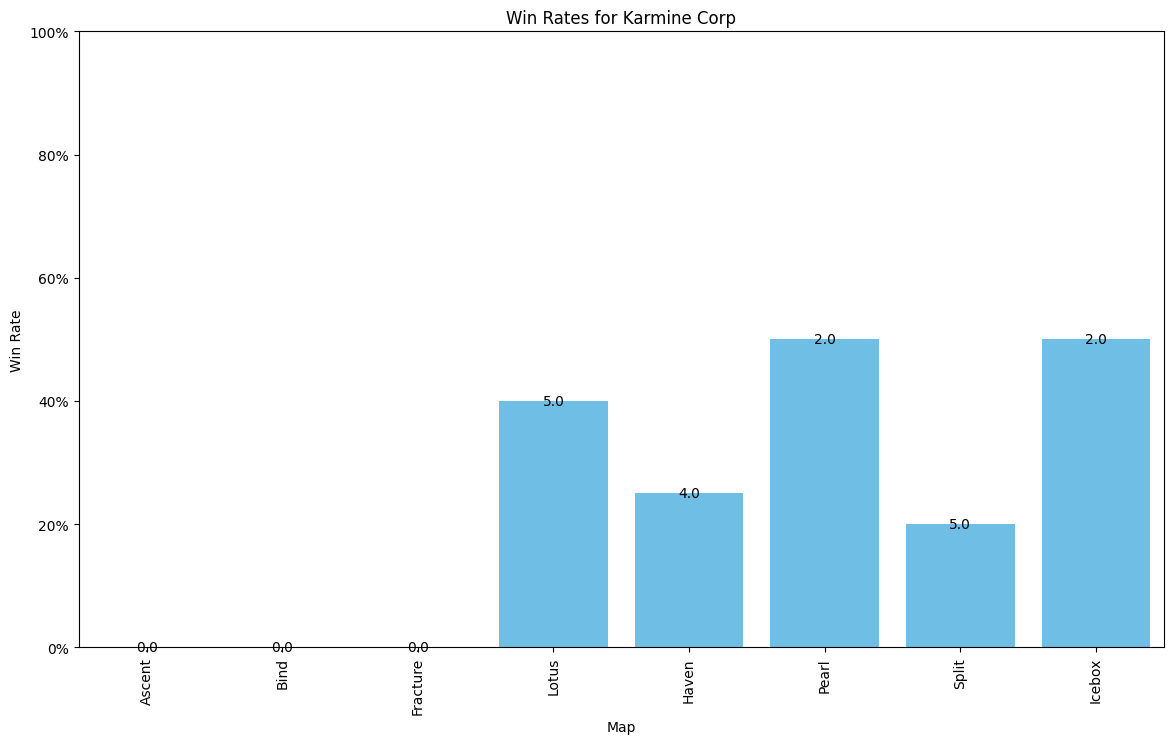

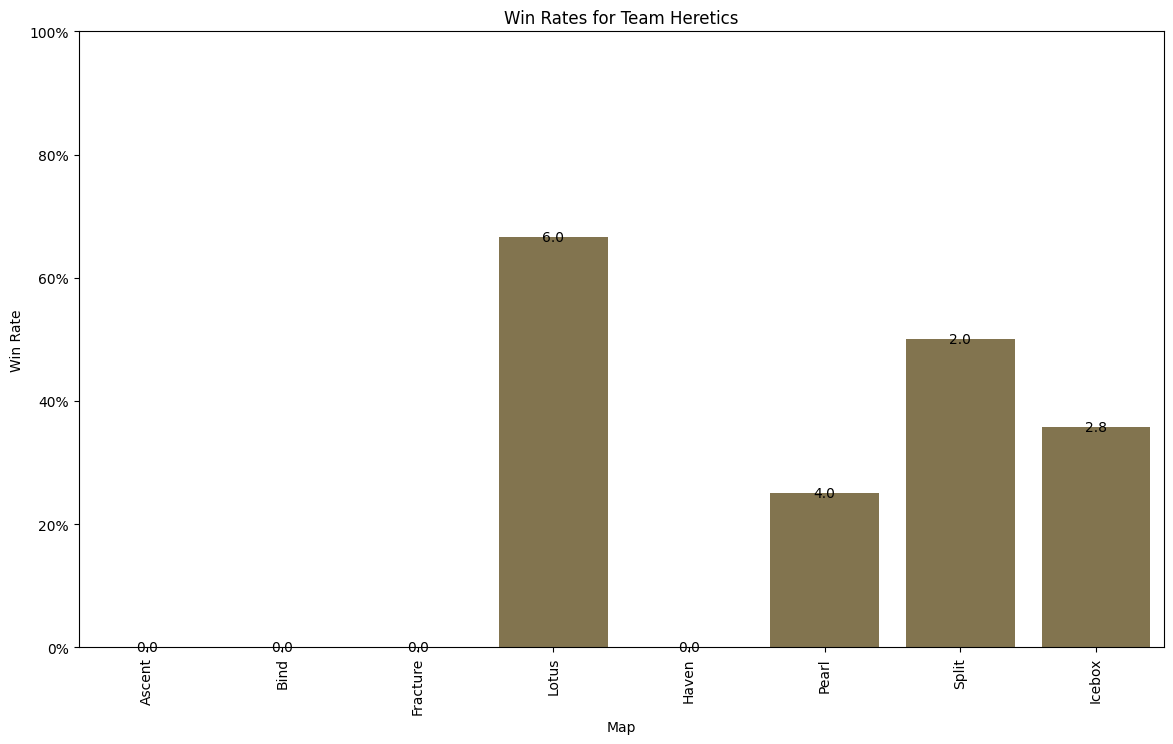

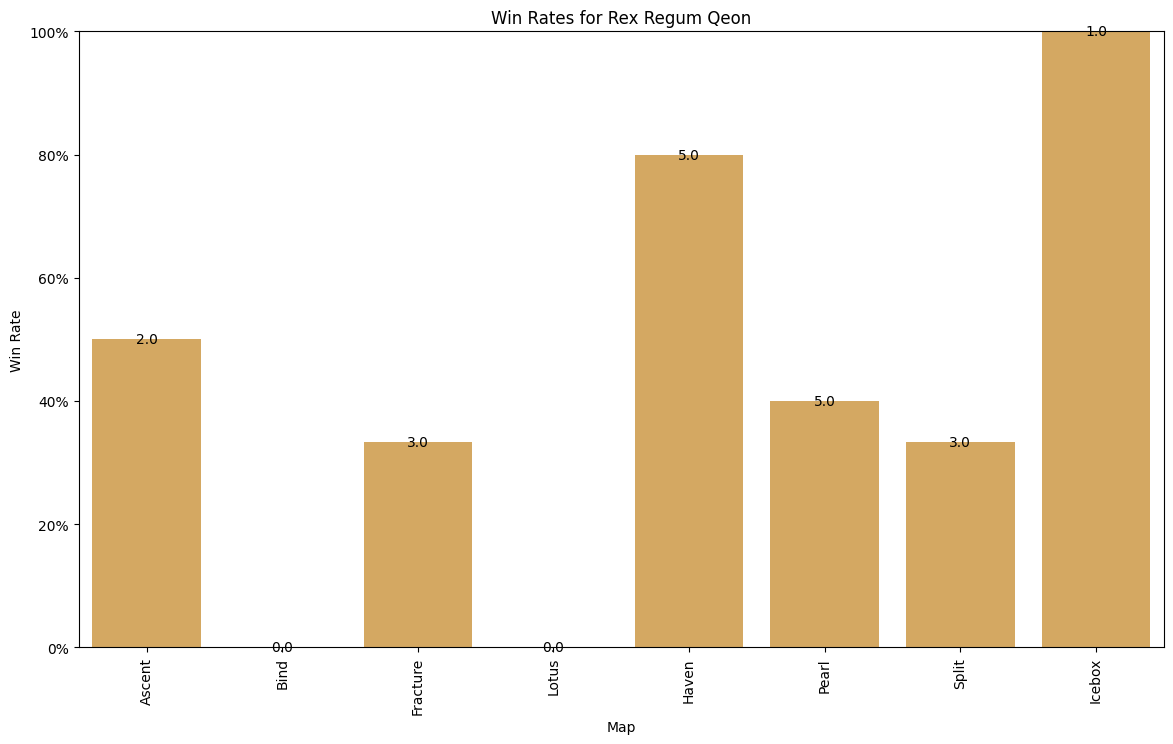

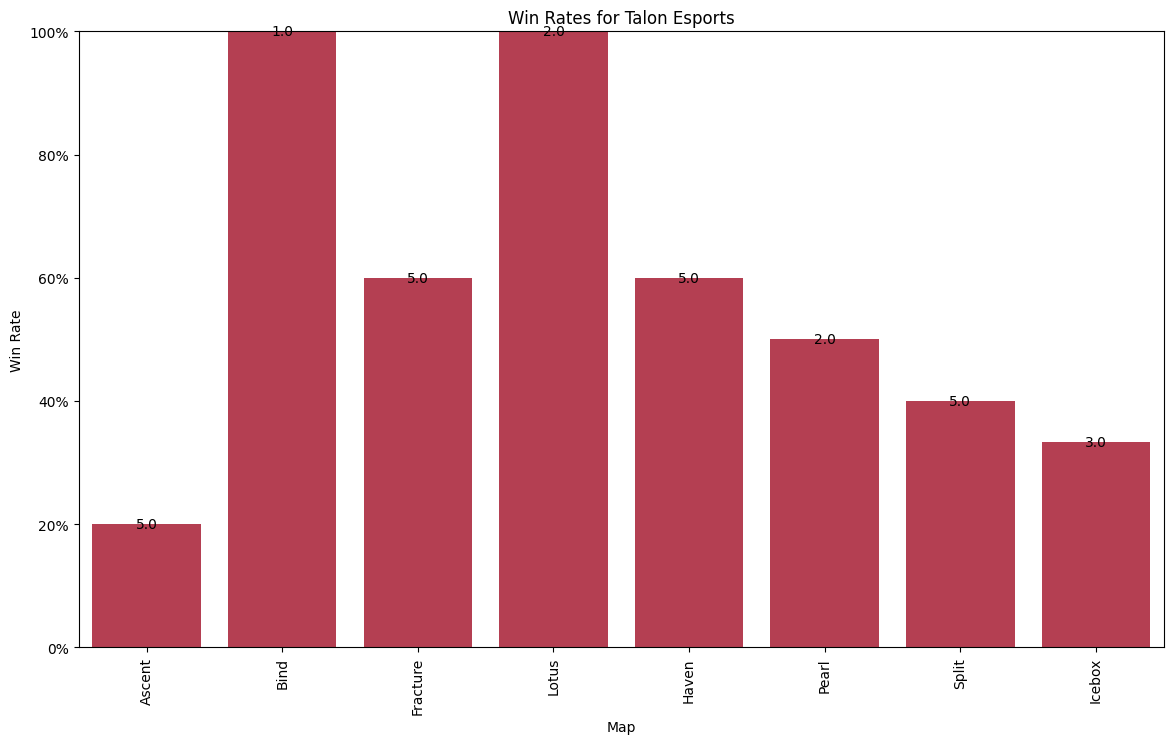

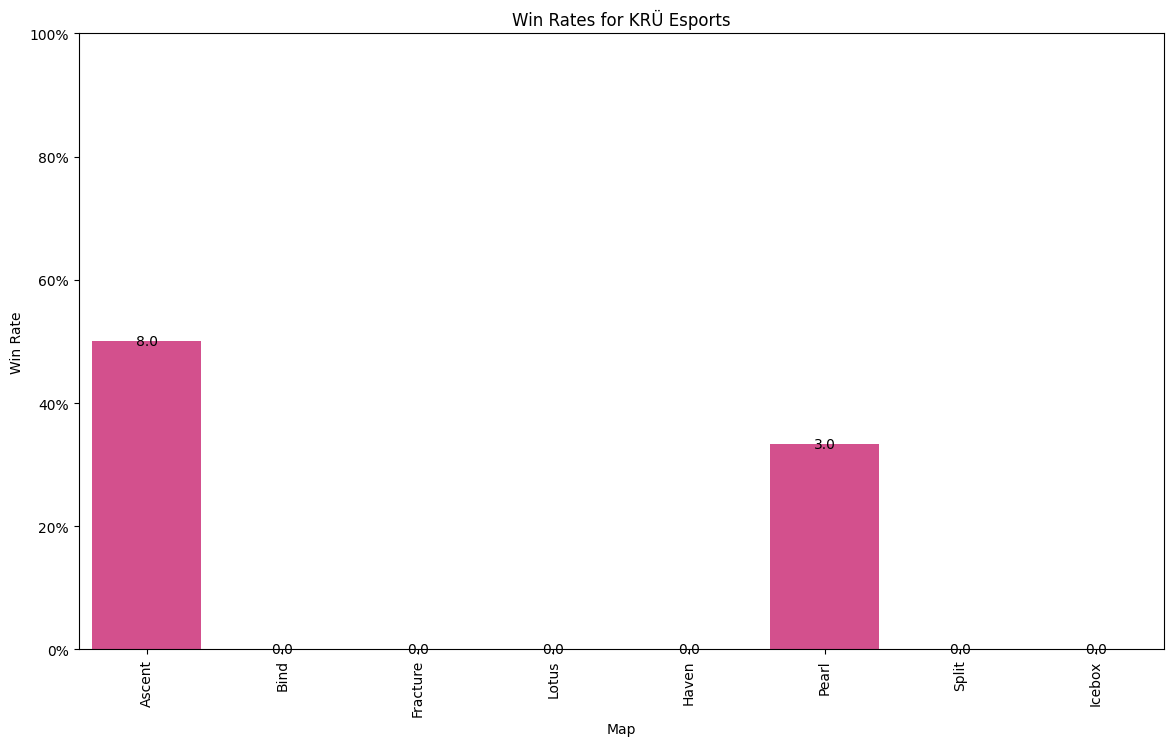

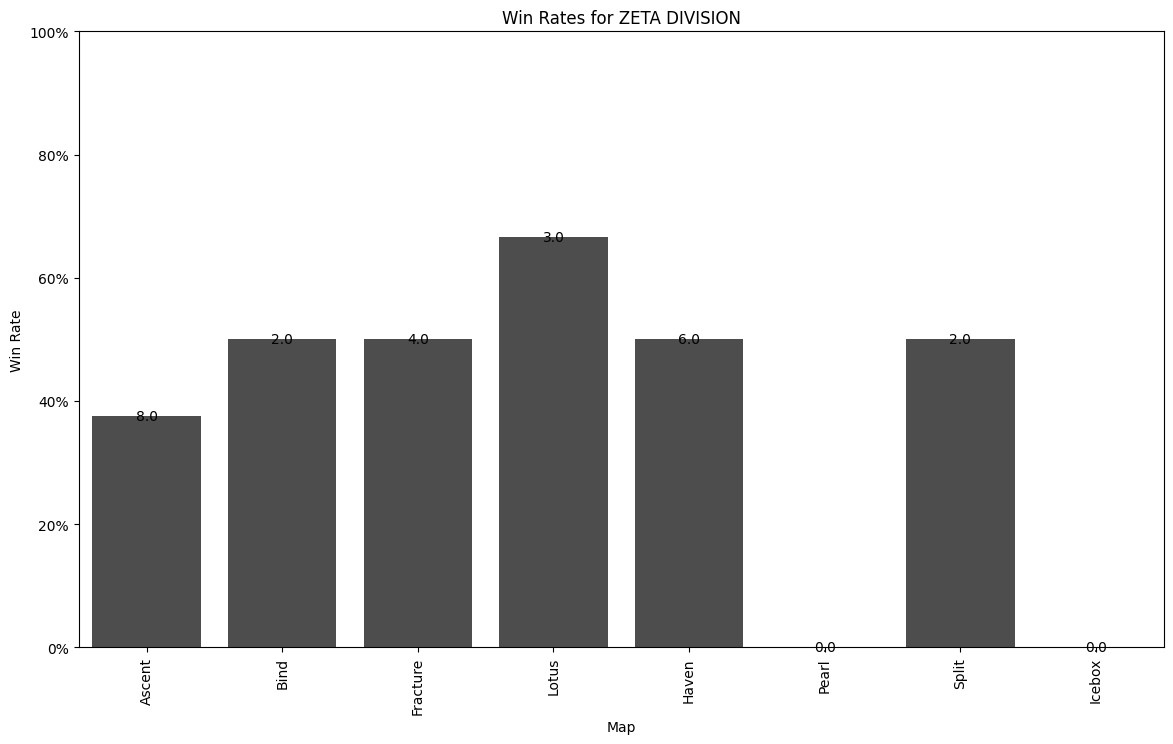

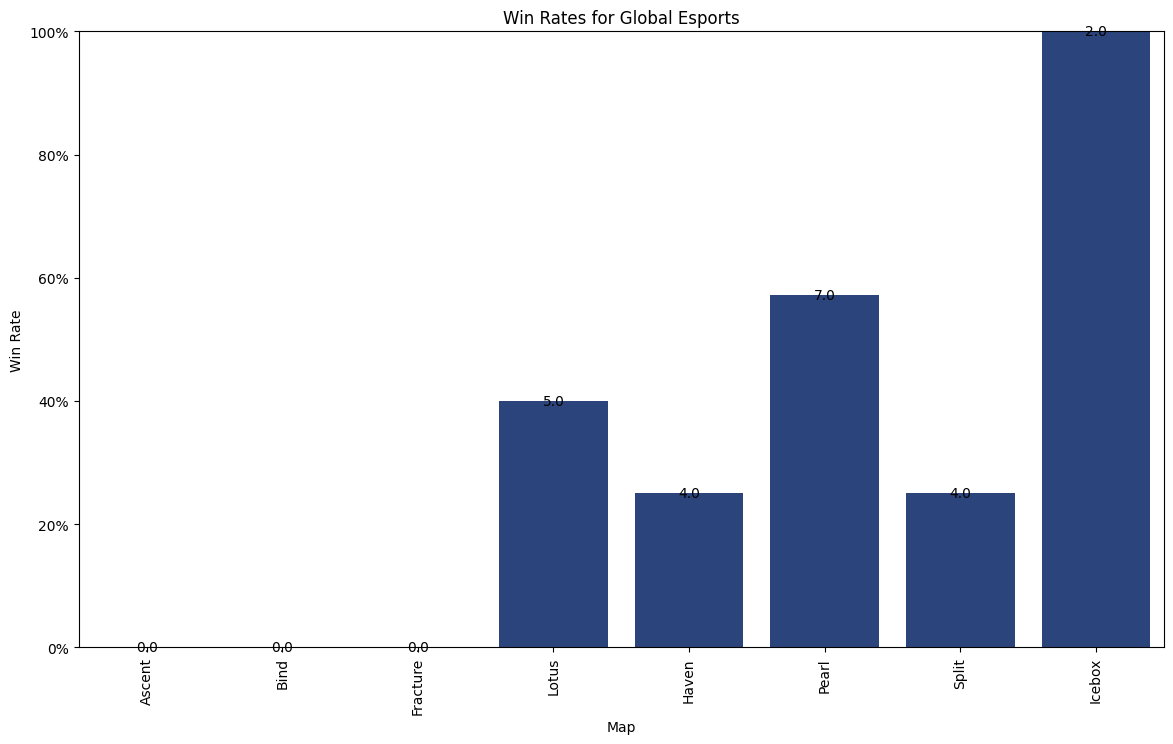

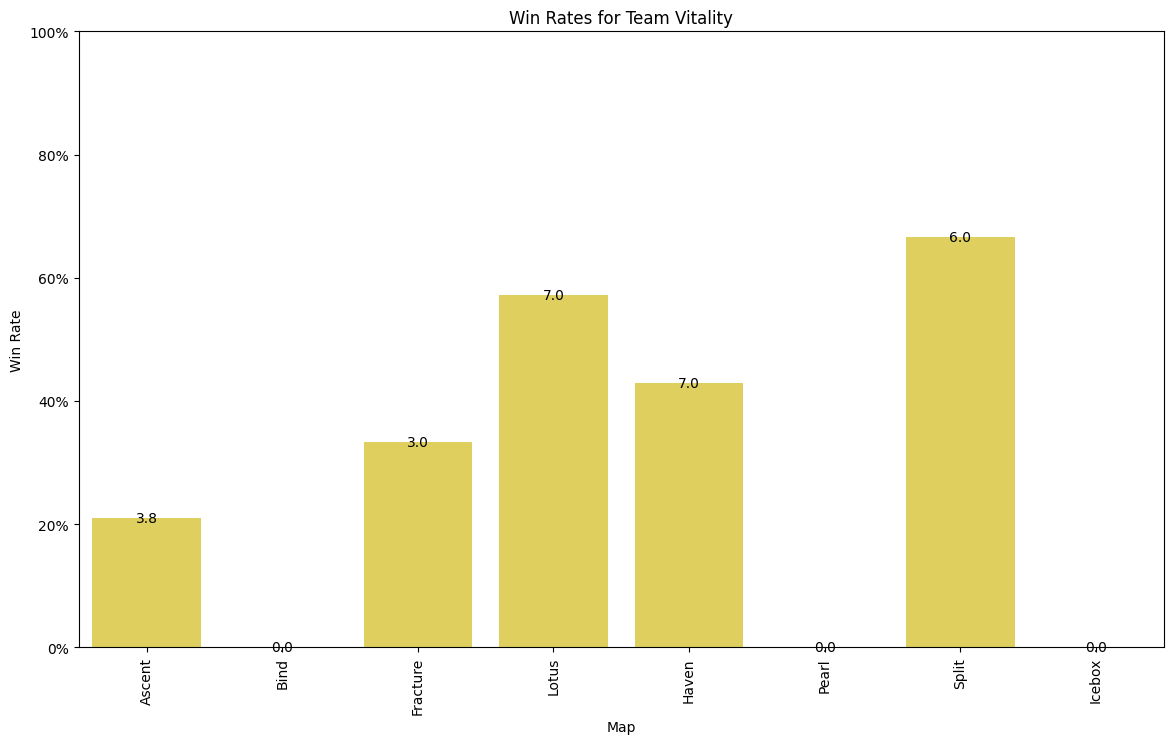

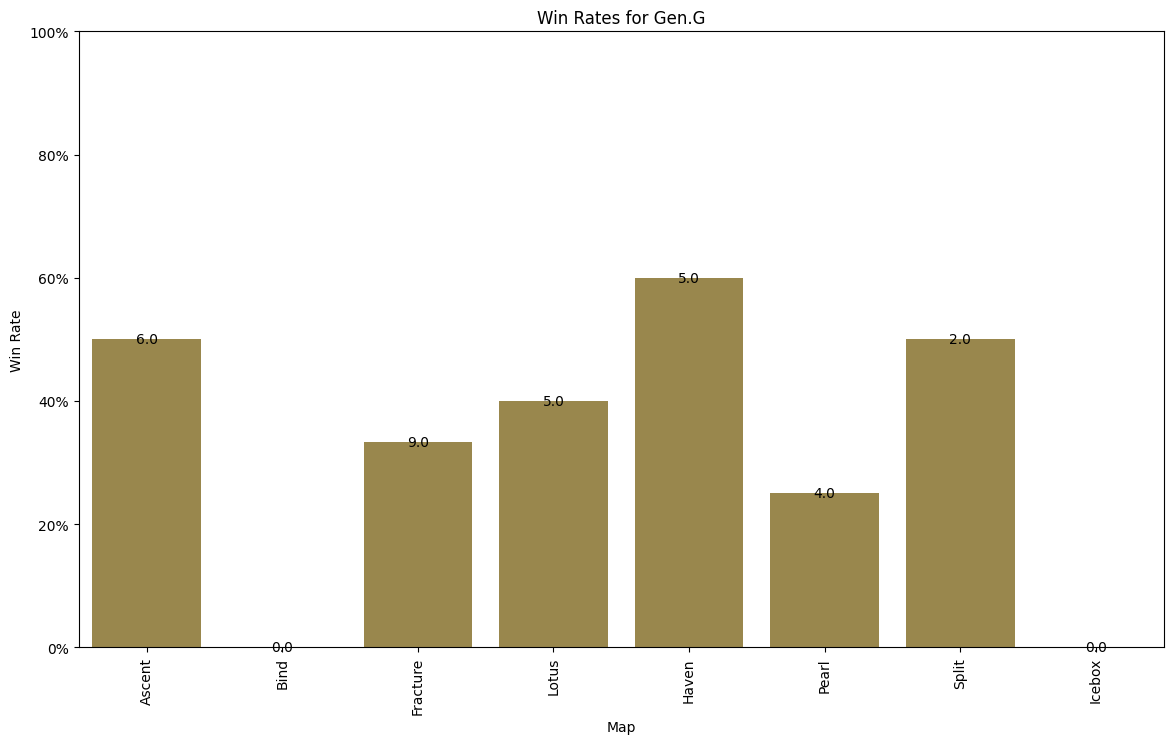

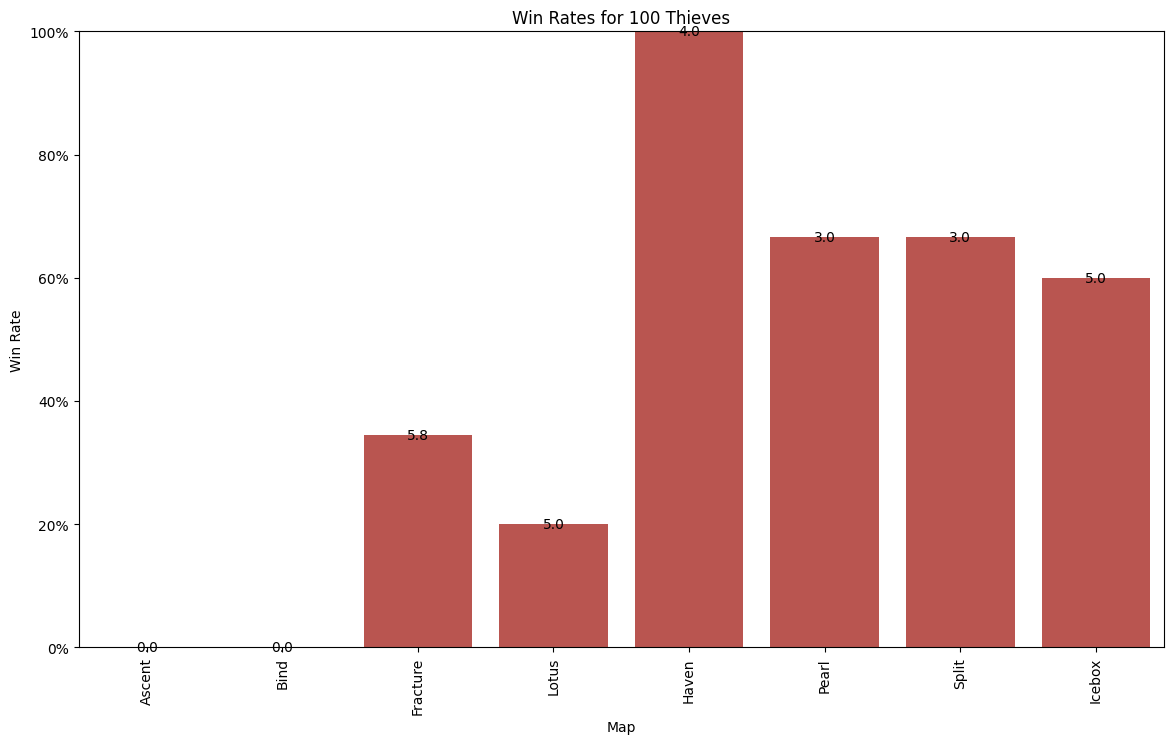

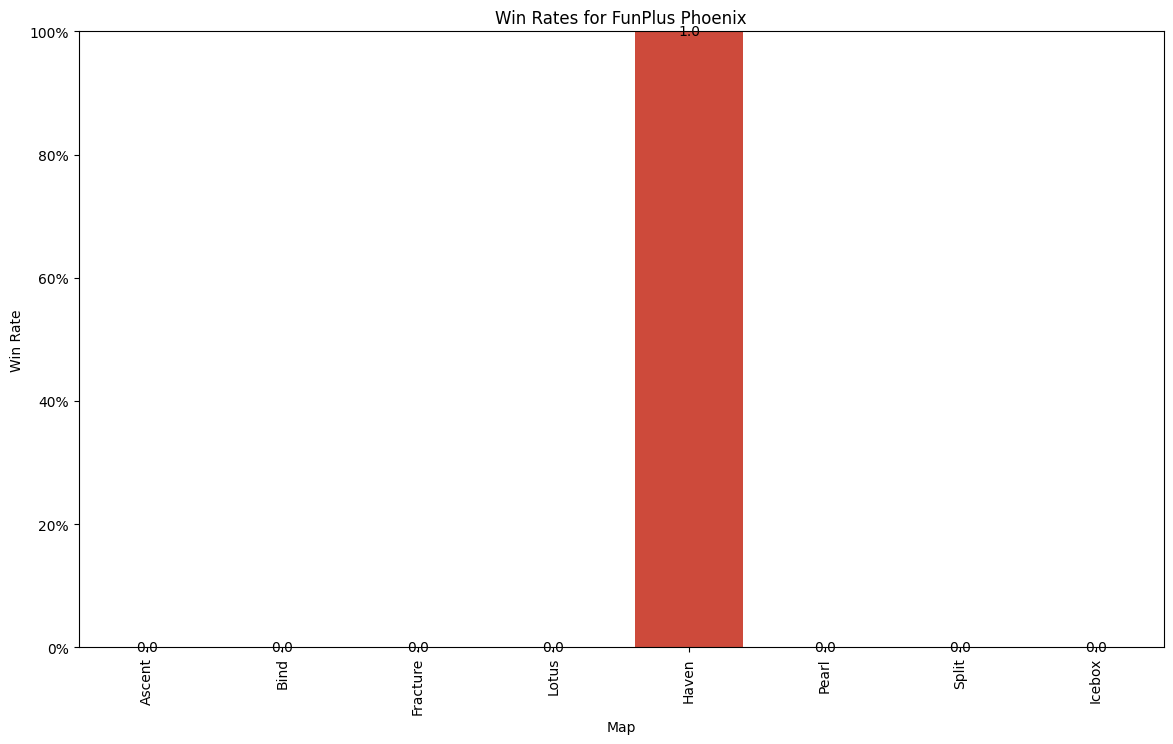

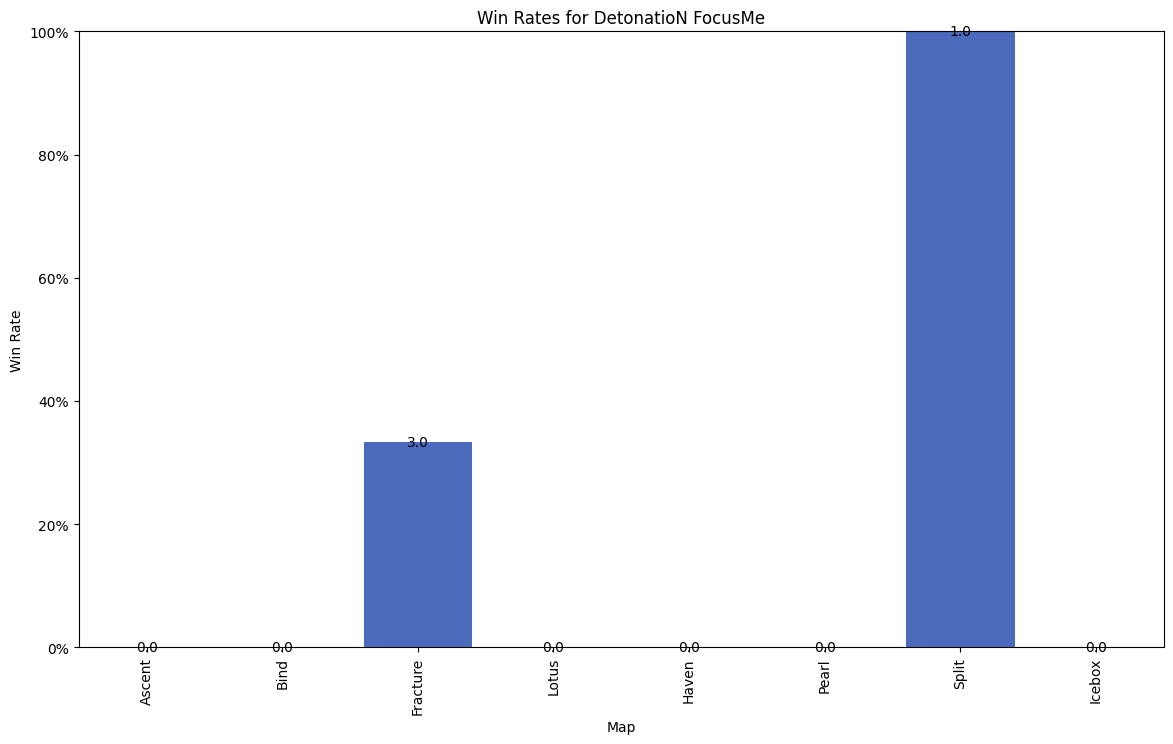

In [ ]:
# For each team, plot their win rates on each map
for team_name in teams:
    plt.figure(figsize=(14, 8))
    
    # Get data for the team and ensure all maps are included
    team_data = map_team_win_rate[map_team_win_rate['team'] == team_name]
    team_data = team_data.set_index('map').reindex(unique_maps).reset_index().fillna({'team': team_name, 'win_rate': 0, 'play_count': 0})
    
    # Set the team color if defined, else use a default color
    team_color = team_colors.get(team_name, "b")
    
    # Create the bar plot
    bar_plot = sns.barplot(x="map", y="win_rate", data=team_data, color=team_color)
    
    # Add the number of times each map was played as text within the bars
    for index, row in team_data.iterrows():
        bar_plot.text(index, row.win_rate, f'{int(row.play_count)/10}', color='black', ha="center", va='center')
    
    plt.xlabel("Map")
    plt.ylabel("Win Rate")
    plt.title(f"Win Rates for {team_name}")
    plt.xticks(rotation=90)
    plt.ylim(0, 1)  # Set y-axis limits to make sure it's between 0 and 1
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.show()


In [ ]:
#League Separation
Americas = {
    "LOUD": "#76FB4C",
    "Cloud9" : "#55ABDF",
    "NRG Esports": "#121416",
    "Leviatán" : "#77A8D6",
    "Evil Geniuses" : "#080C77",
    "FURIA" : "#332F37",
    "100 Thieves" : "#CA453F",
    "Sentinels" : "#BD273C",
    "MIBR" : "#27486F",
    "KRÜ Esports" : "#E93A8C",
}
Emea = {
    "FNATIC" : "#EB642B",
    "Natus Vincere" : "#FCF451",
    "Team Liquid" : "#041435",
    "Giants Gaming" : "#2A64CF",
    "FUT Esports" : "#D43641",
    "BBL Esports" : "#2A173F",
    "Team Vitality" : "#F3DF4A",
    "Team Heretics" : "#8A7846",
    "KOI" : "#633CAC",
    "Karmine Corp" : "#5AC5FA",
}    
Pacific = {
    "DRX" : "#0D039D",
    "Paper Rex" : "#000062",
    "T1" : "#D32D37",
    "ZETA DIVISION" : "#4D4D4D",
    "Gen.G" : "#A58D41",
    "Rex Regum Qeon" : "#E7AC4F",
    "Team Secret" : "#2D2F43",
    "Global Esports" : "#1F3F89",
    "Talon Esports" : "#C82B45",
    "DetonatioN FocusMe" : "#3A62CD",
}
China = {
    "EDward Gaming" : "#D3312A",
    "FunPlus Phoenix" : "#E53623"
}

In [ ]:
df = df.assign(rounds=df['team1-score'] + df['team2-score'])
df['winner_name'] = np.where(df['winning_team'] == 'team1', df['team1'], df['team2'])
filtered_df = df[['player-team','rating','rating-ct','rating-t','acs','acs-t','acs-ct','fk','fk-t','fk-ct','k','k-t','k-ct','d','d-t','d-ct','tkmd','tkmd-t','tkmd-ct','fd','fd-t','fd-ct','fkmd','fkmd-t','fkmd-ct', 'rounds', 'winner_name']]

In [ ]:
team_names = filtered_df['player-team'].unique()

team_dfs = {team: filtered_df[filtered_df['player-team'] == team] for team in team_names}

In [ ]:
team_names = filtered_df['player-team'].unique()

# Create an empty DataFrame to store averages
averages_df = pd.DataFrame(columns=filtered_df.columns)

# For each team
for team in team_names:
    team_df = filtered_df[filtered_df['player-team'] == team]
    averages_df.loc[team, :] = team_df.mean(numeric_only=True)


In [ ]:
# Select only numeric columns
teams_Avg = averages_df.select_dtypes(include=[np.number])


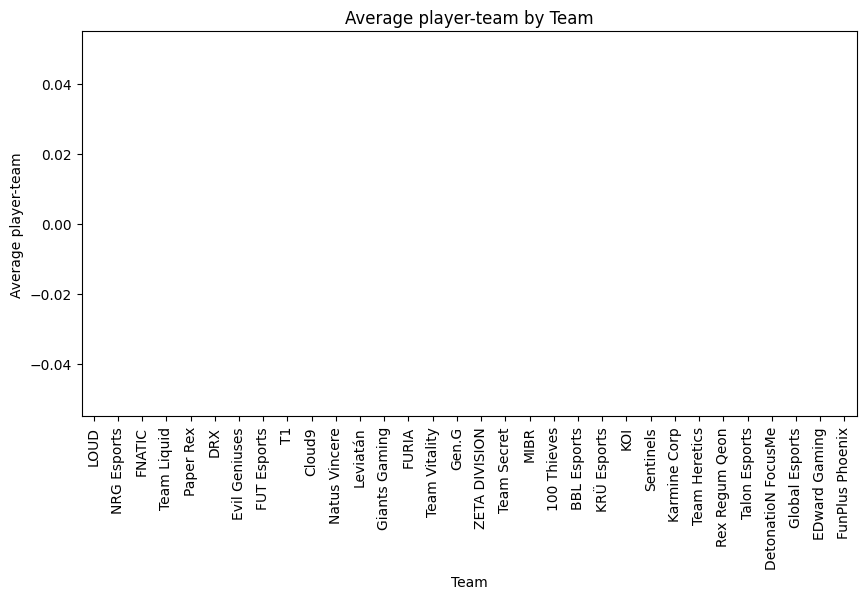

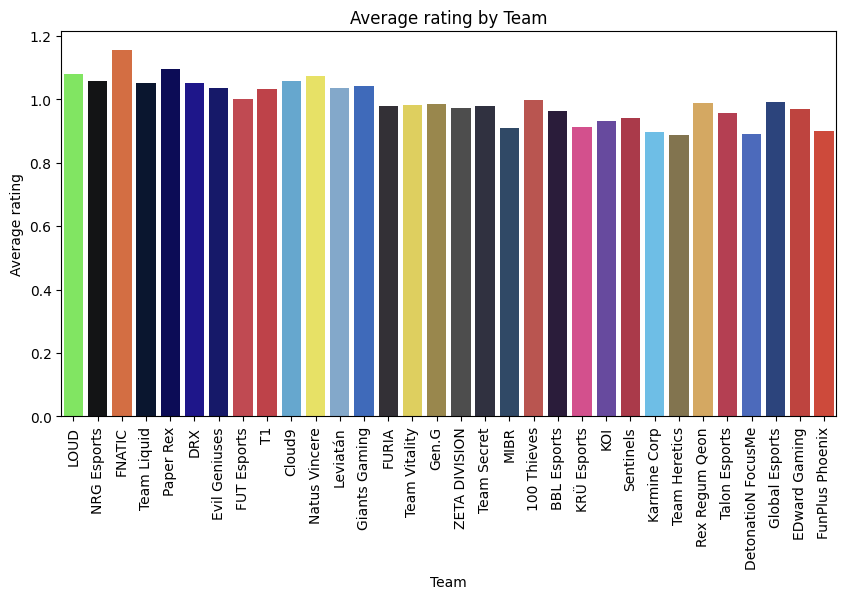

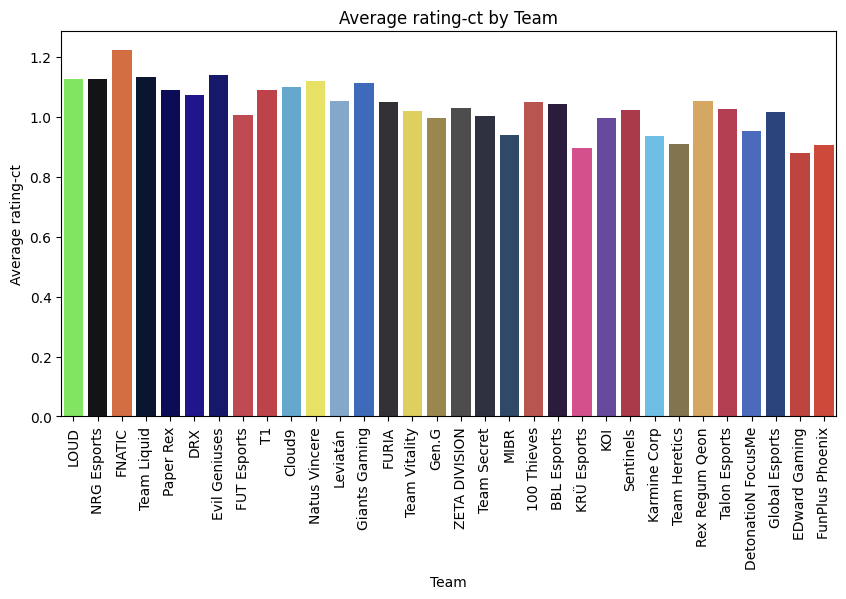

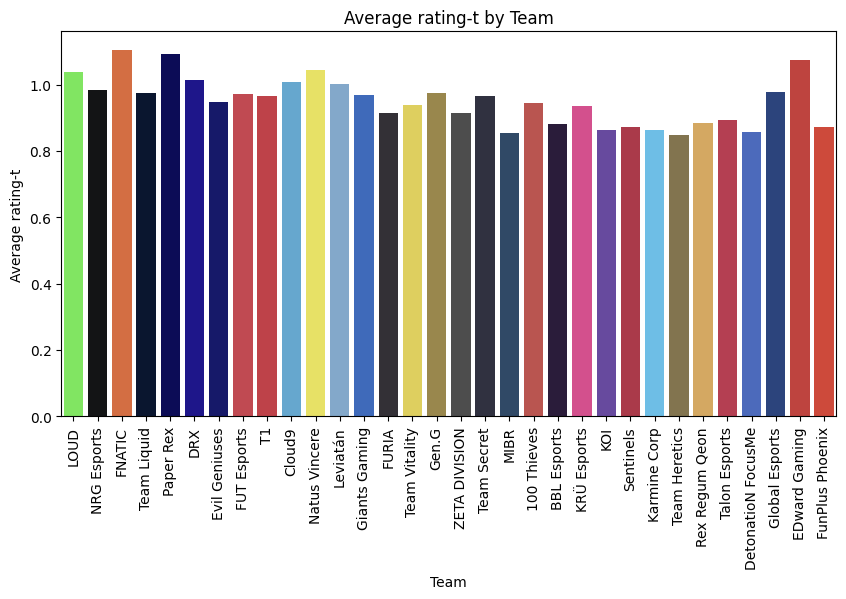

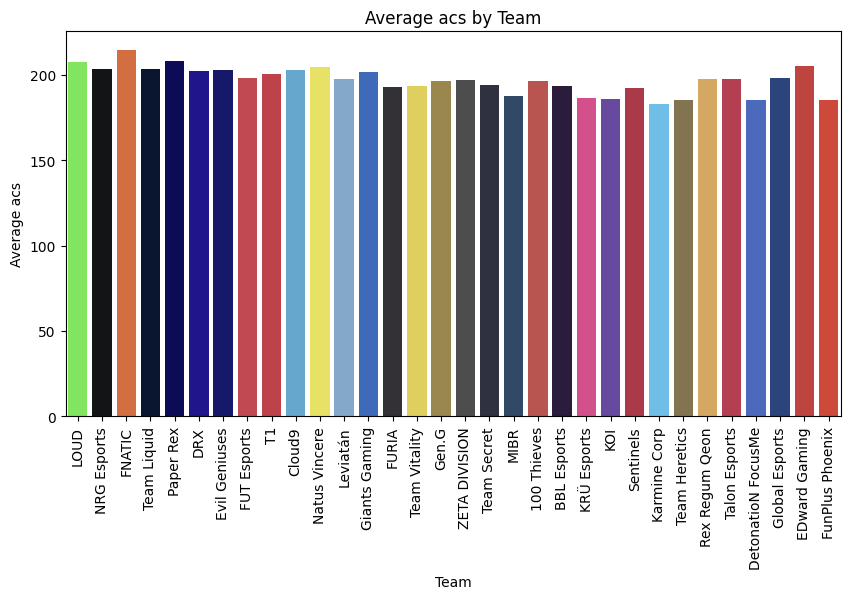

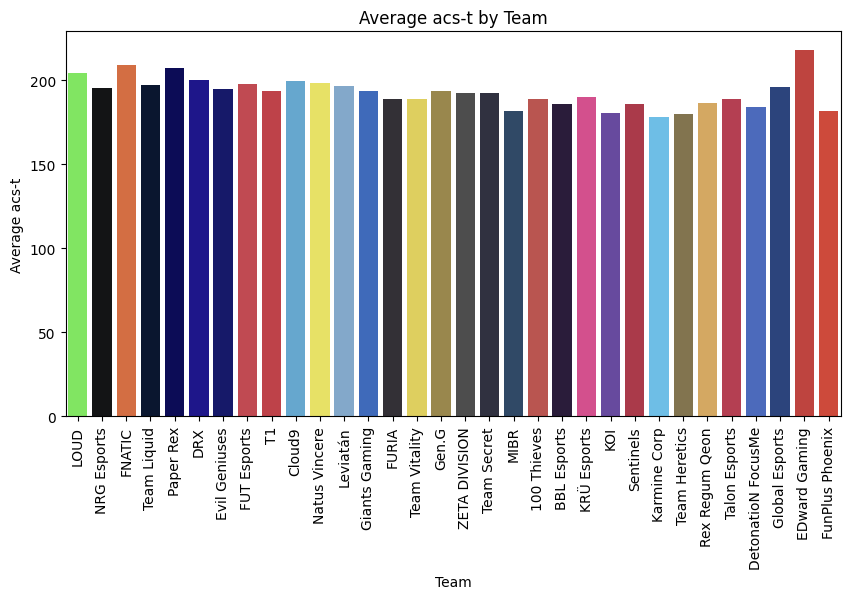

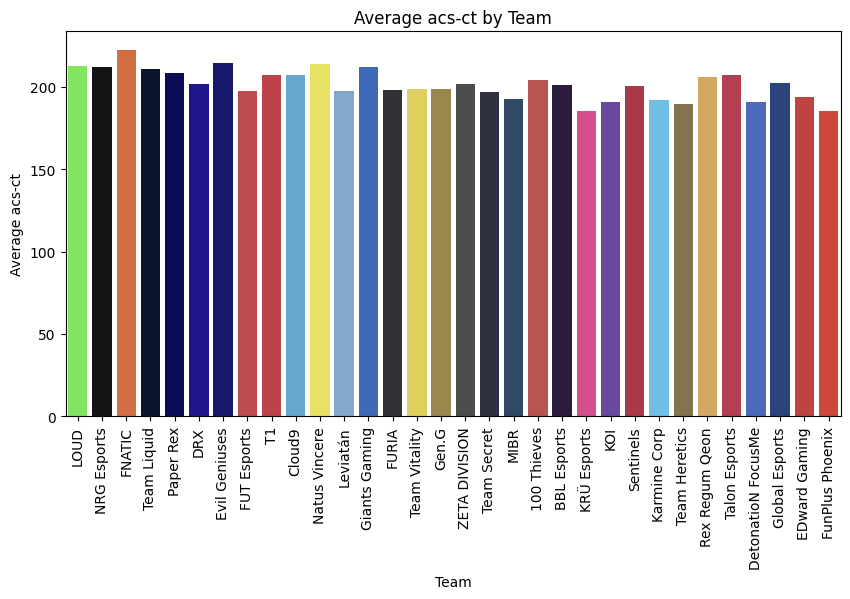

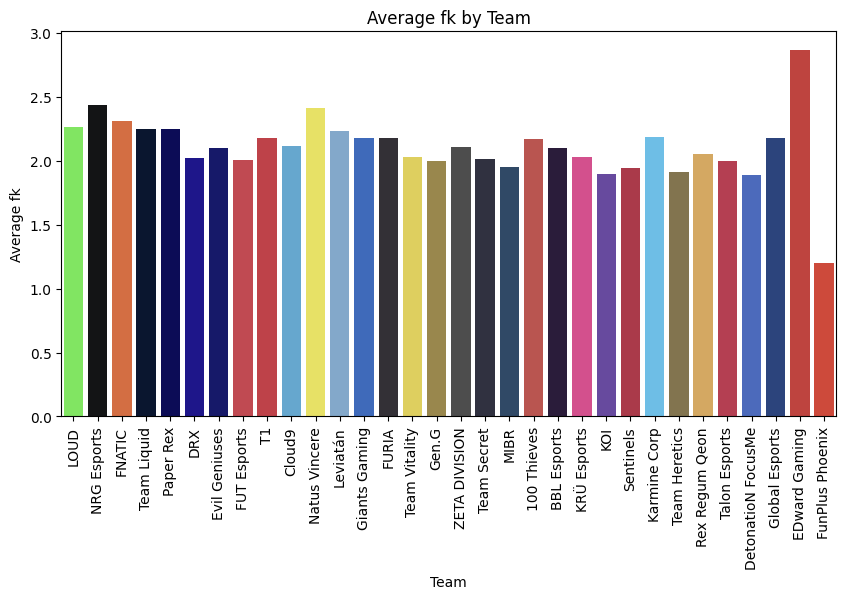

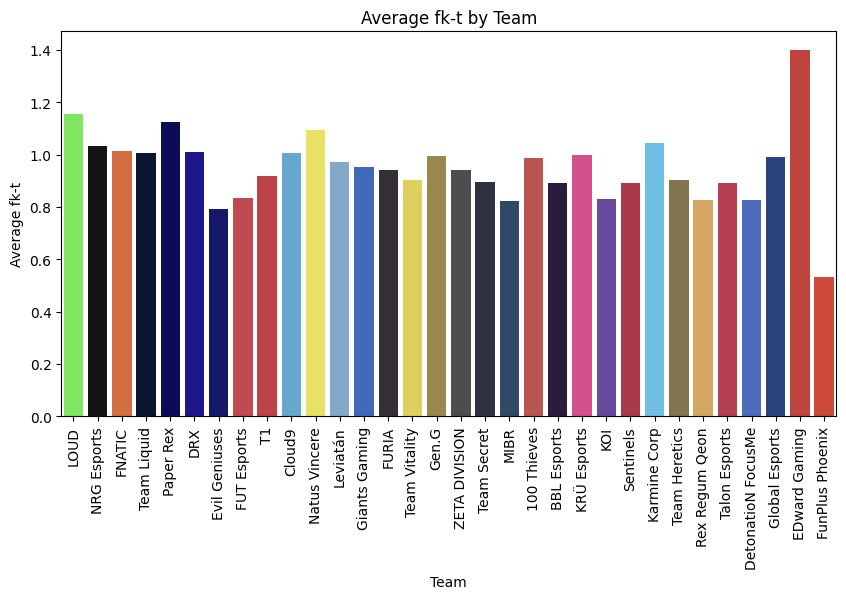

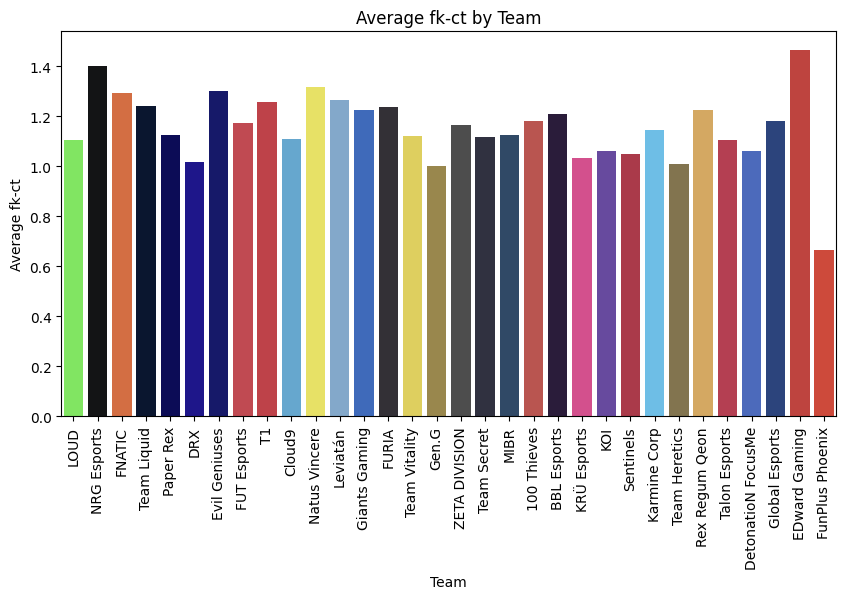

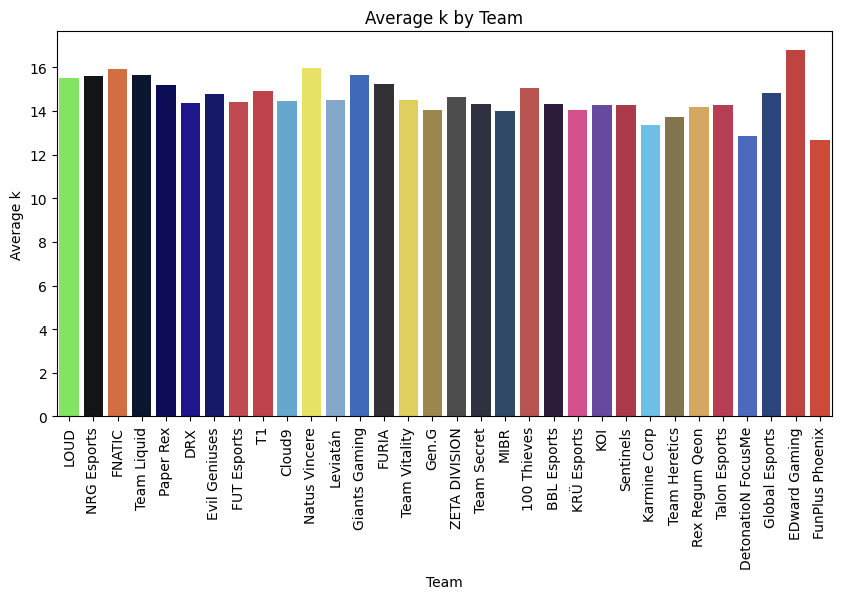

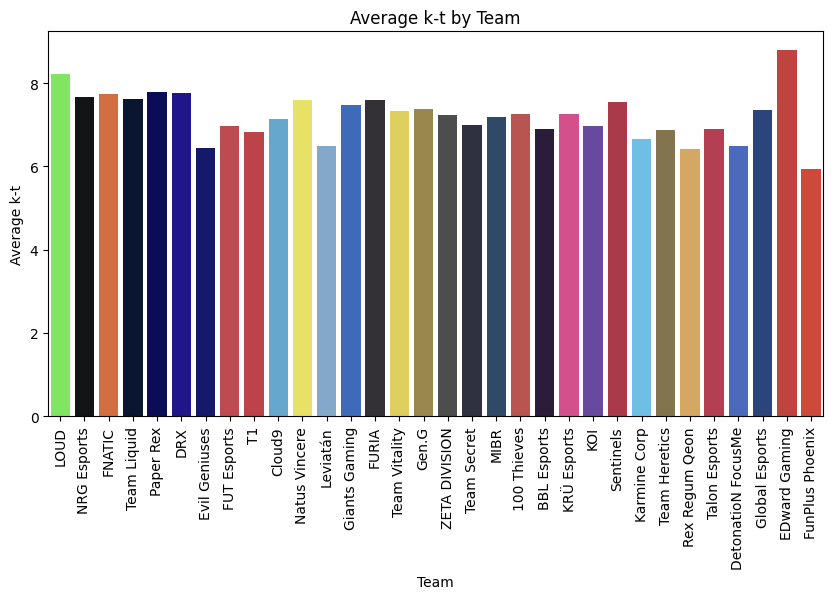

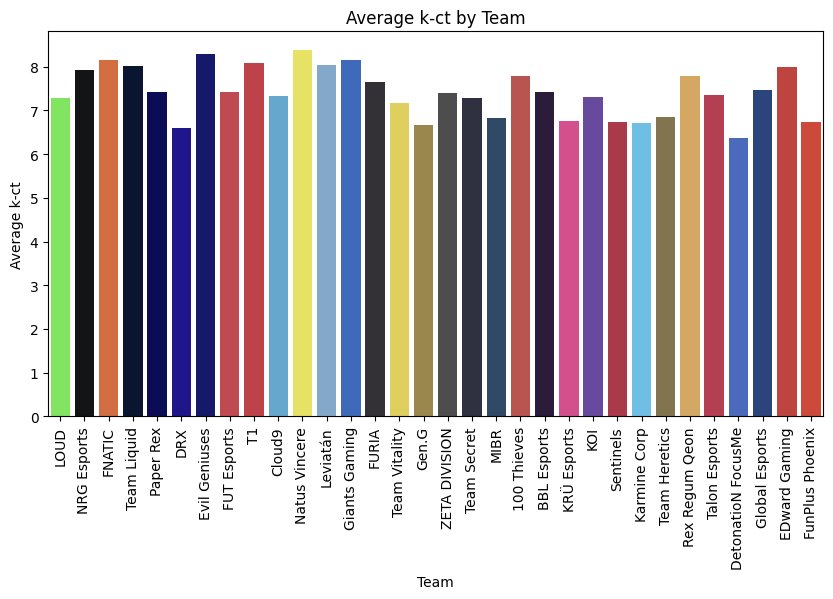

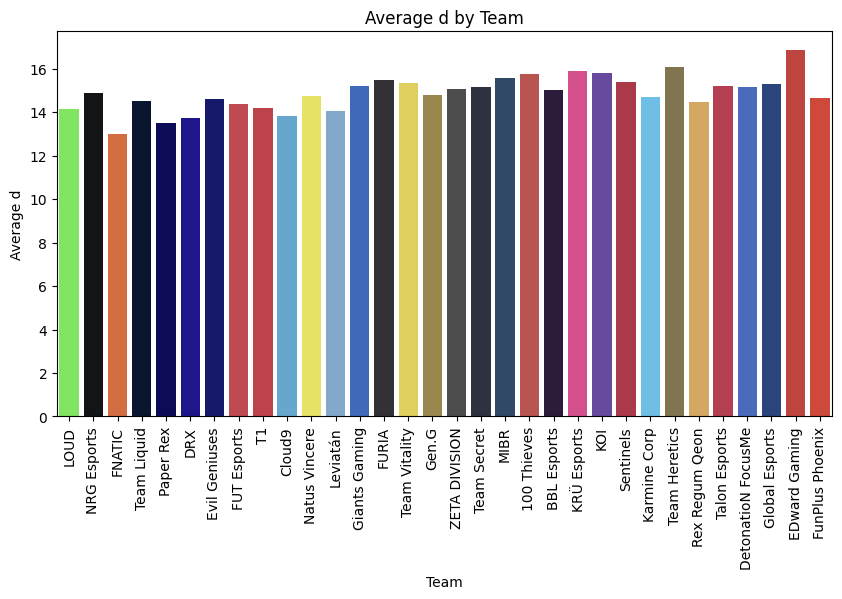

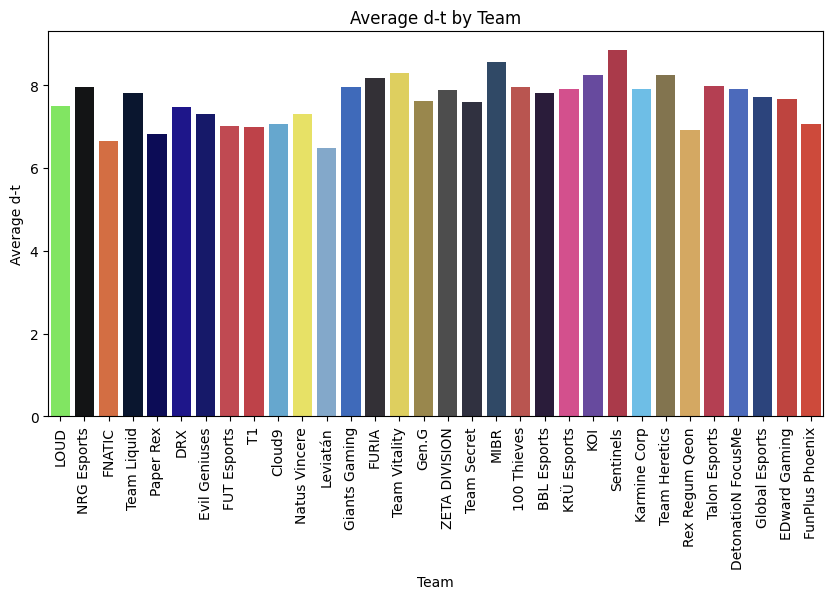

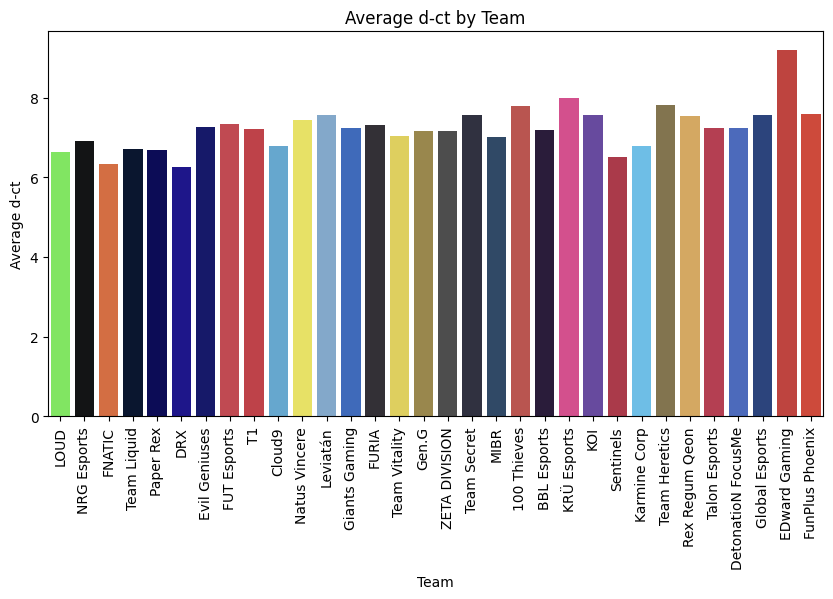

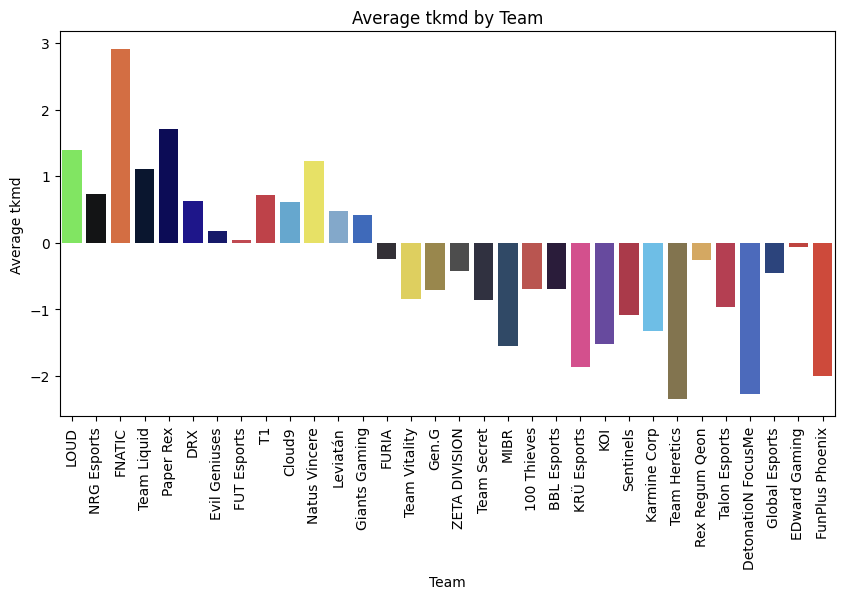

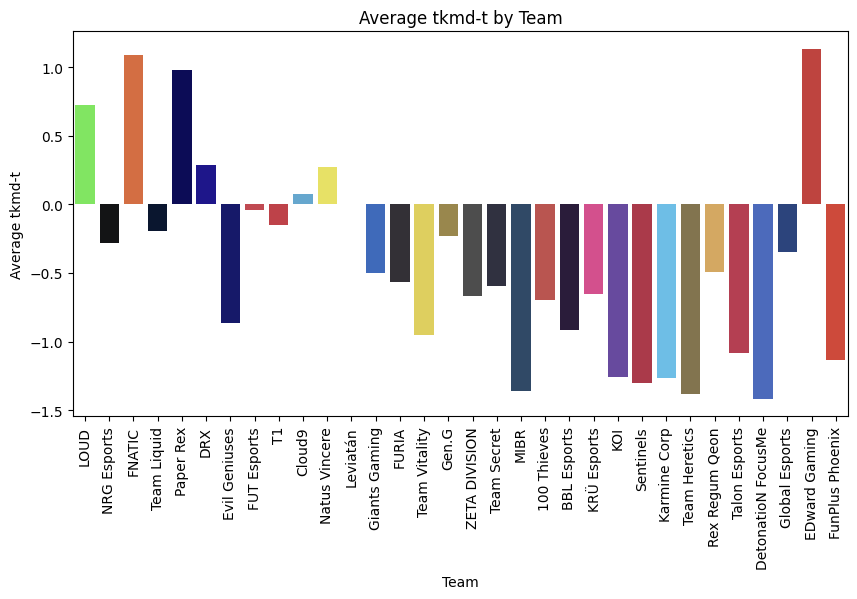

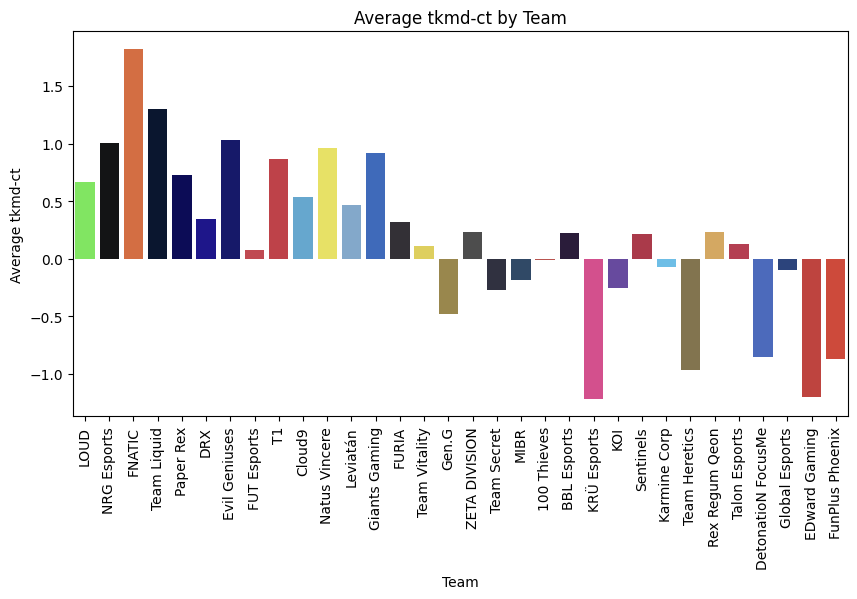

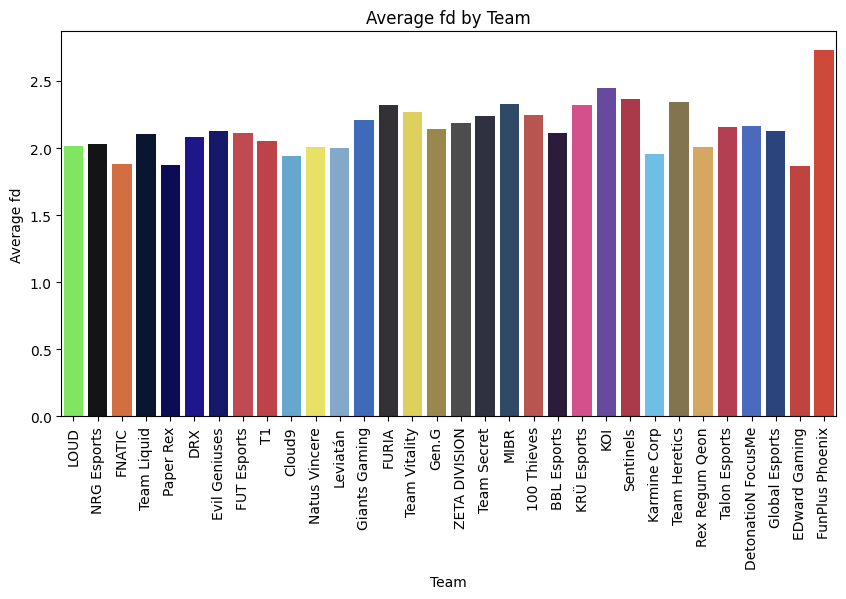

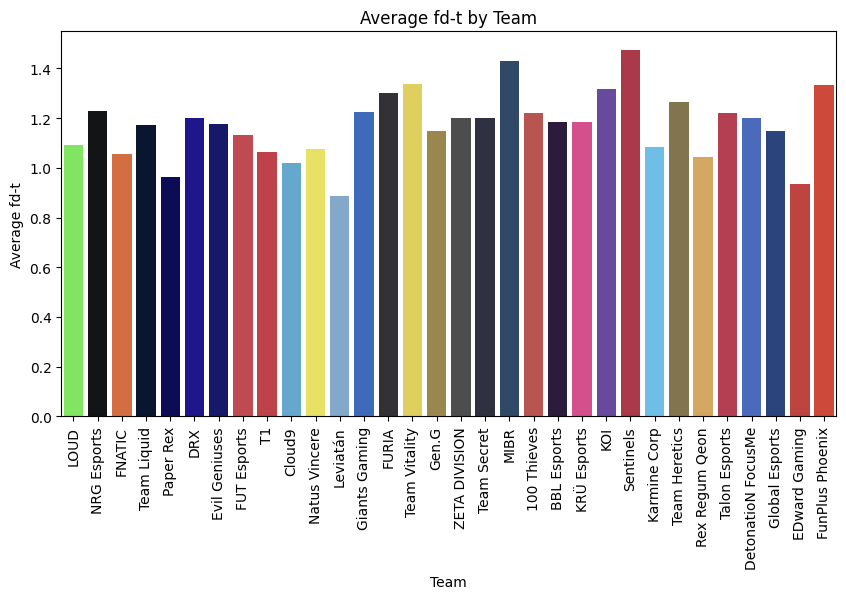

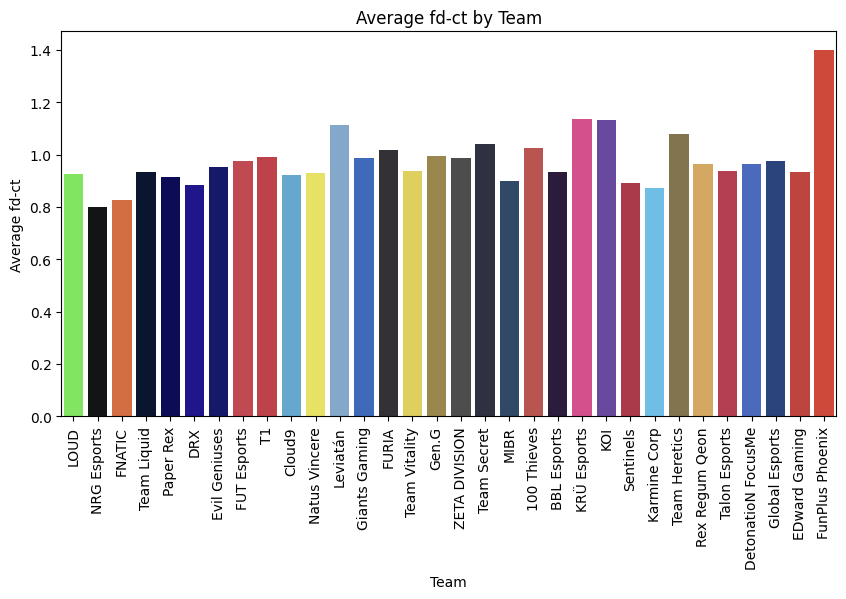

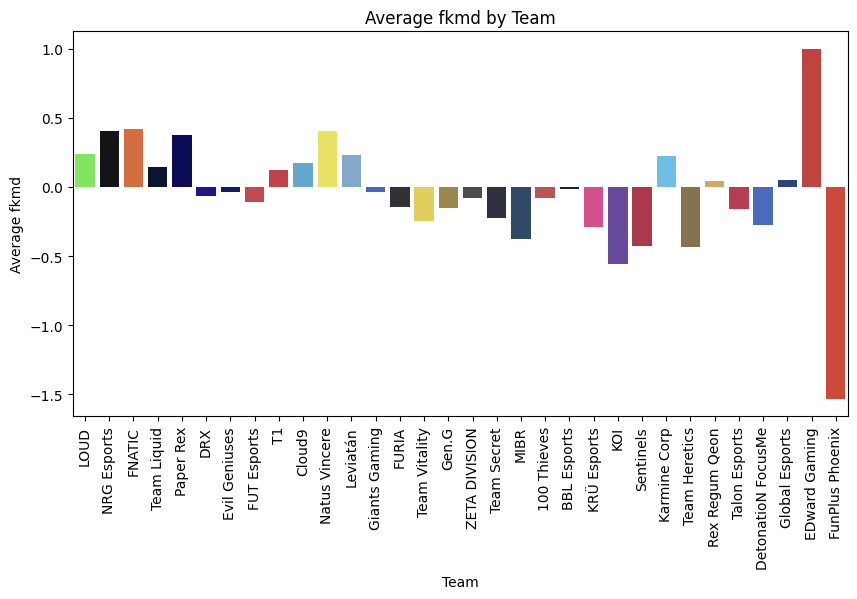

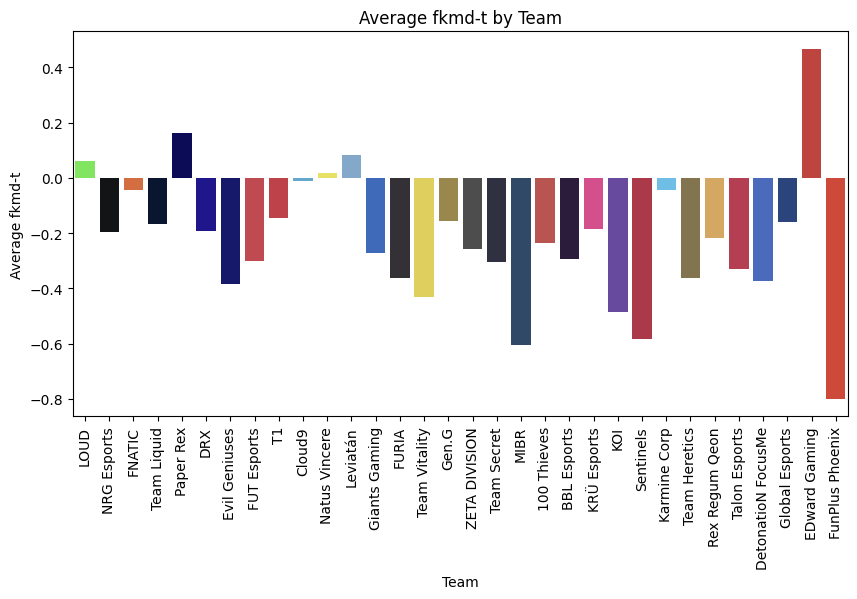

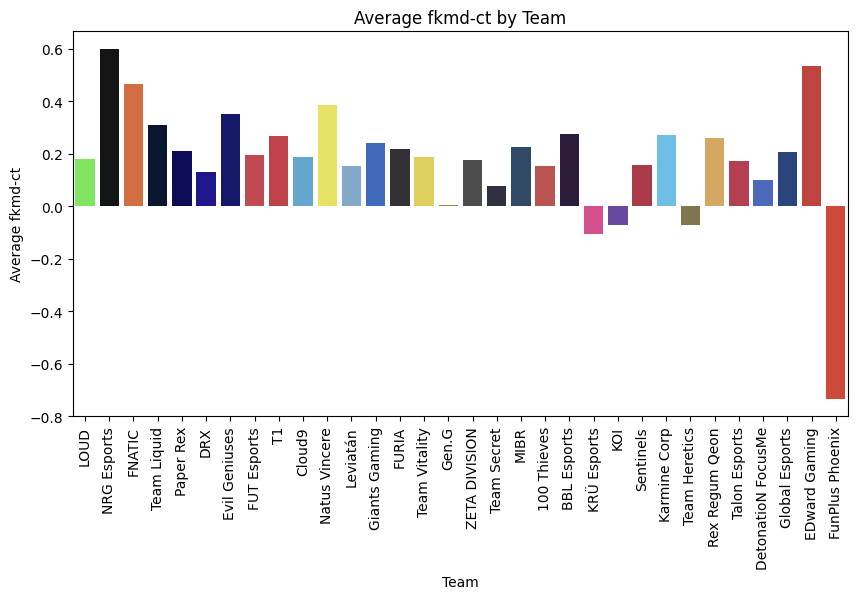

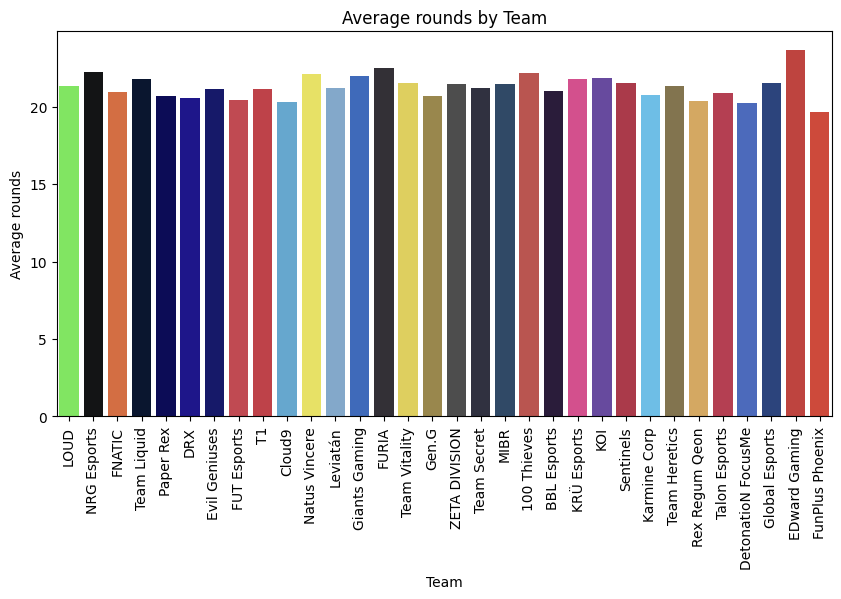

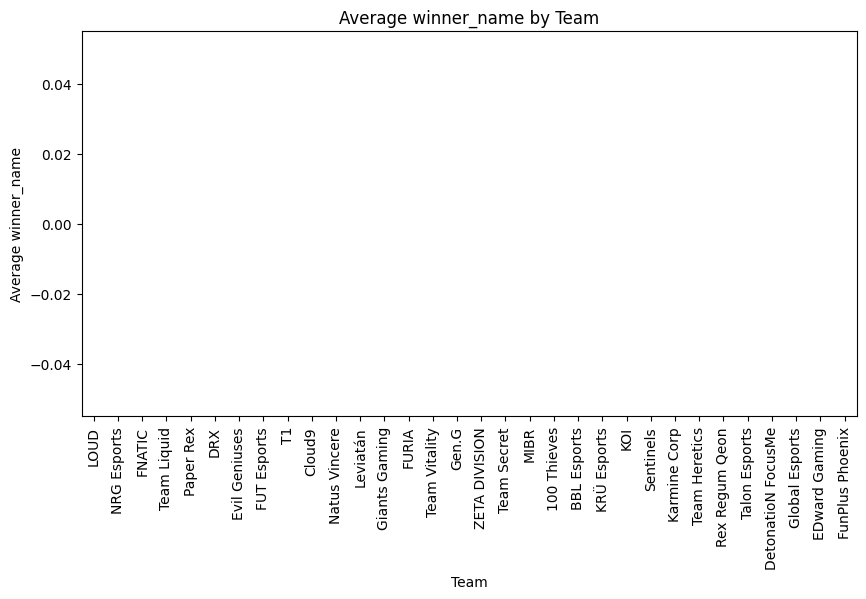

In [ ]:
# Create a copy of averages_df
averages_df_numeric = averages_df.copy()

# Convert values in averages_df_numeric to numeric
averages_df_numeric = averages_df_numeric.apply(pd.to_numeric)

# For each column in the DataFrame
for column in averages_df.columns:
    # Create a new figure
    plt.figure(figsize=(10,5))
    
    # Create a bar plot of the column
    sns.barplot(x=averages_df_numeric.index, y=averages_df_numeric[column], palette=team_colors)
    
    # Set the title and labels
    plt.title(f'Average {column} by Team')
    plt.xlabel('Team')
    plt.xticks(rotation=90)
    plt.ylabel(f'Average {column}')
    
    # Show the plot
    plt.show()


In [ ]:
# Assuming 'df' is your DataFrame and 'player-team' is your column with team names

# Get the unique team names
team_names = filtered_df['player-team'].unique()

# Create a dictionary to store each team's DataFrame
team_dfs = {}

# For each team
for team in team_names:
    # Filter the DataFrame for the current team and store it in the dictionary
    team_dfs[team] = filtered_df[filtered_df['player-team'] == team]


In [ ]:
for team, team_df in team_dfs.items():
    print(f"Summary statistics for {team}:")
    print(team_df.describe())


Summary statistics for LOUD:
           rating   rating-ct    rating-t         acs       acs-t      acs-ct  \
count  239.000000  239.000000  239.000000  239.000000  239.000000  239.000000   
mean     1.080251    1.126946    1.039331  207.527197  204.648536  212.916318   
std      0.293783    0.427321    0.393591   59.923886   77.997804   86.316116   
min      0.310000    0.070000    0.050000   63.000000   40.000000   19.000000   
25%      0.860000    0.845000    0.735000  166.000000  152.000000  153.500000   
50%      1.060000    1.070000    0.990000  205.000000  197.000000  202.000000   
75%      1.270000    1.340000    1.300000  243.000000  249.000000  258.000000   
max      1.890000    3.150000    2.250000  416.000000  421.000000  631.000000   

               fk        fk-t       fk-ct           k  ...        tkmd  \
count  239.000000  239.000000  239.000000  239.000000  ...  239.000000   
mean     2.259414    1.154812    1.104603   15.518828  ...    1.393305   
std      1.717332  

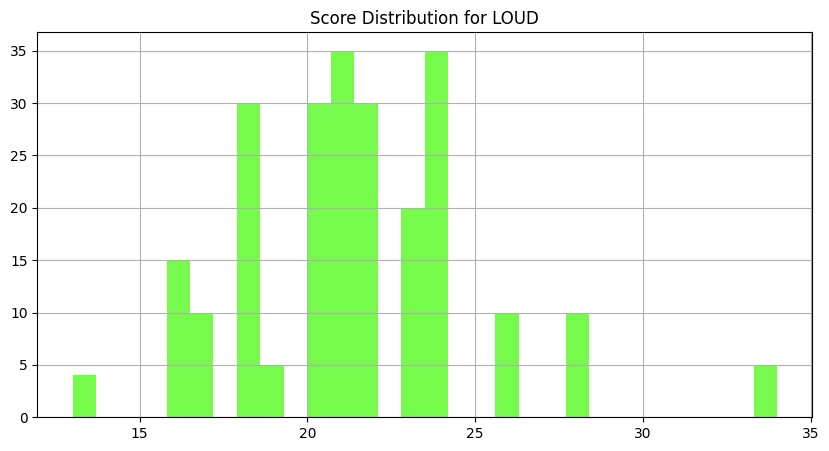

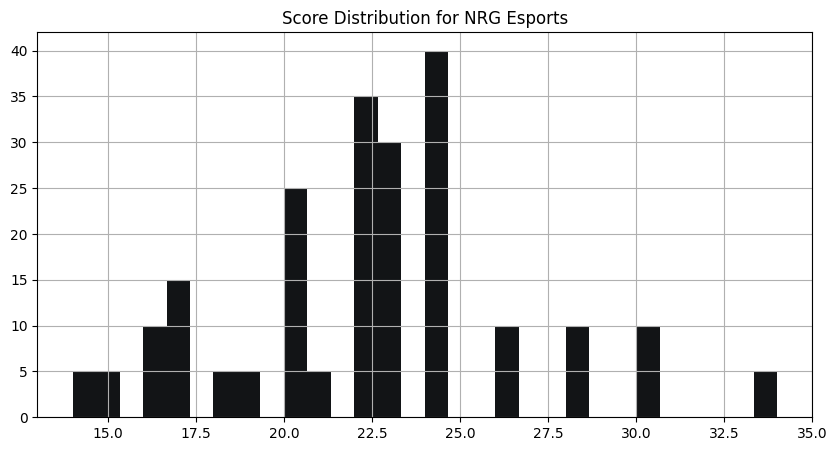

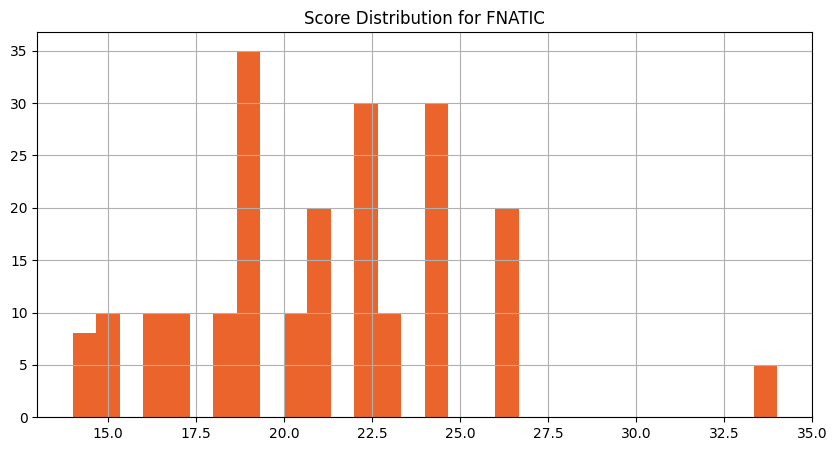

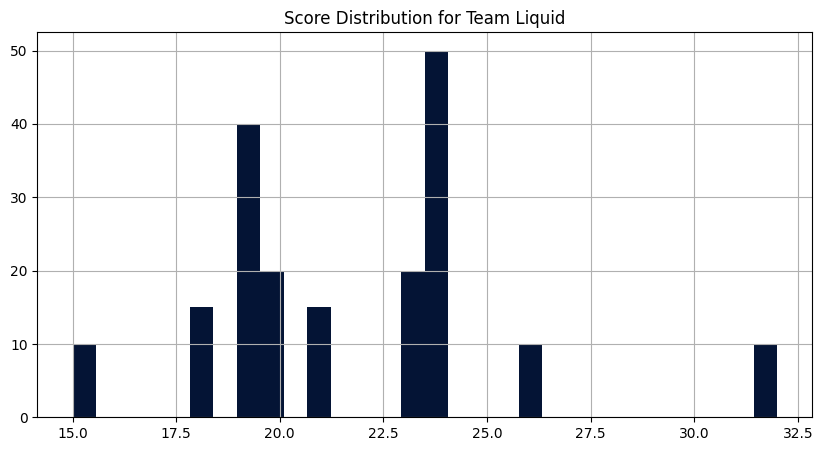

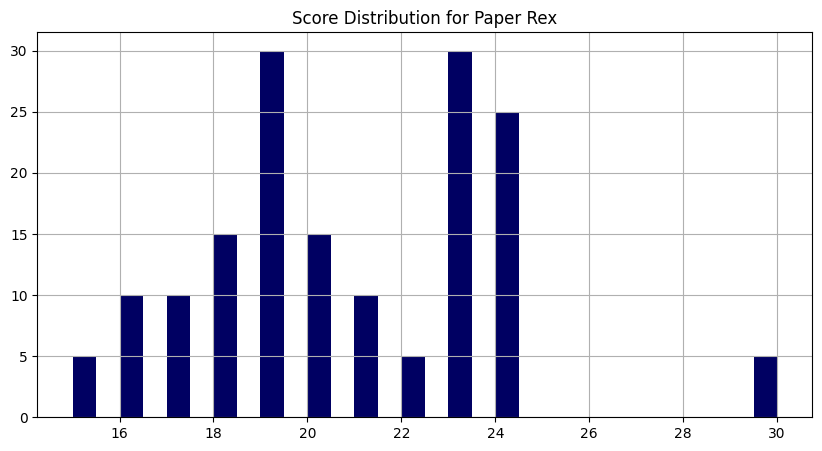

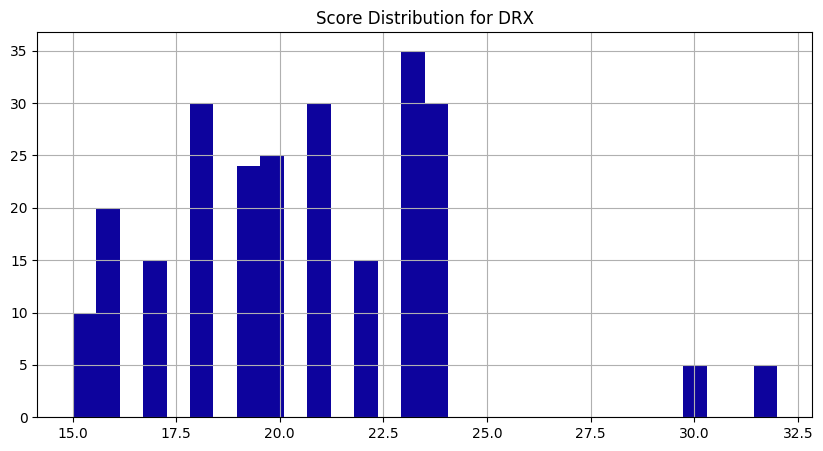

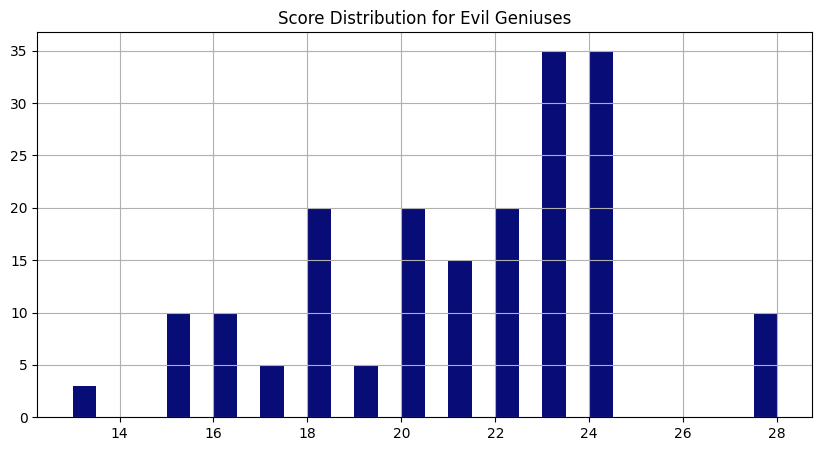

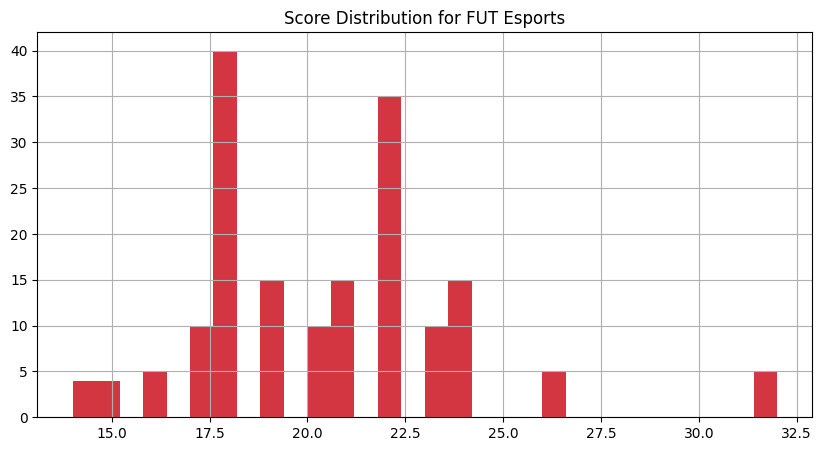

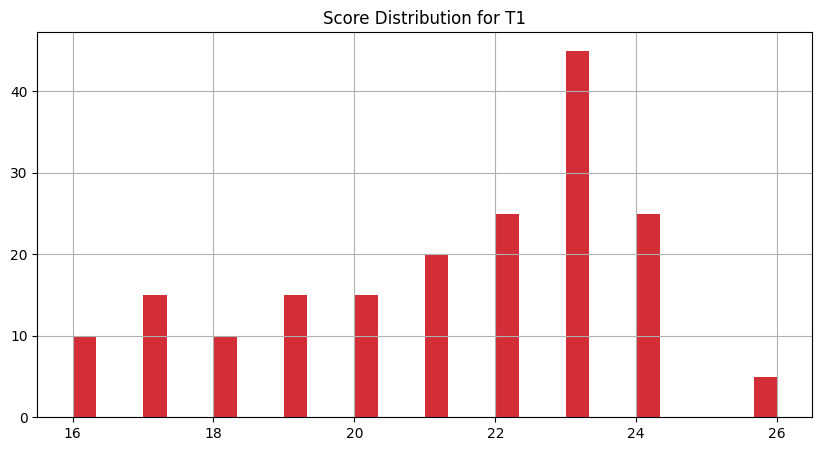

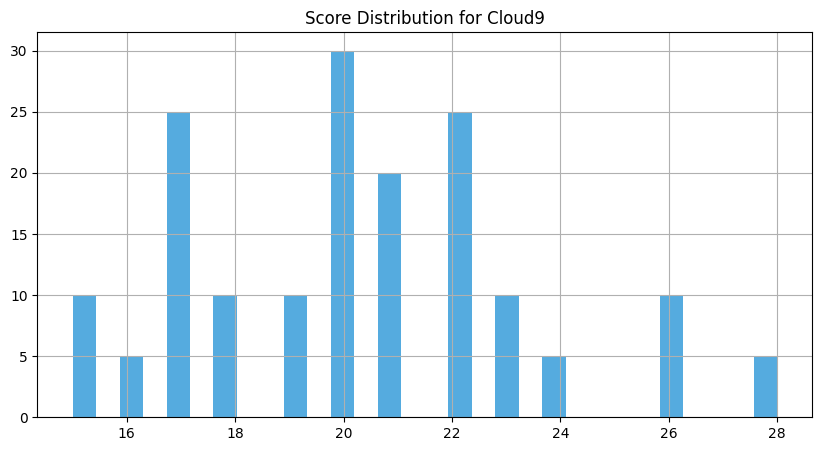

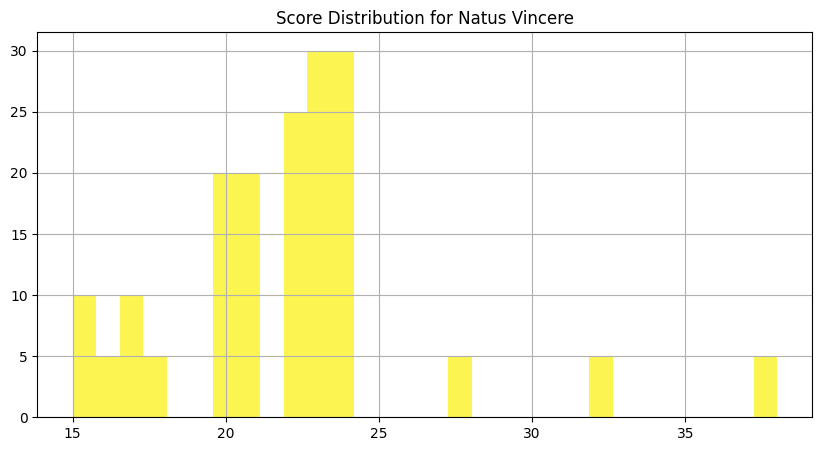

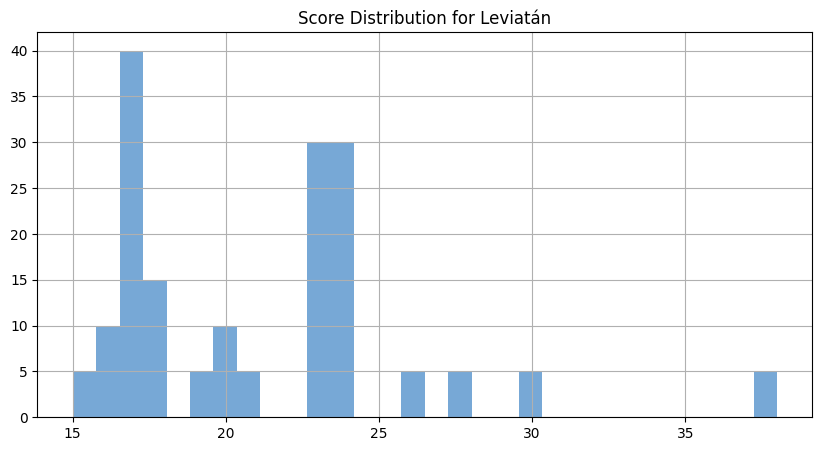

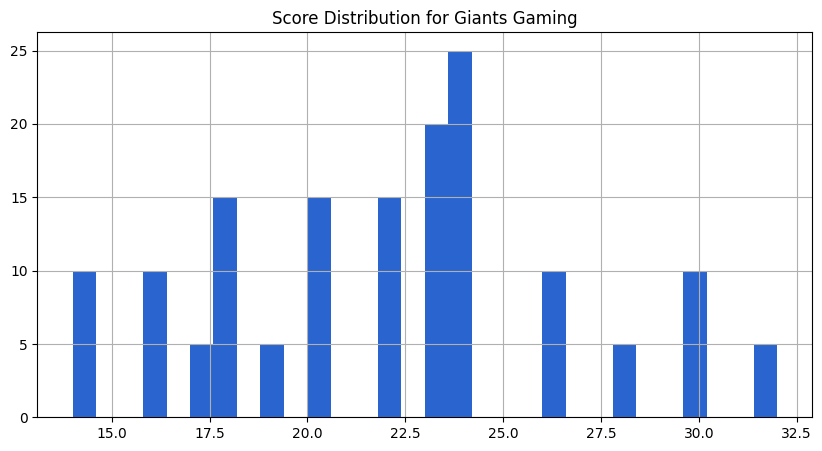

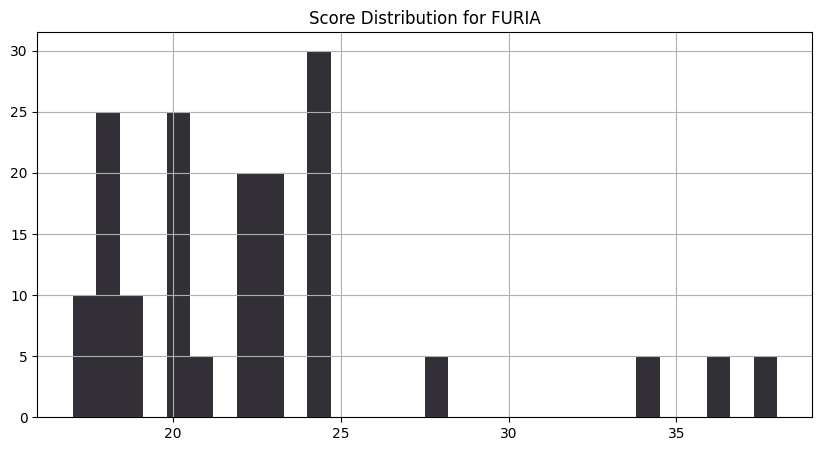

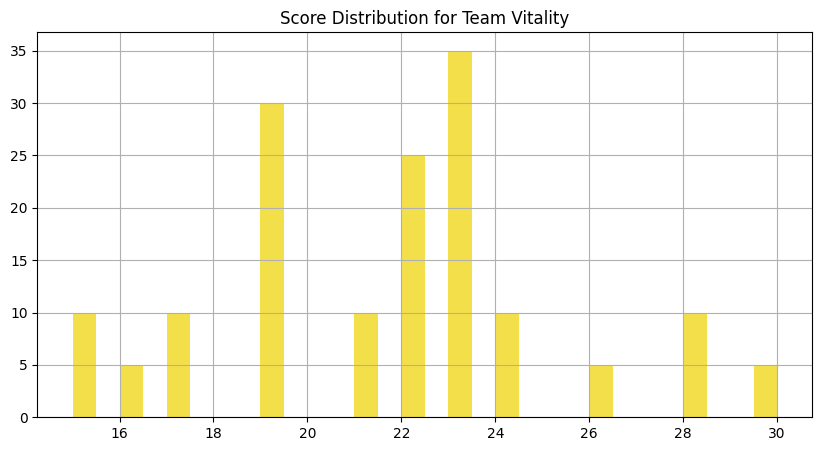

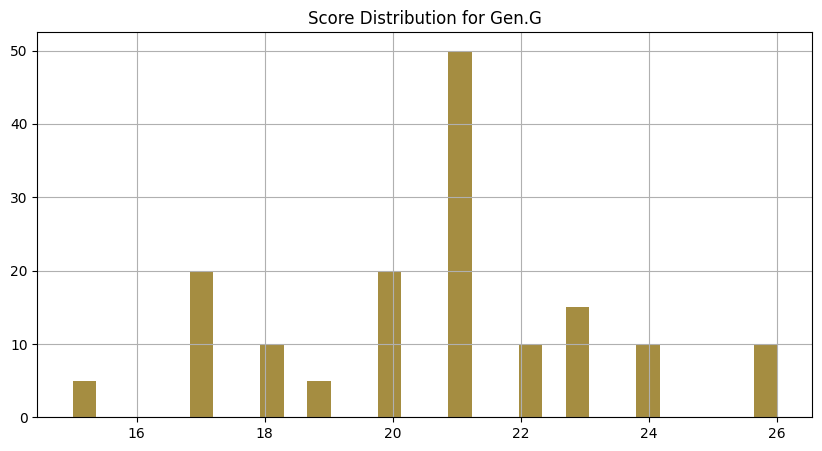

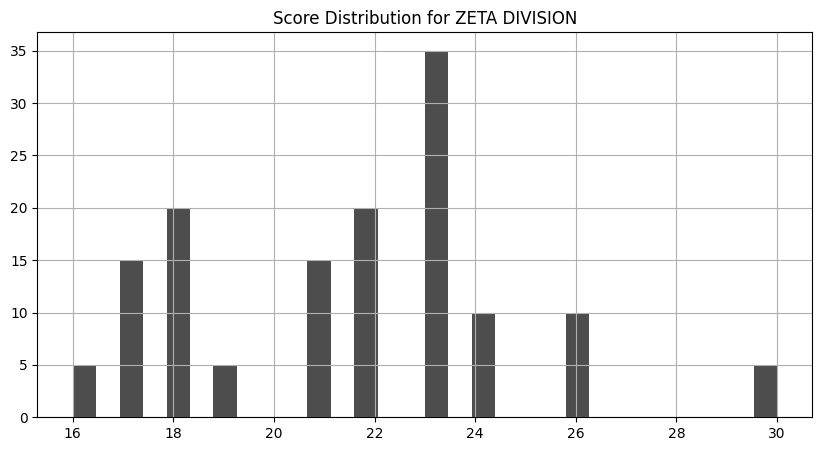

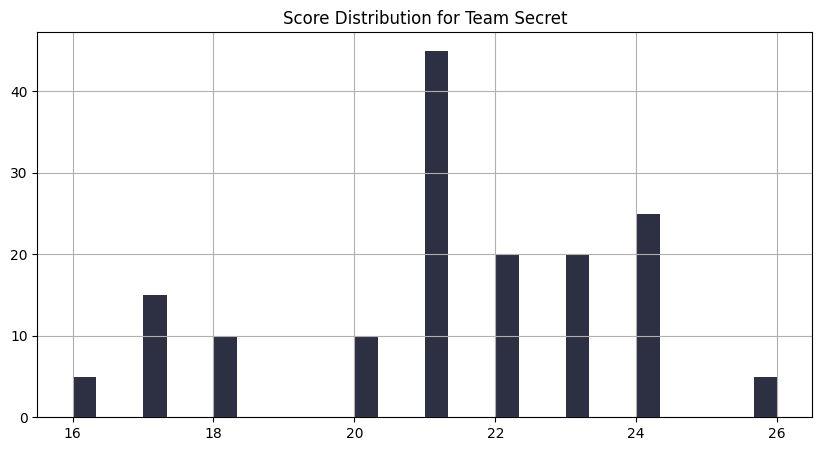

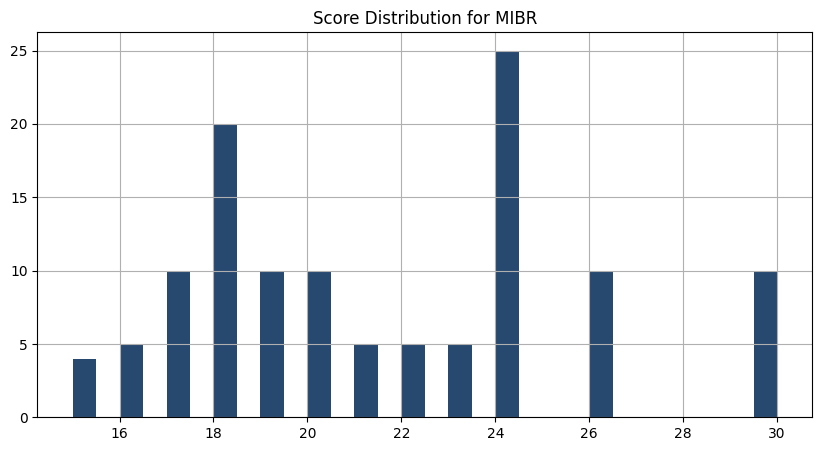

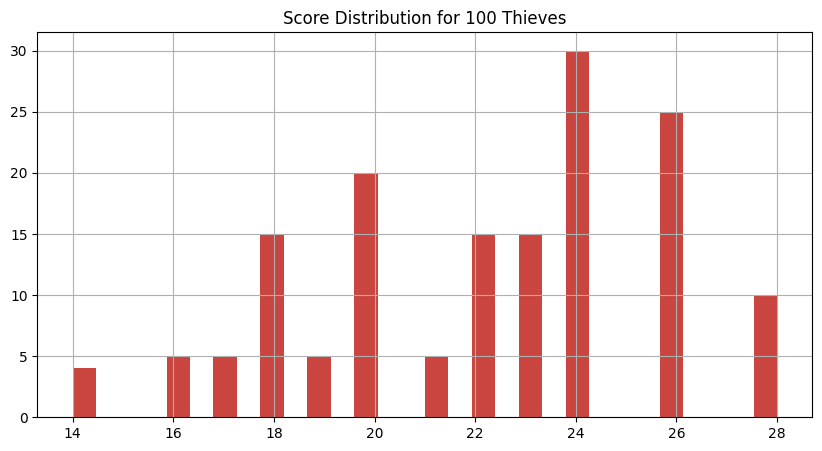

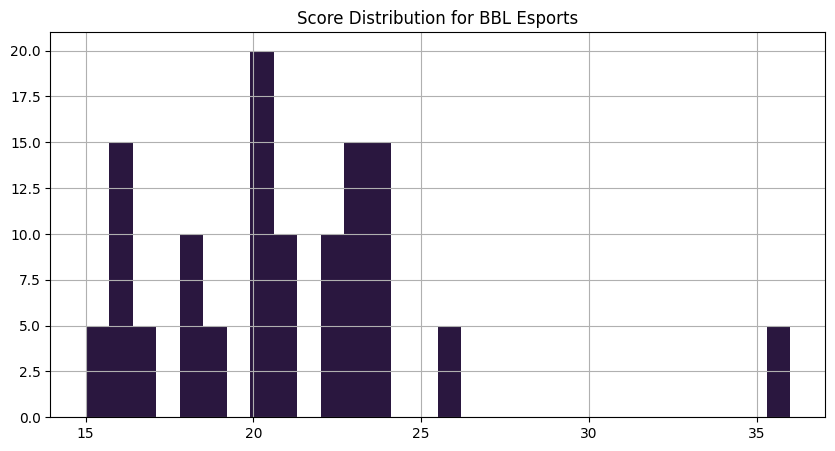

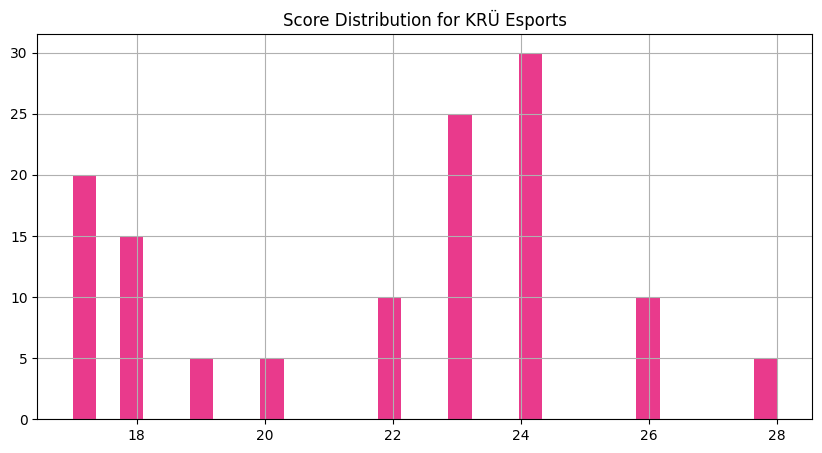

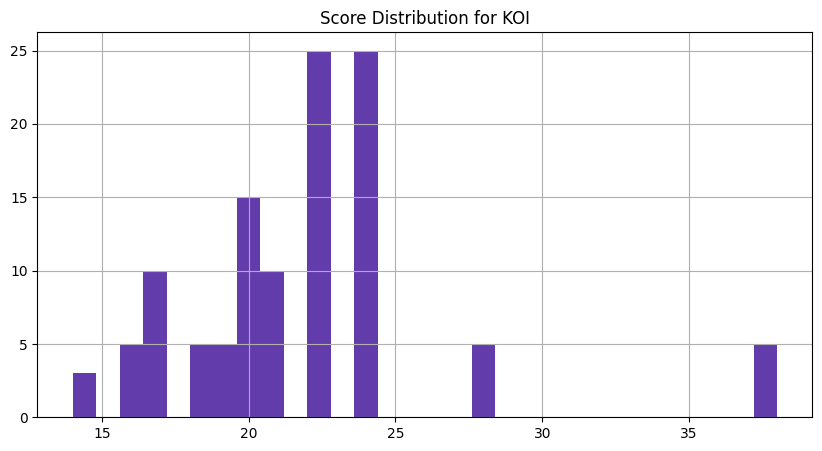

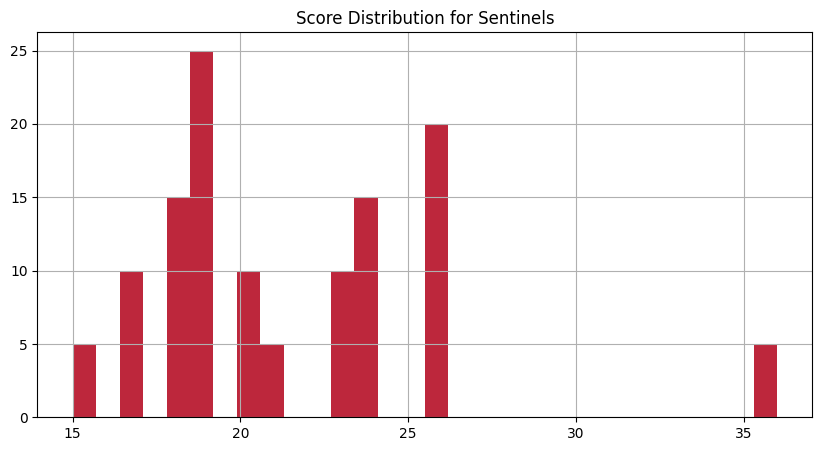

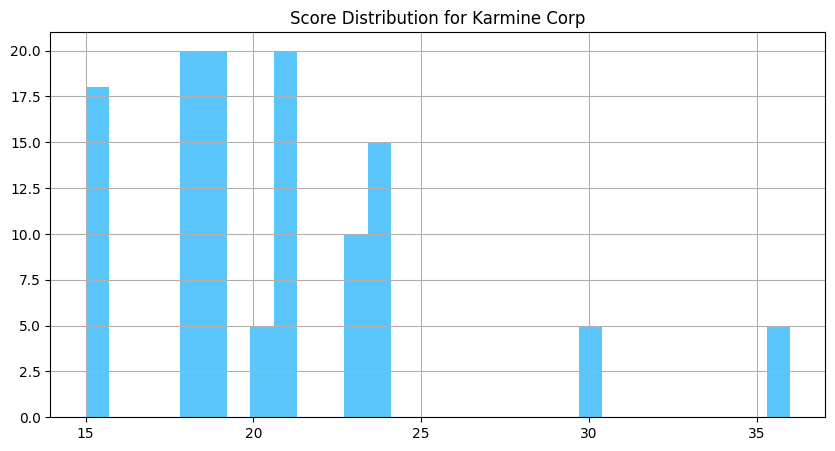

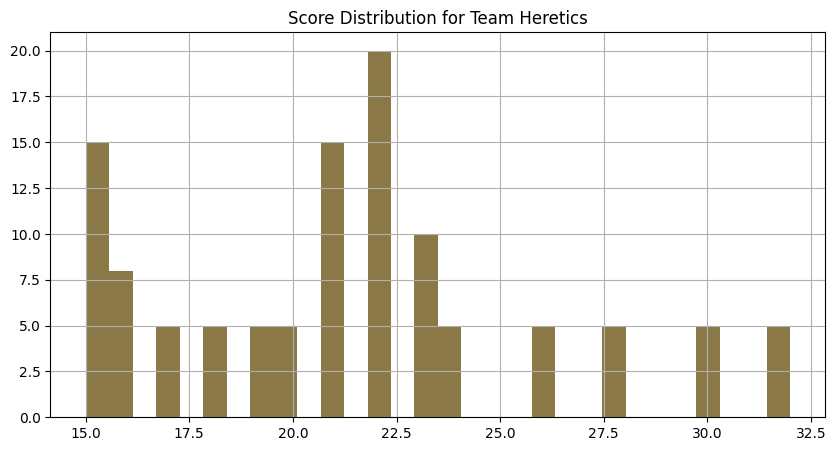

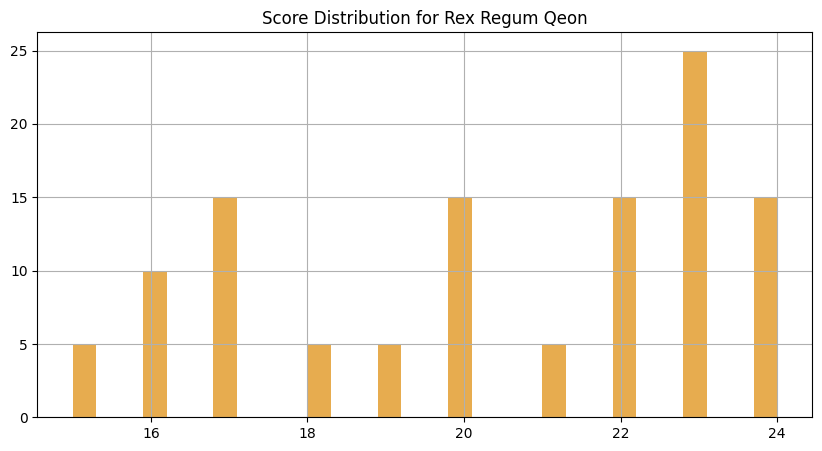

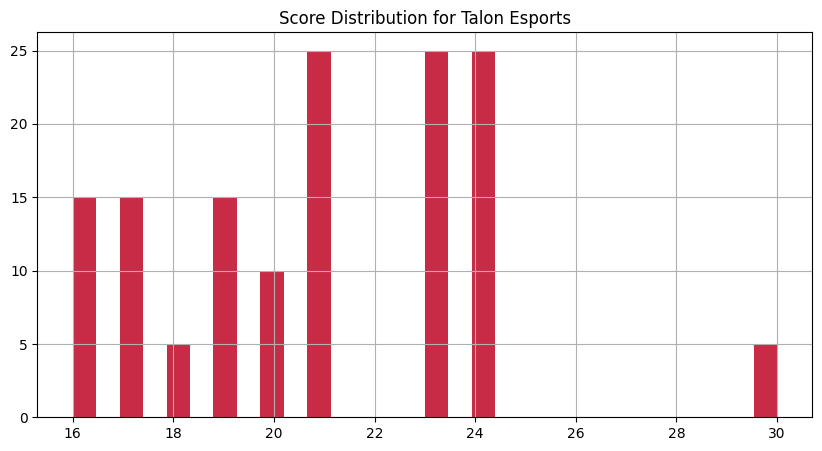

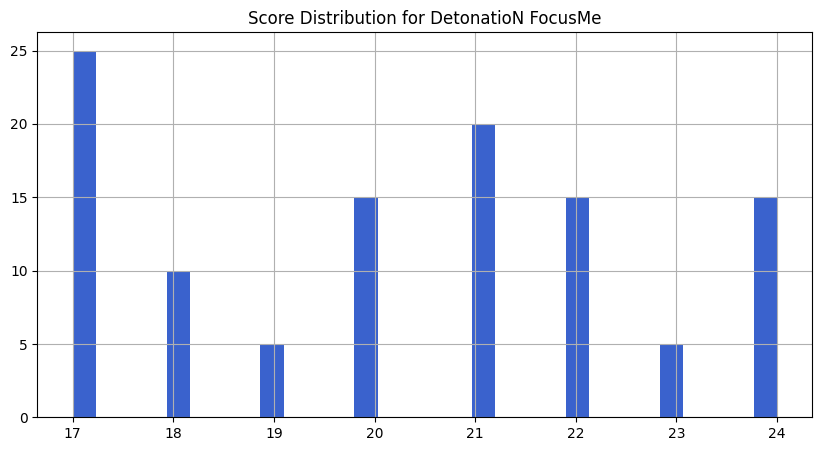

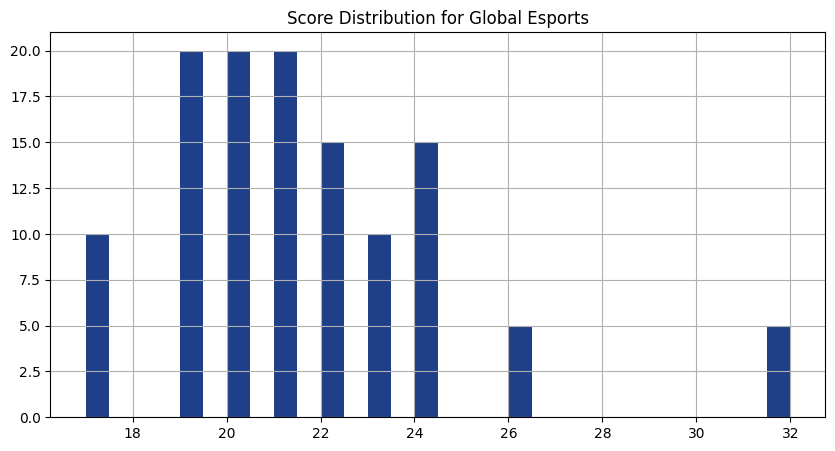

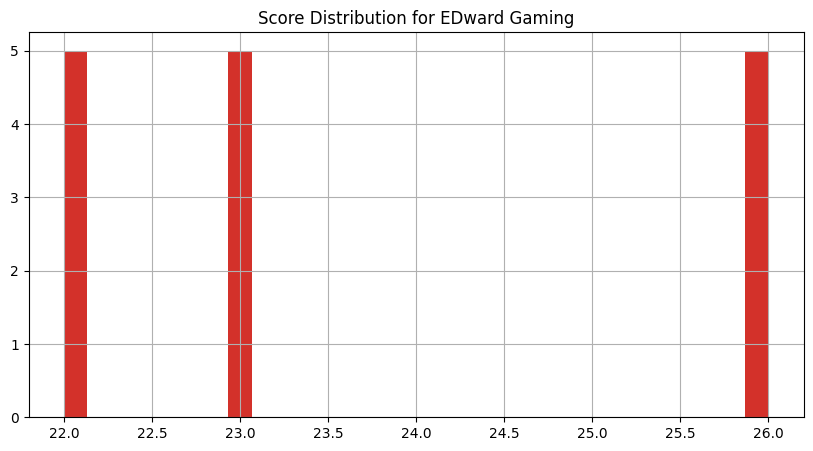

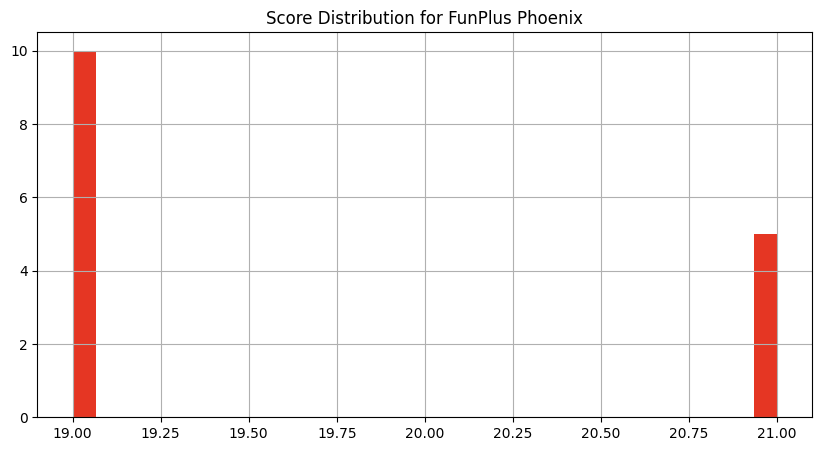

In [ ]:
for team, team_df in team_dfs.items():
    plt.figure(figsize=(10,5))

    # Specify the color palette
    sns.set_palette([team_colors[team]])

    team_df['rounds'].hist(bins=30)
    plt.title(f'Score Distribution for {team}')
    plt.show()

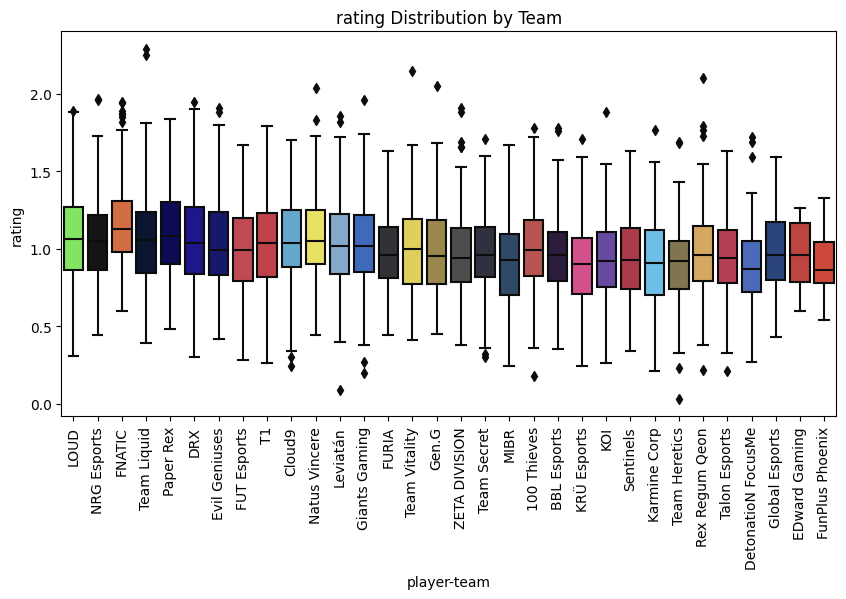

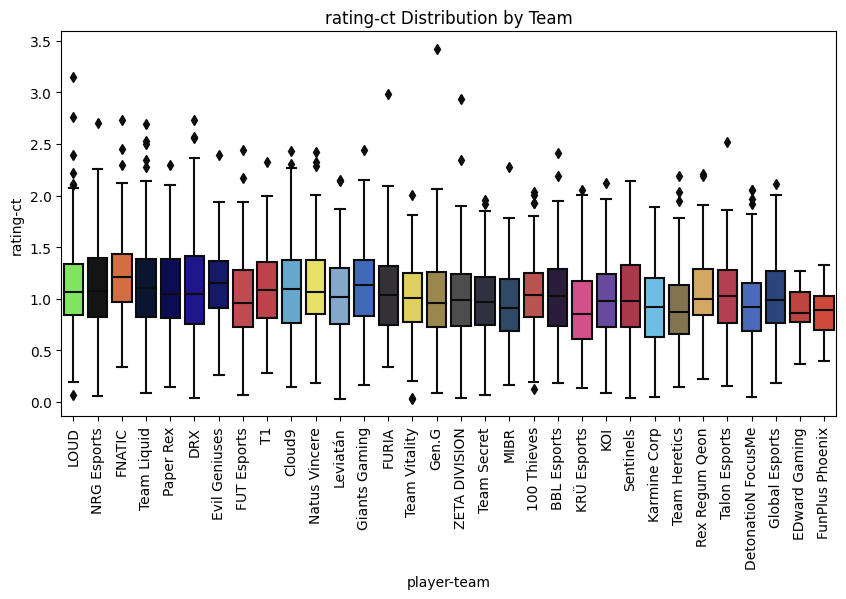

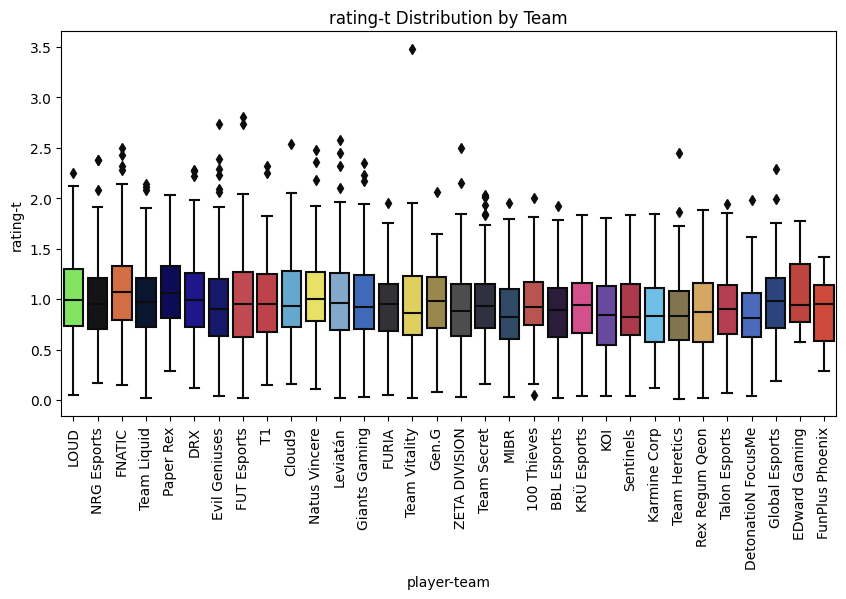

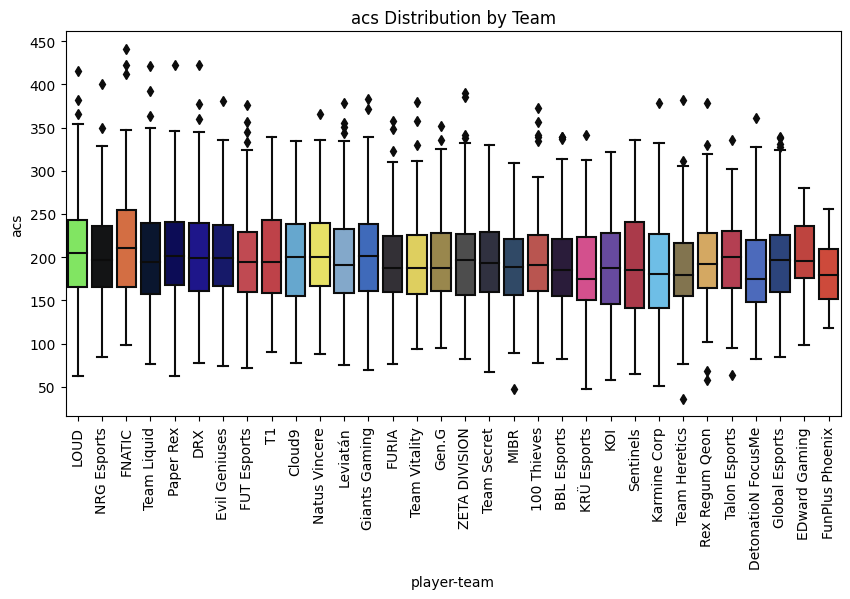

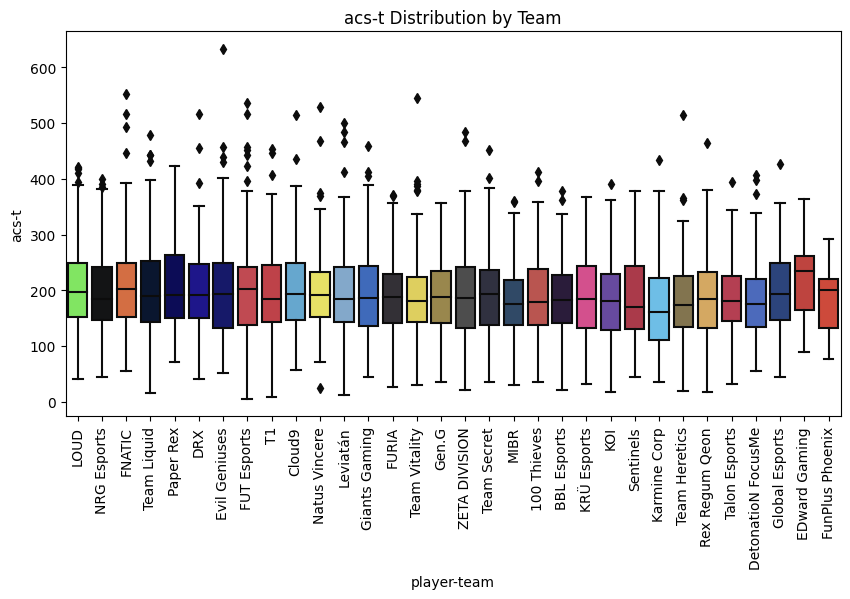

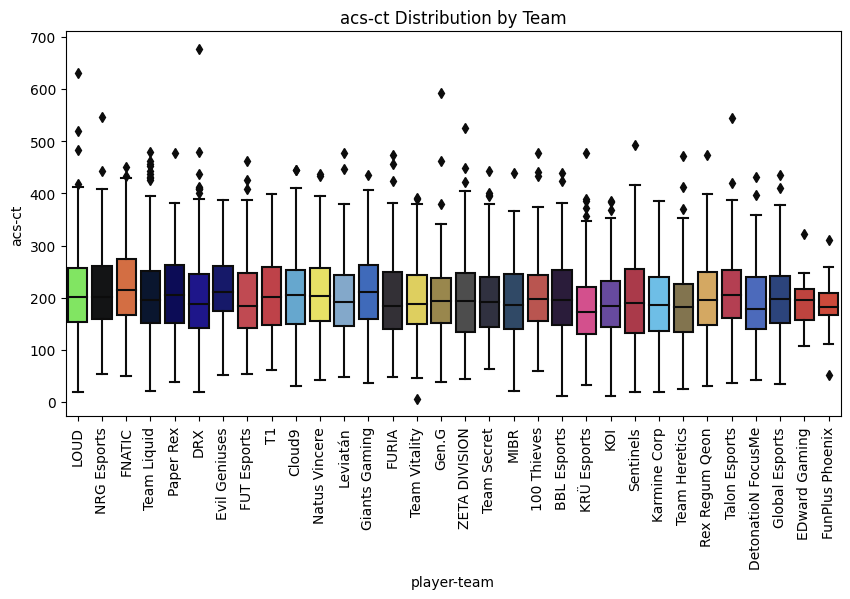

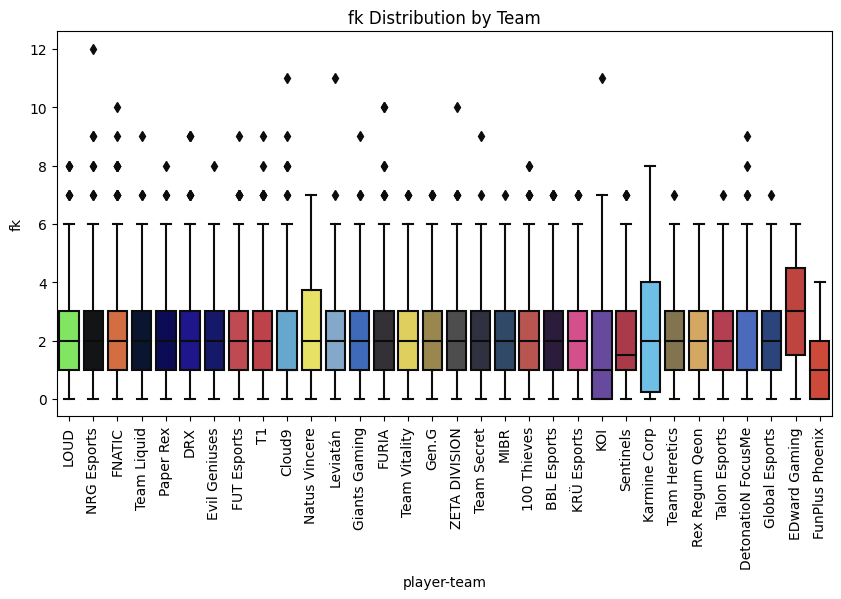

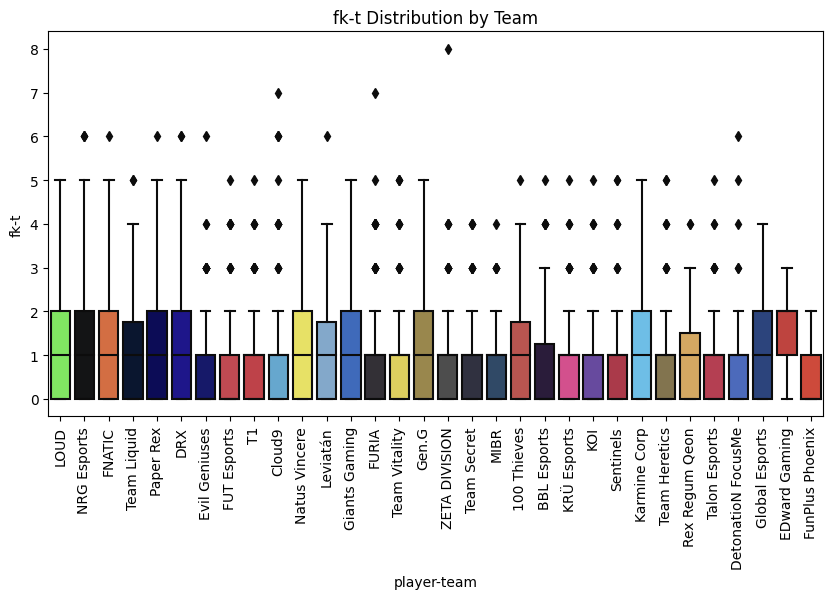

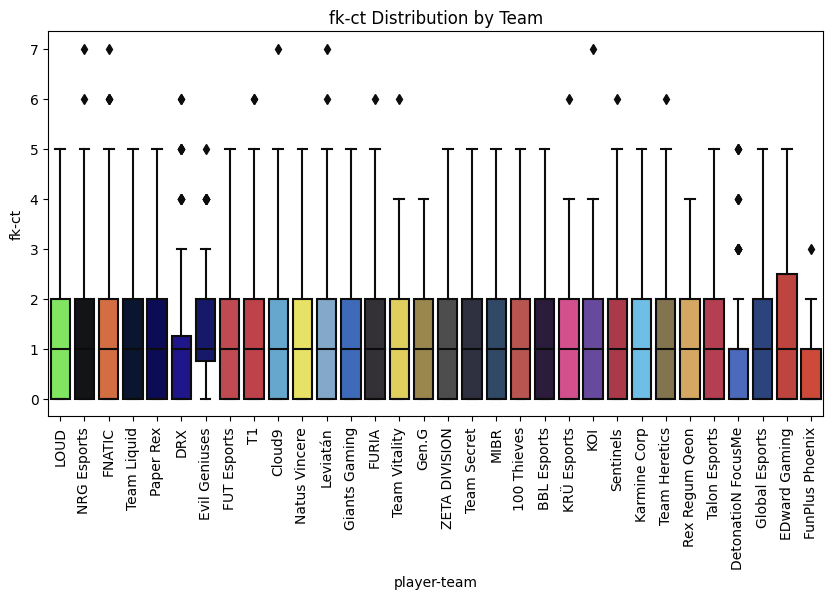

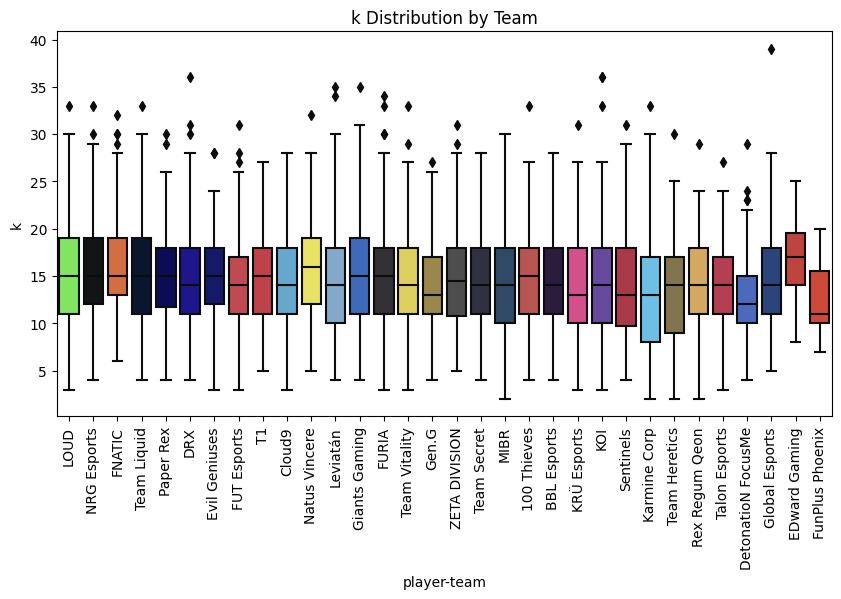

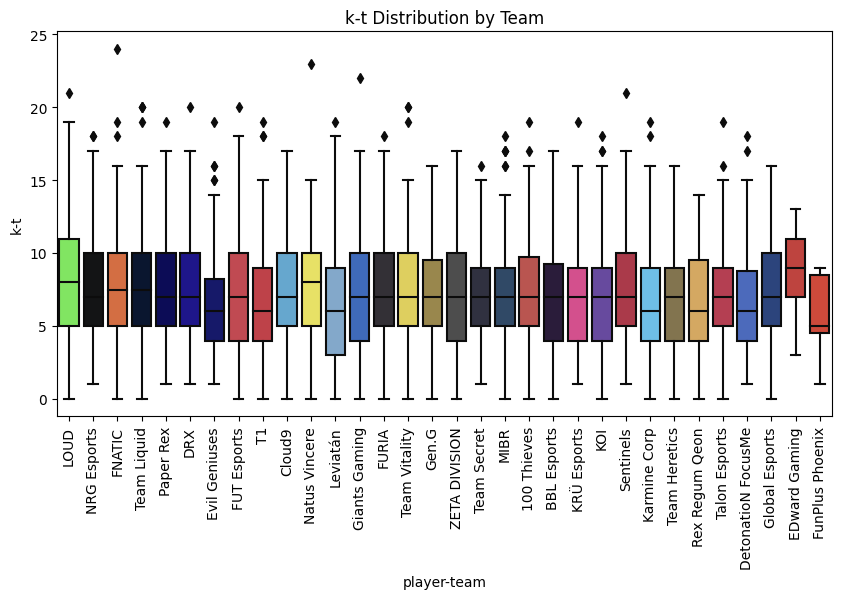

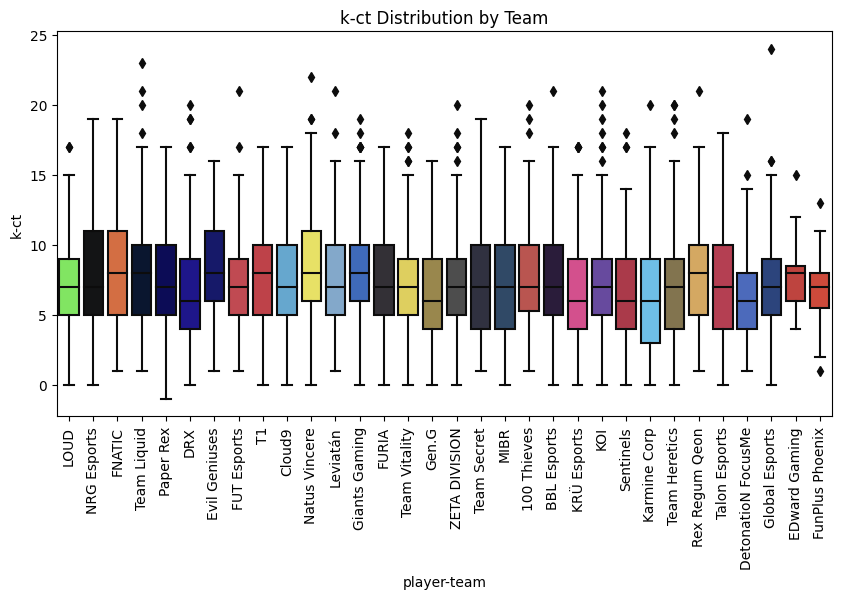

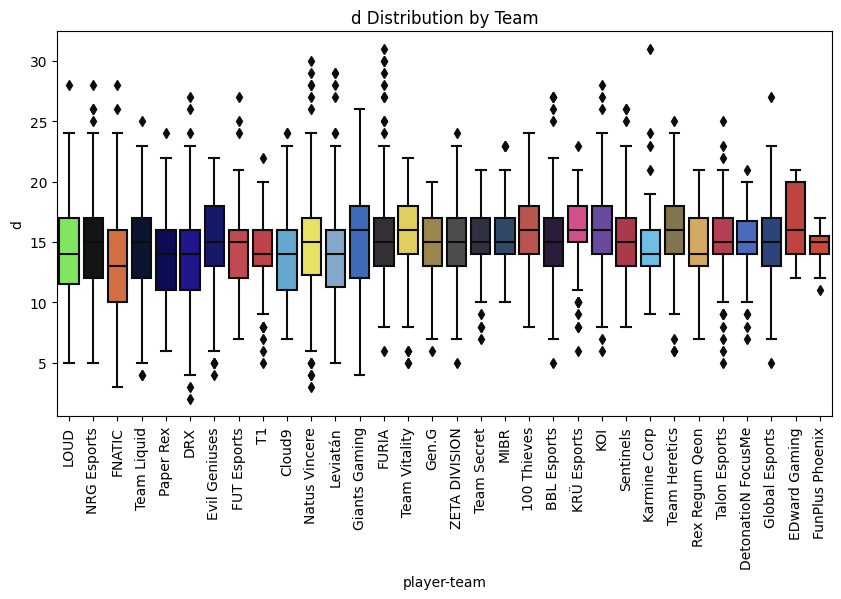

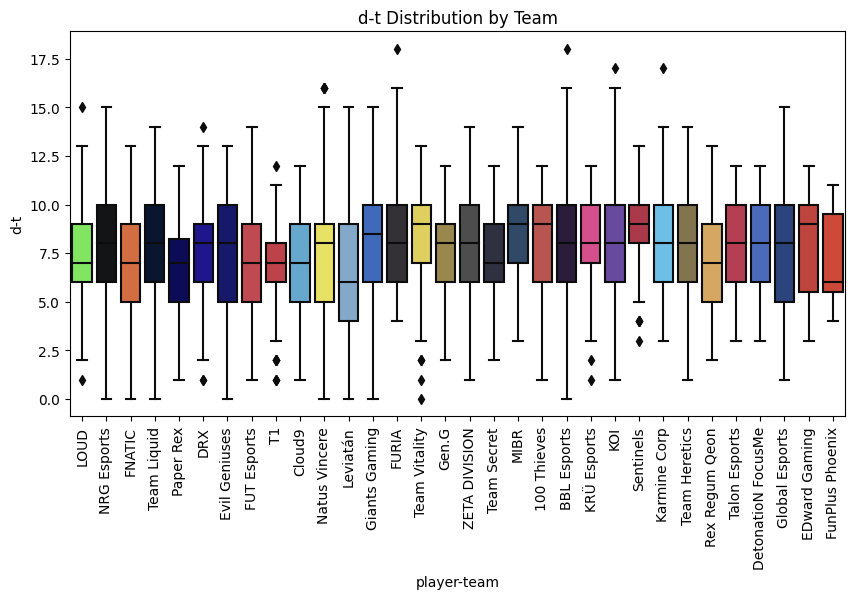

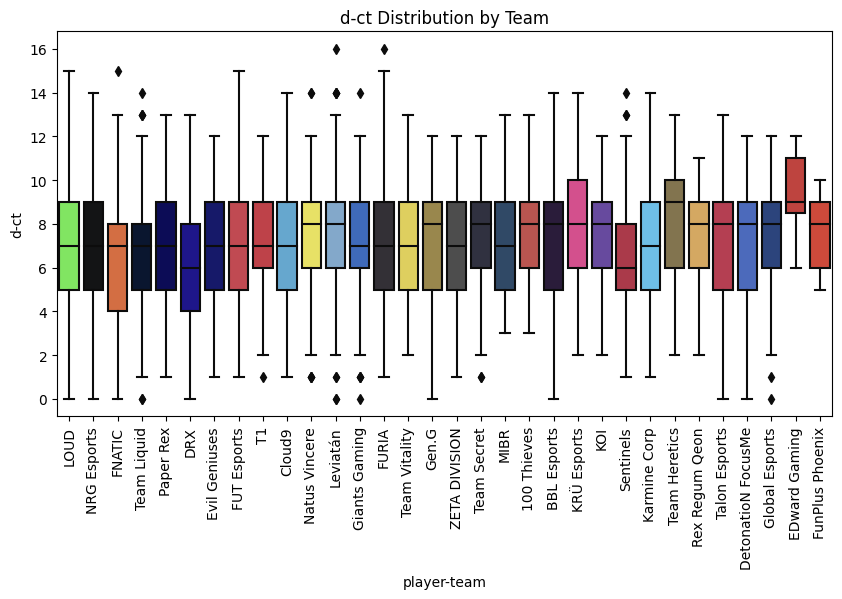

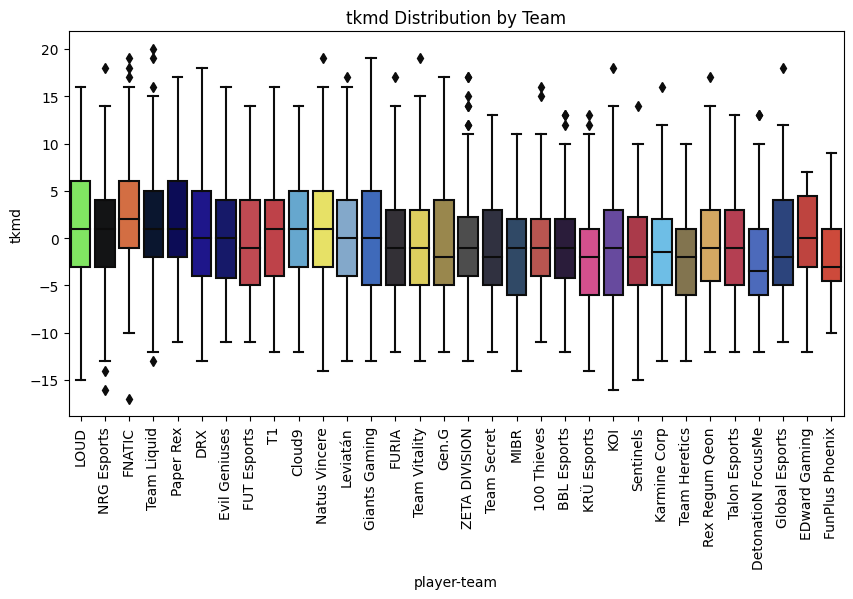

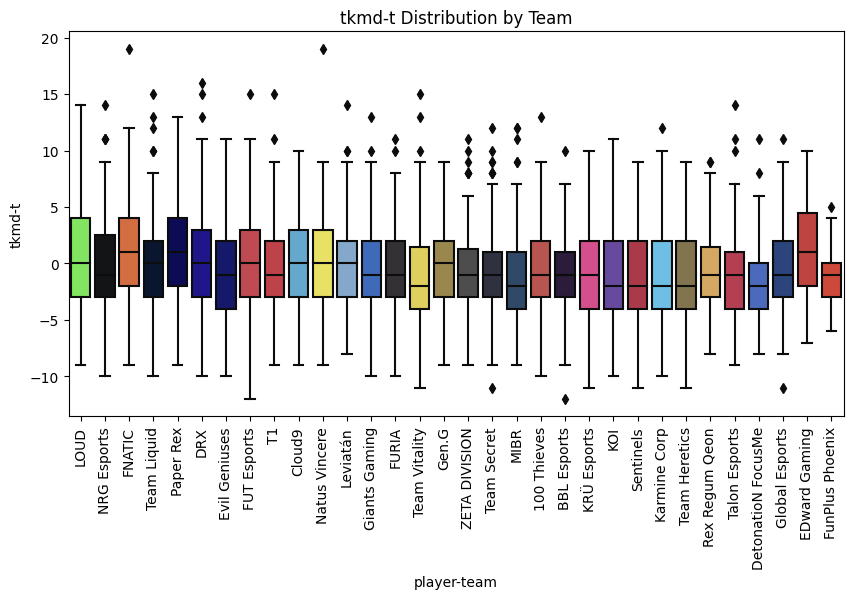

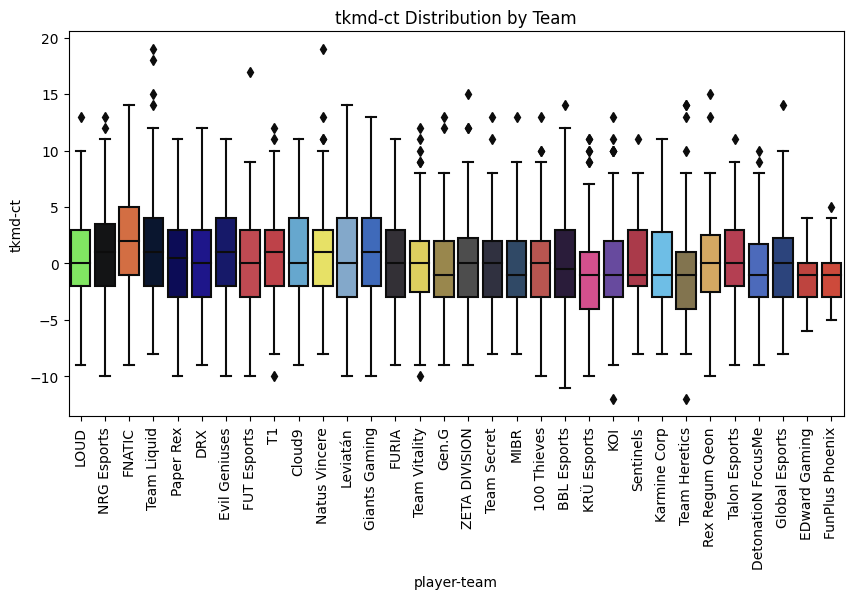

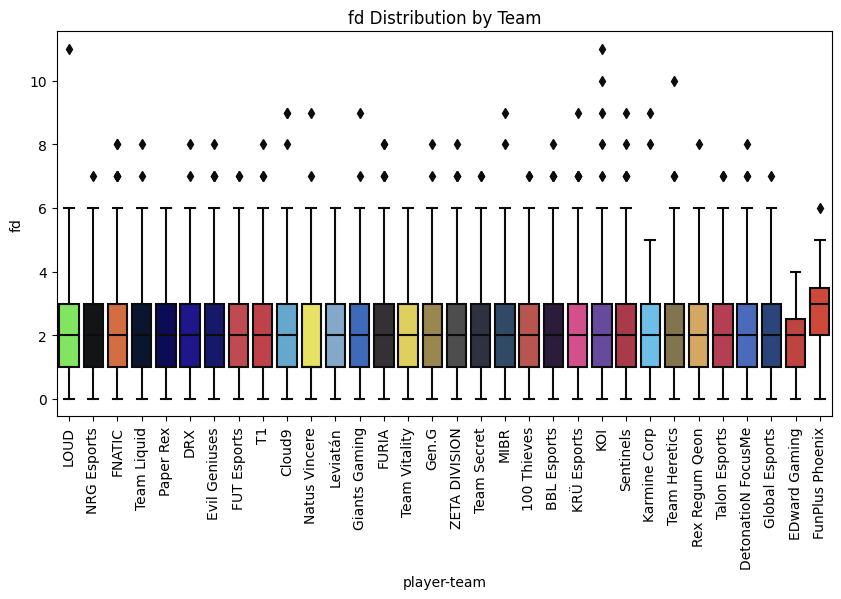

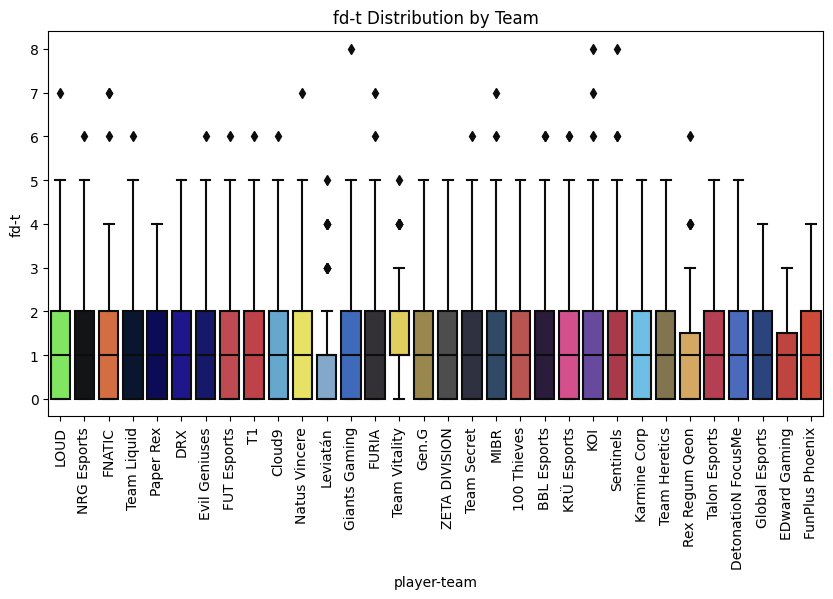

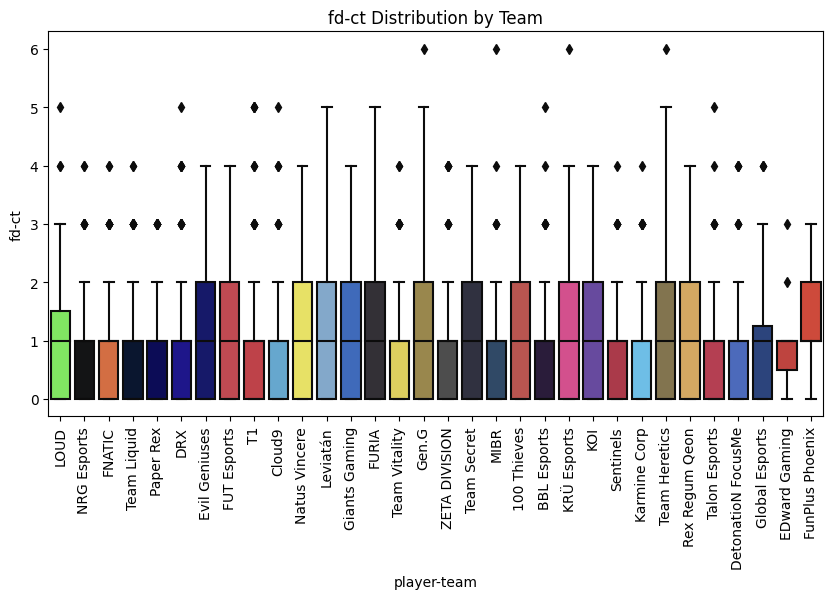

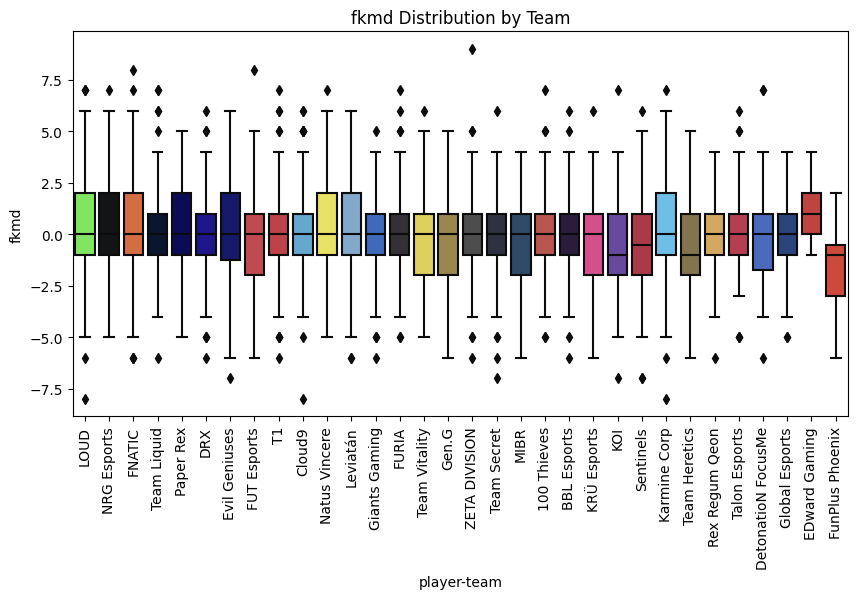

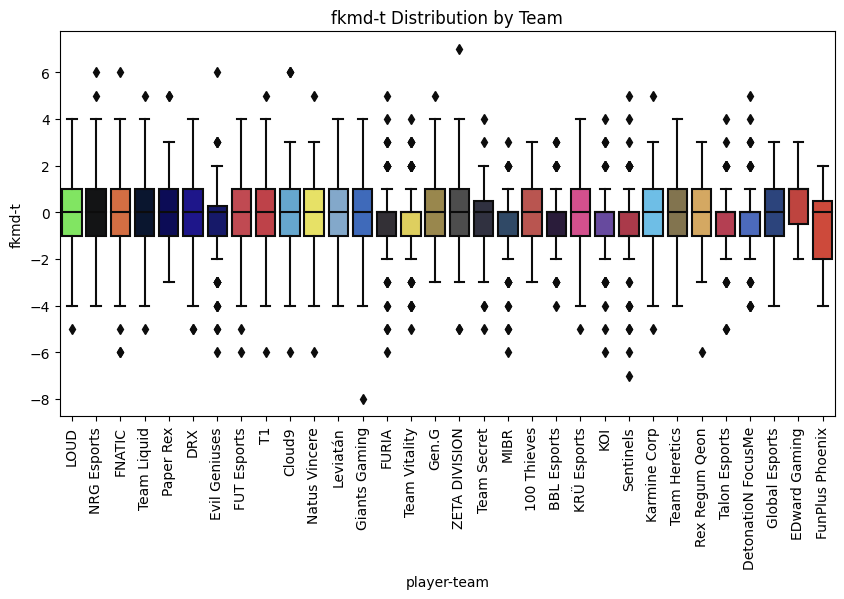

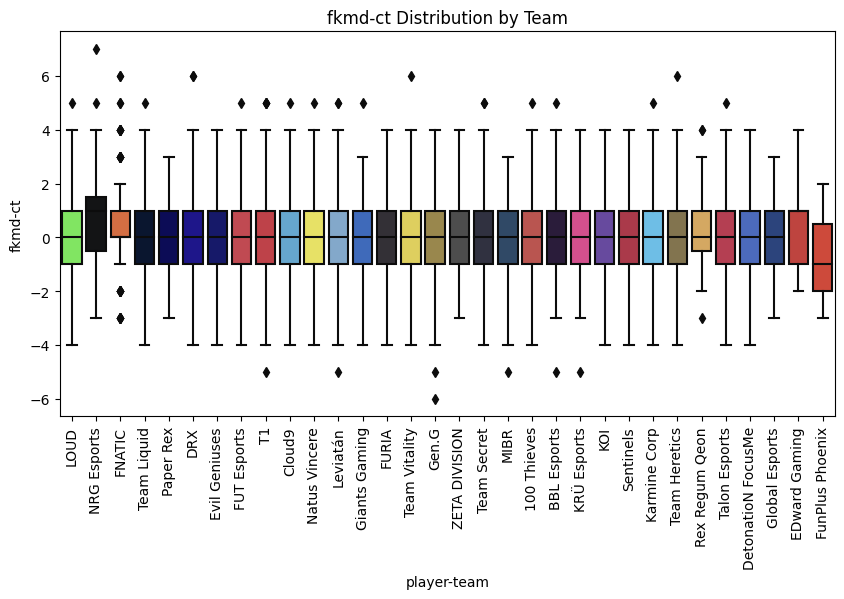

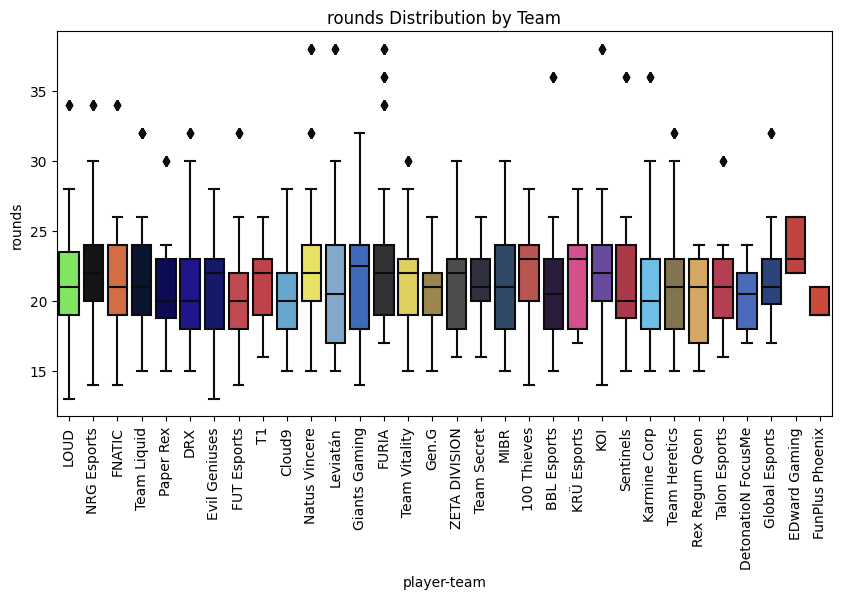

In [ ]:
for column in filtered_df.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(10,5))
    sns.boxplot(x='player-team', y=column, data=filtered_df, palette=team_colors)
    plt.title(f'{column} Distribution by Team')

    # Rotate x-axis labels
    plt.xticks(rotation=90)

    plt.show()


In [ ]:
for team, team_df in team_dfs.items():
    print(f"Correlation matrix for {team}:")
    print(team_df.corr())


Correlation matrix for LOUD:
             rating  rating-ct  rating-t       acs     acs-t    acs-ct  \
rating     1.000000   0.662691  0.798802  0.843276  0.693307  0.540850   
rating-ct  0.662691   1.000000  0.162409  0.609894  0.179784  0.839915   
rating-t   0.798802   0.162409  1.000000  0.648291  0.842709  0.105694   
acs        0.843276   0.609894  0.648291  1.000000  0.797310  0.675443   
acs-t      0.693307   0.179784  0.842709  0.797310  1.000000  0.167728   
acs-ct     0.540850   0.839915  0.105694  0.675443  0.167728  1.000000   
fk         0.390538   0.302590  0.279240  0.492901  0.360976  0.344397   
fk-t       0.366687   0.169740  0.371543  0.443260  0.434376  0.184619   
fk-ct      0.243767   0.306258  0.062054  0.327714  0.127351  0.357373   
k          0.719829   0.472023  0.575643  0.837523  0.686150  0.532110   
k-t        0.690412   0.196768  0.803923  0.703203  0.852569  0.157896   
k-ct       0.340097   0.508342 -0.008716  0.507278  0.107419  0.644306   
d        

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/4291807688.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(team_df.corr())
/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/4291807688.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(team_df.corr())
/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/4291807688.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(team_df.corr())
/var/folders/d8/qgb_8zcs7vl6pjz

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


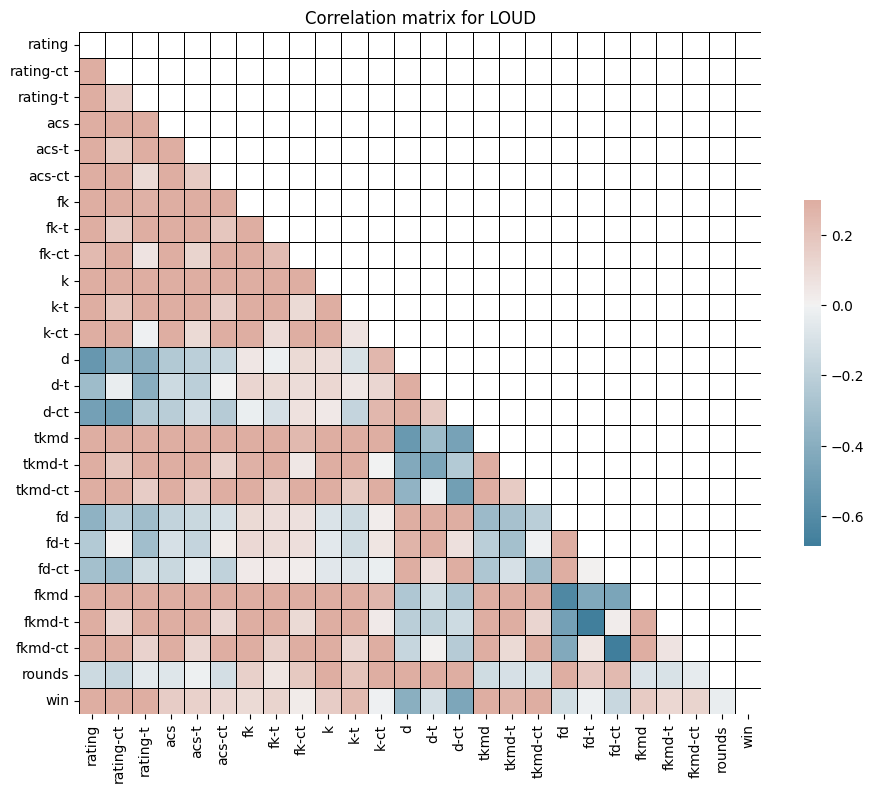

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


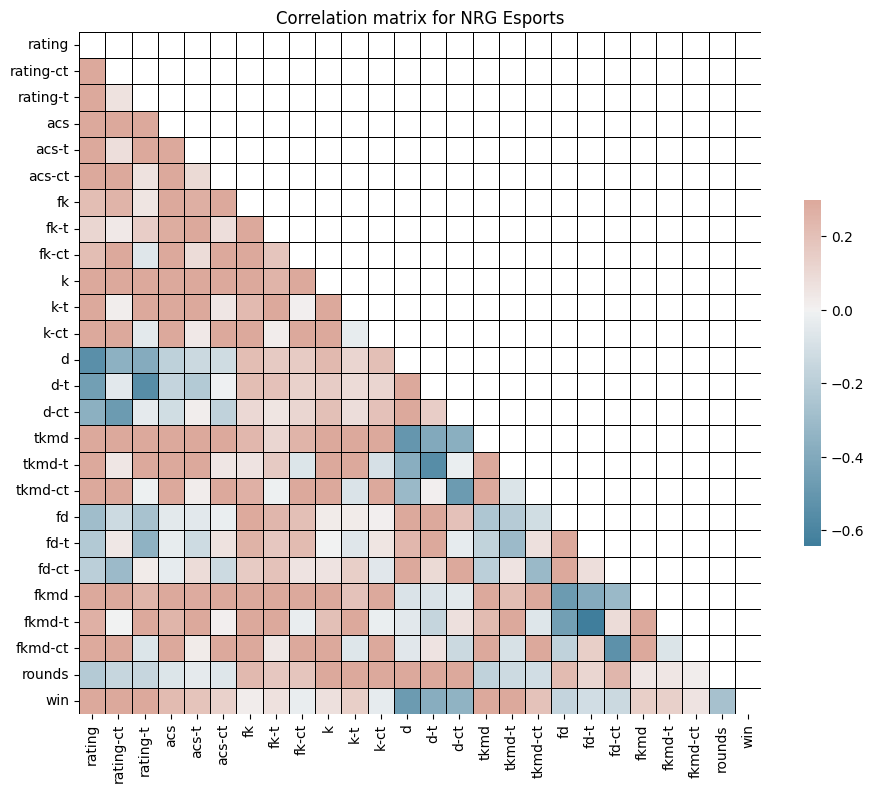

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


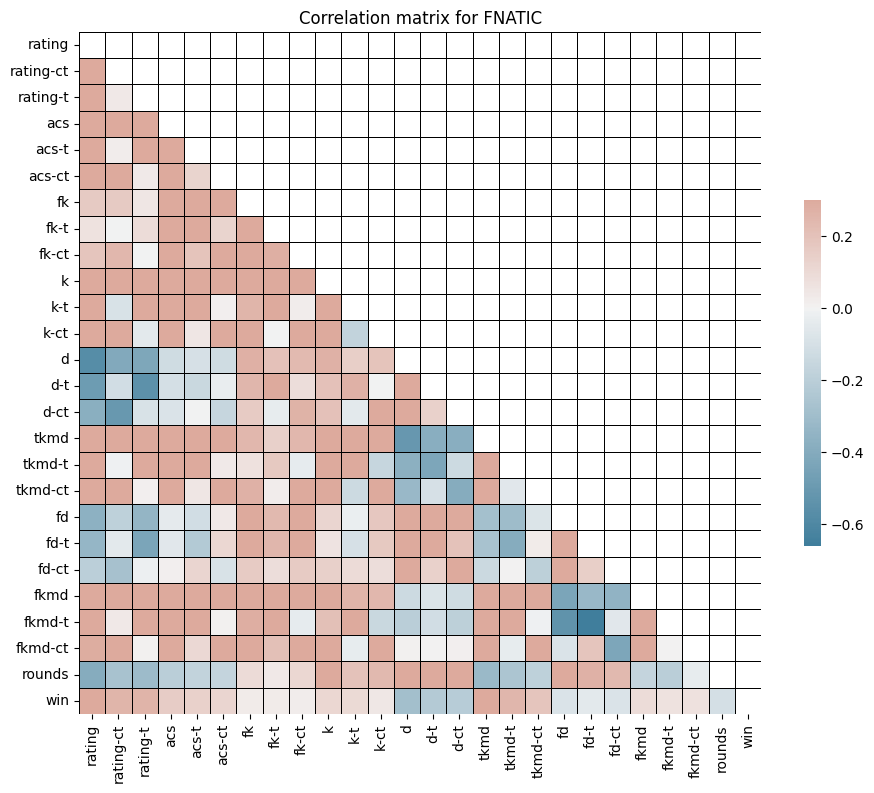

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


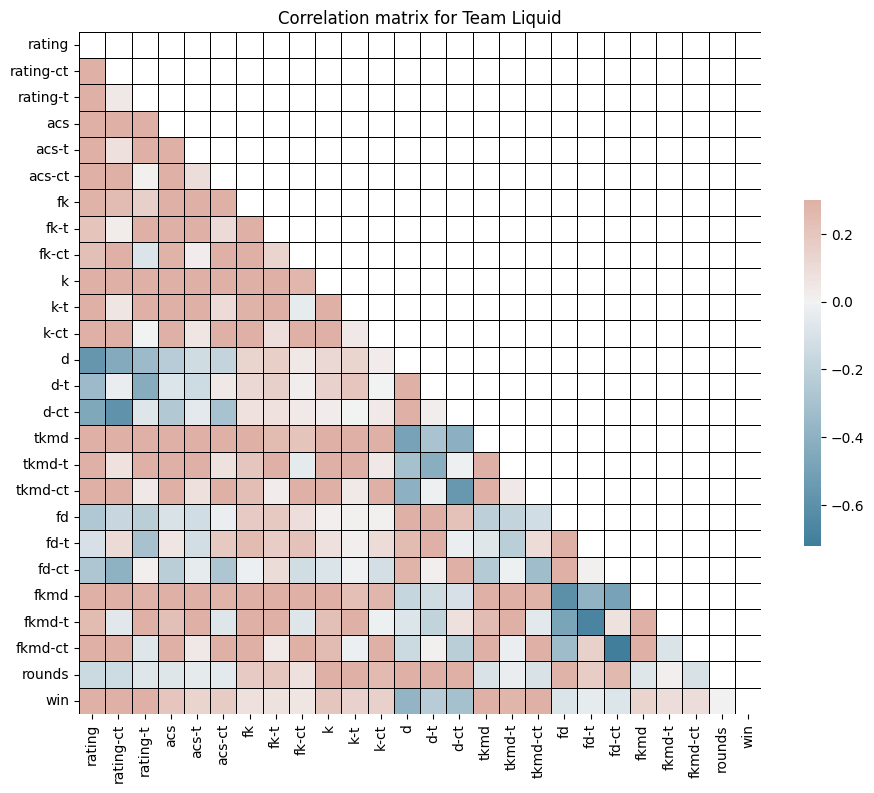

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


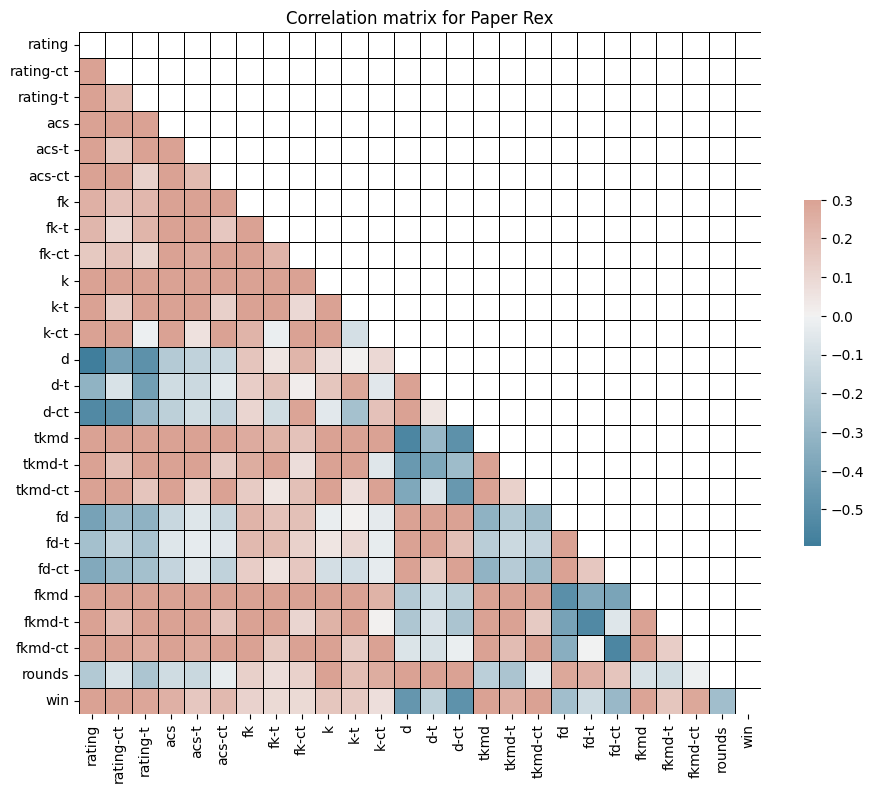

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


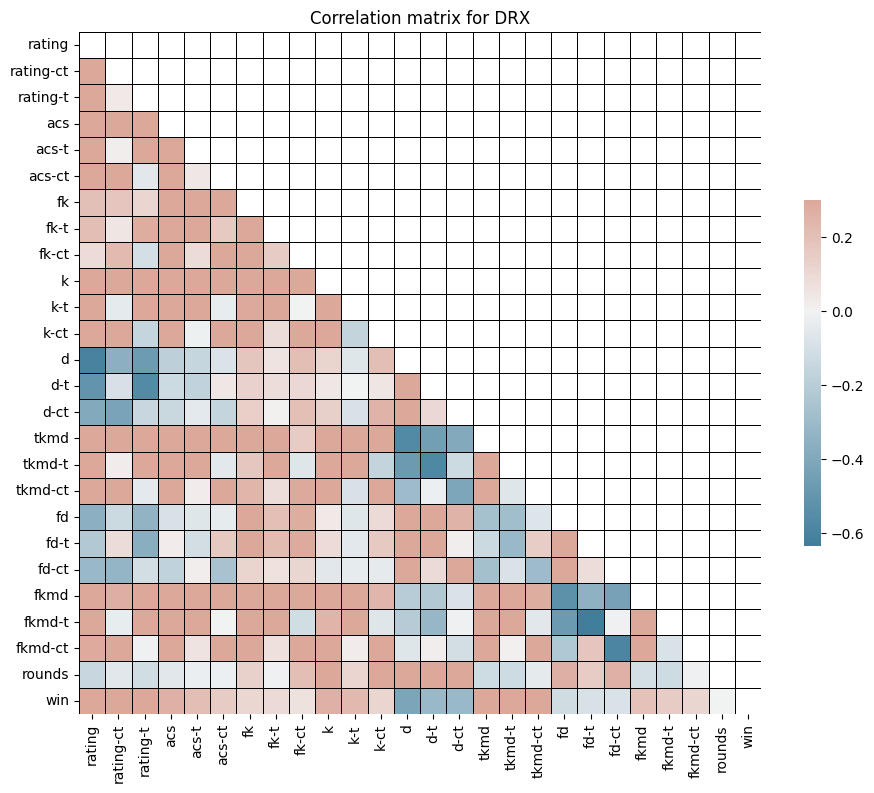

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


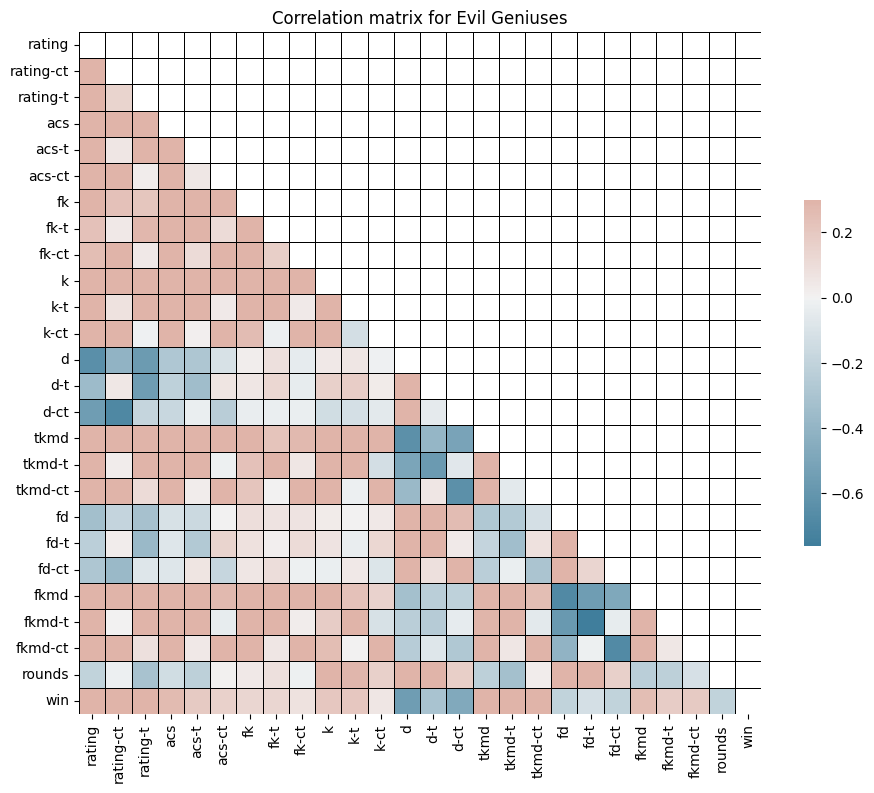

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


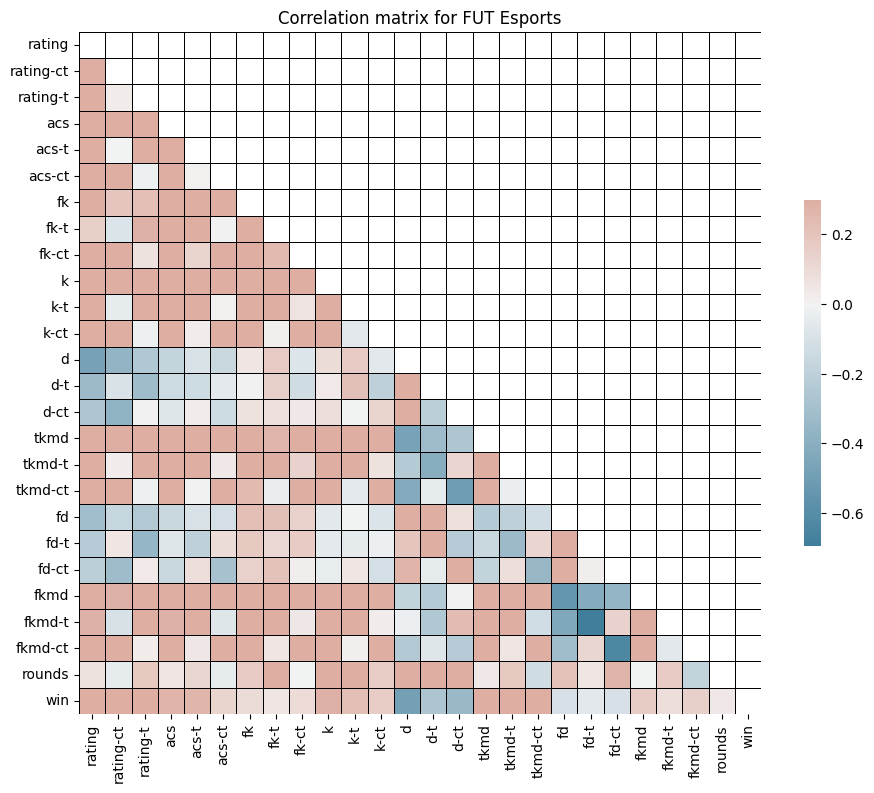

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


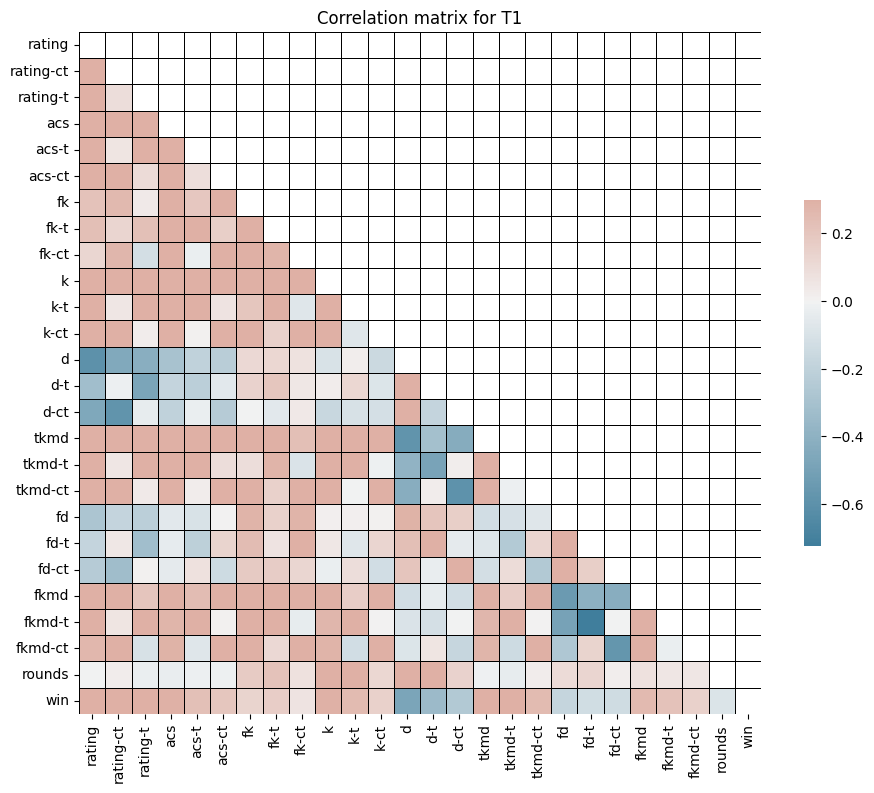

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


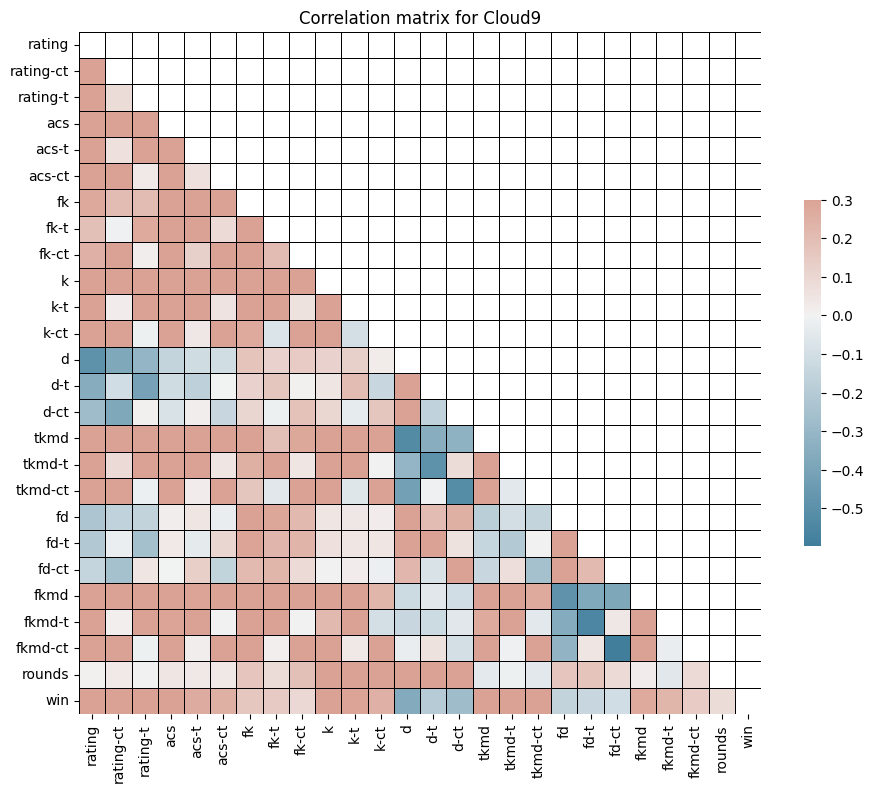

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


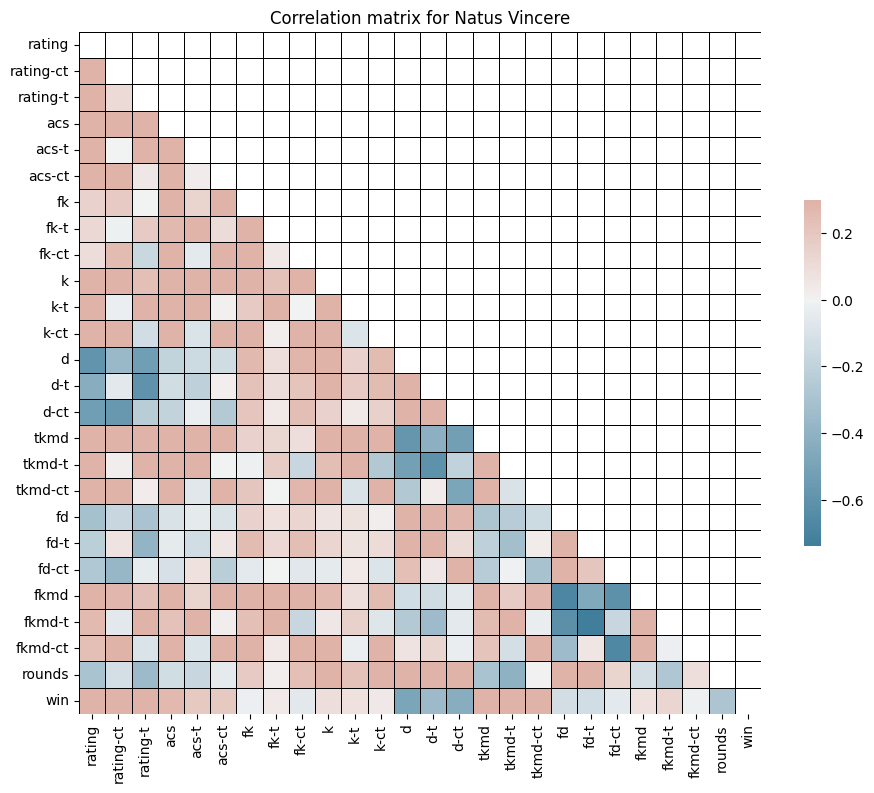

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


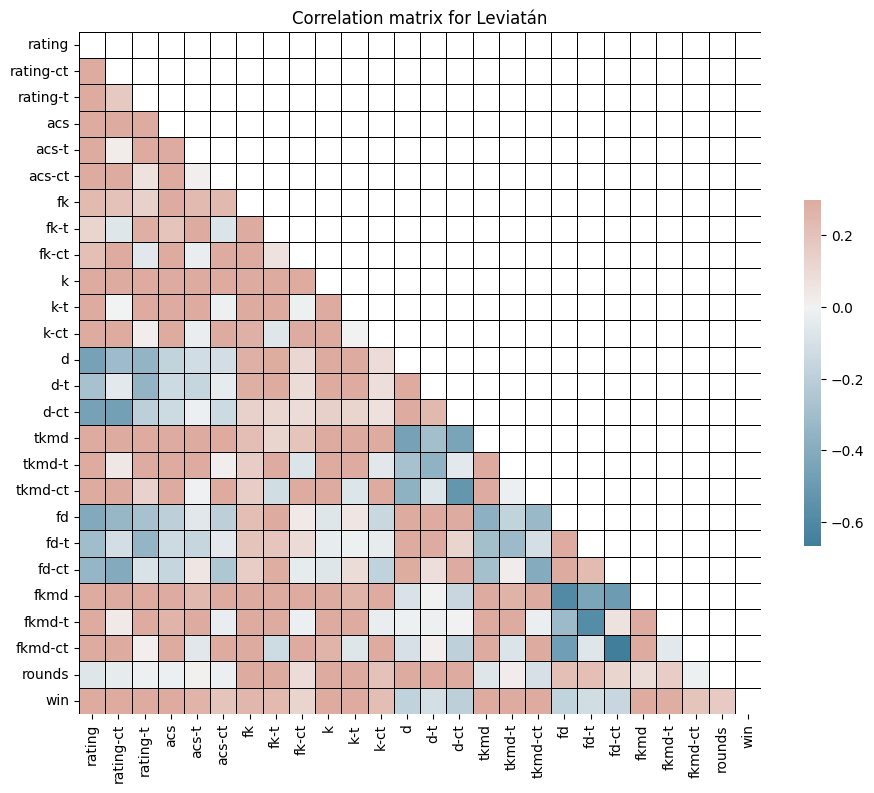

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


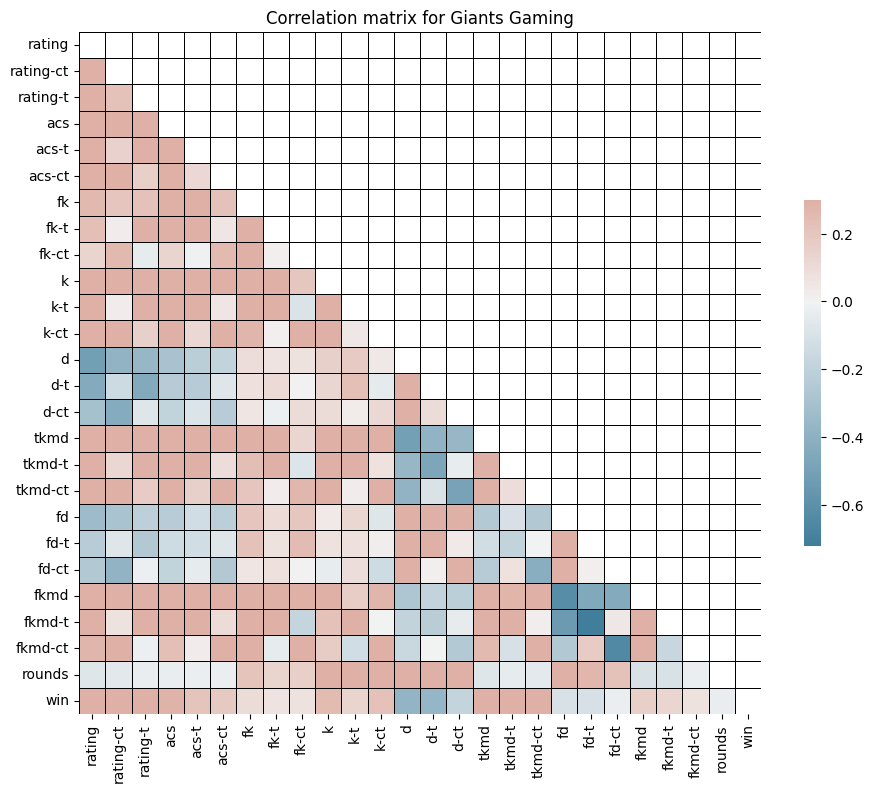

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


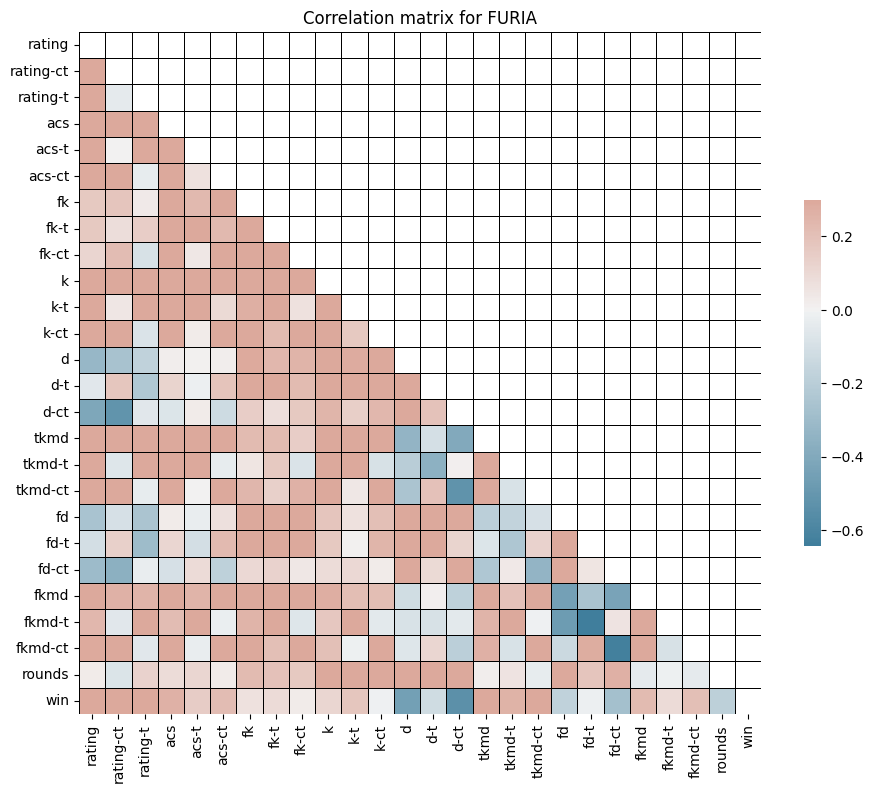

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


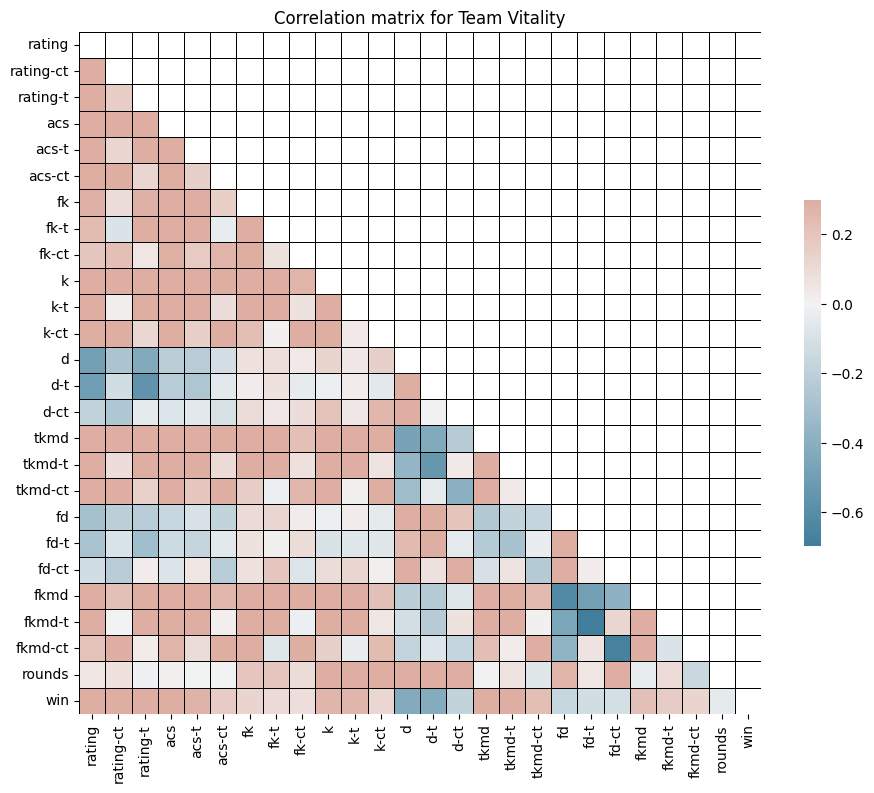

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


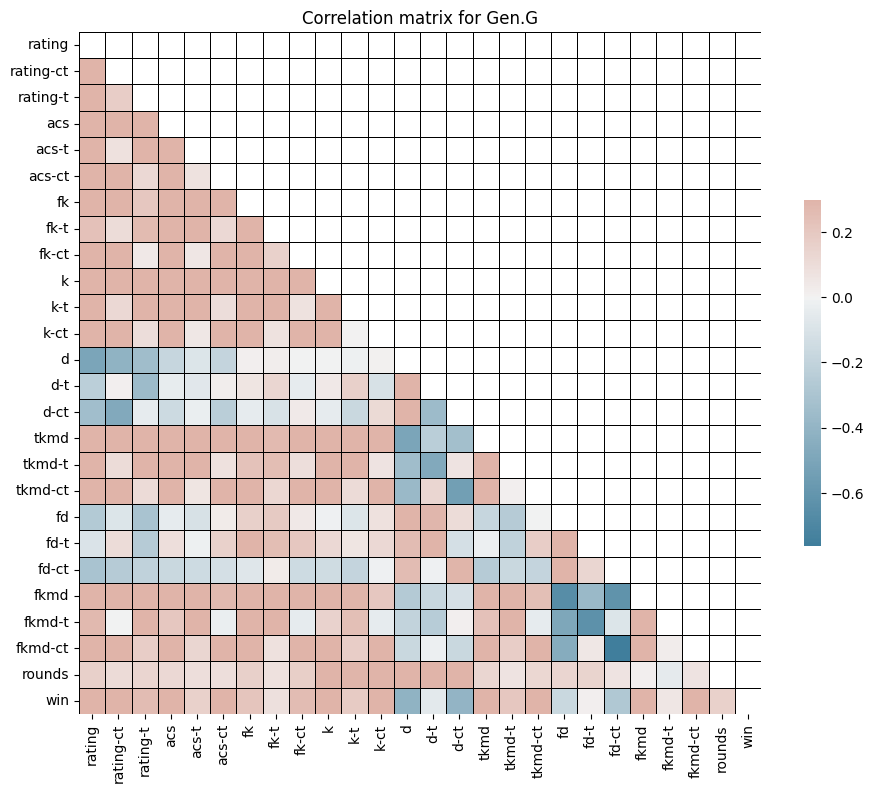

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


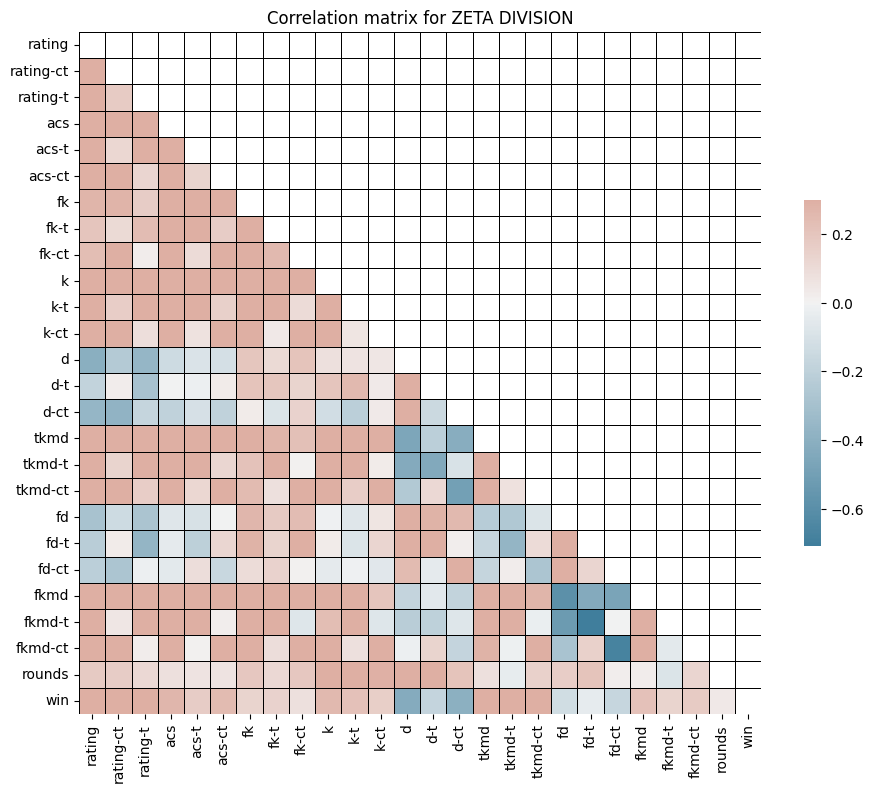

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


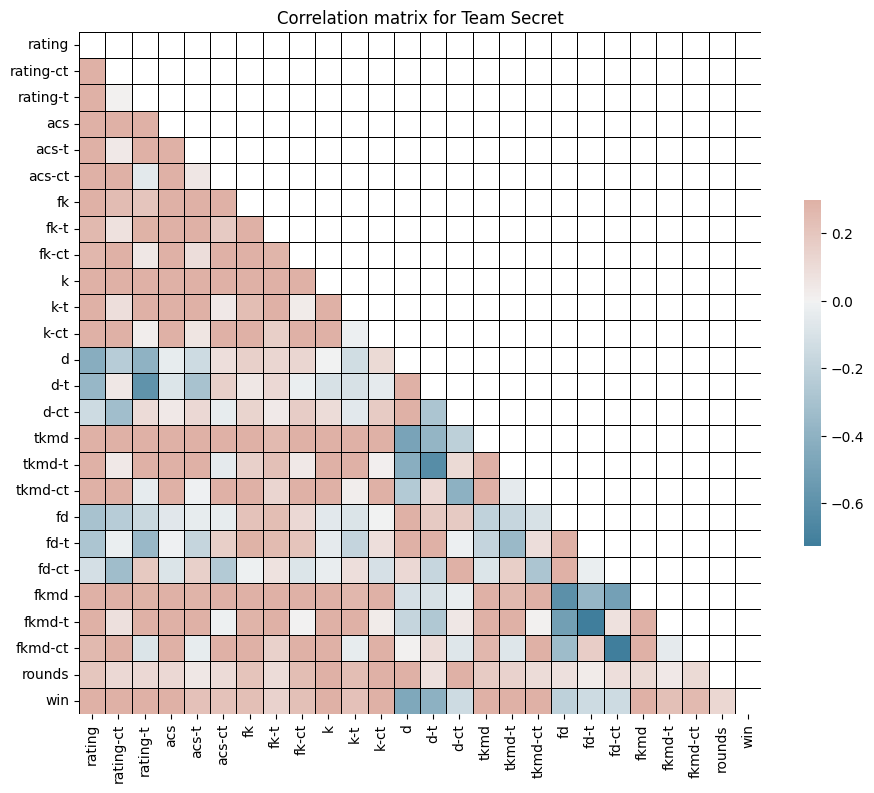

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


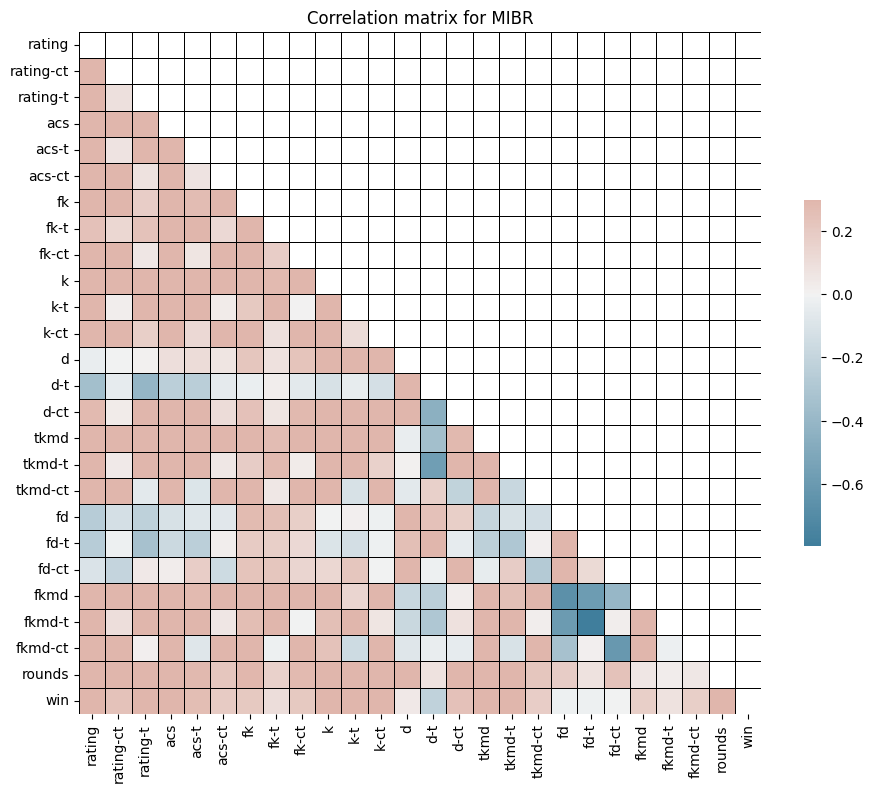

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


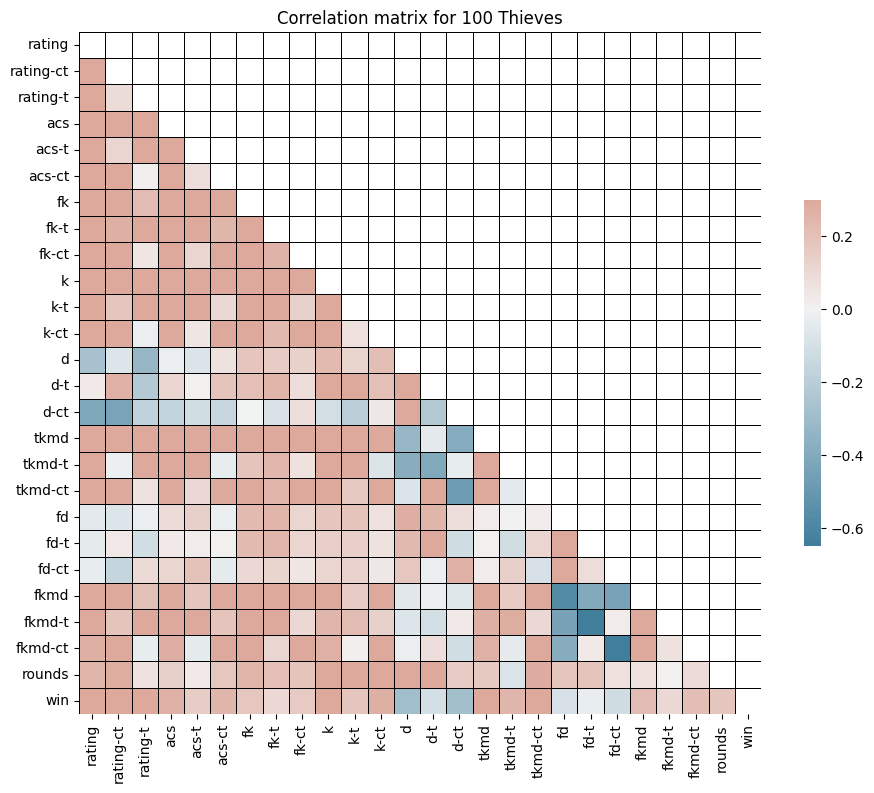

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


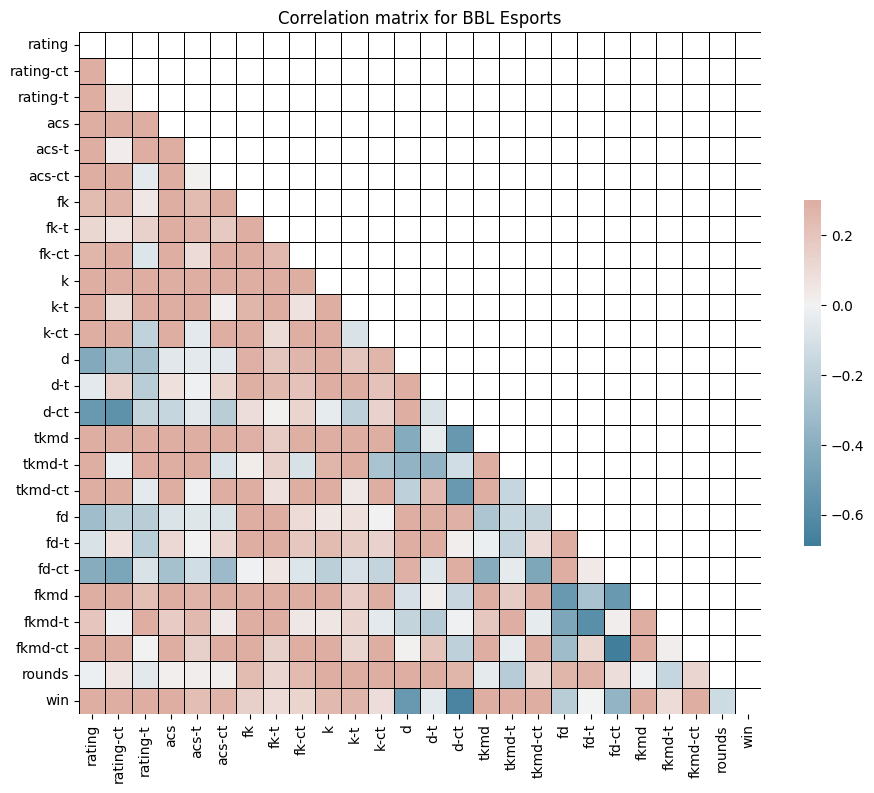

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


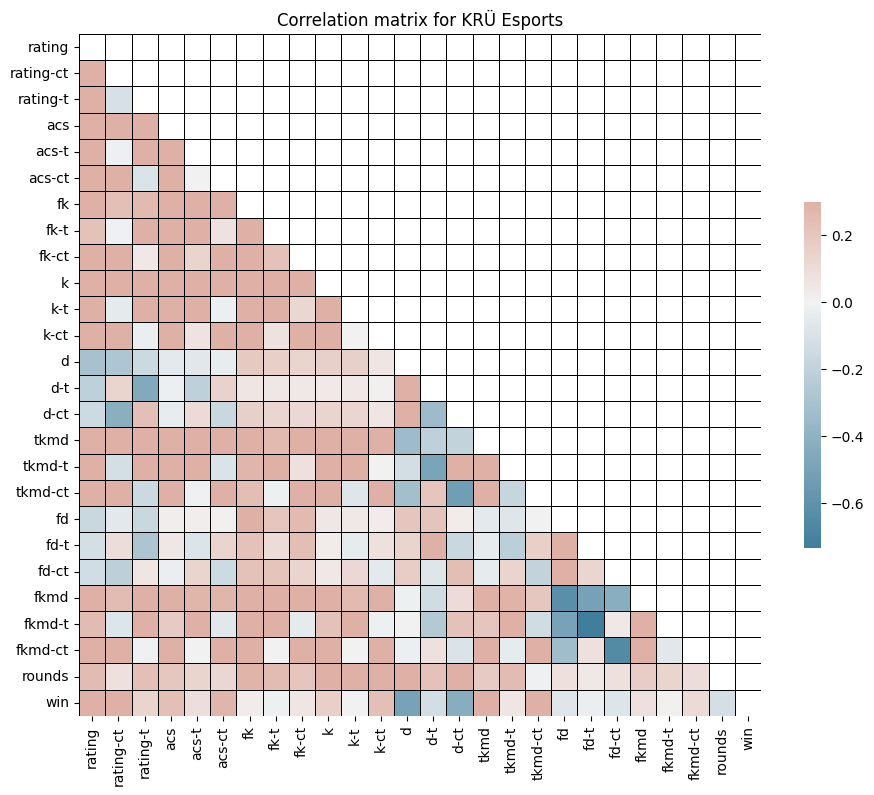

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


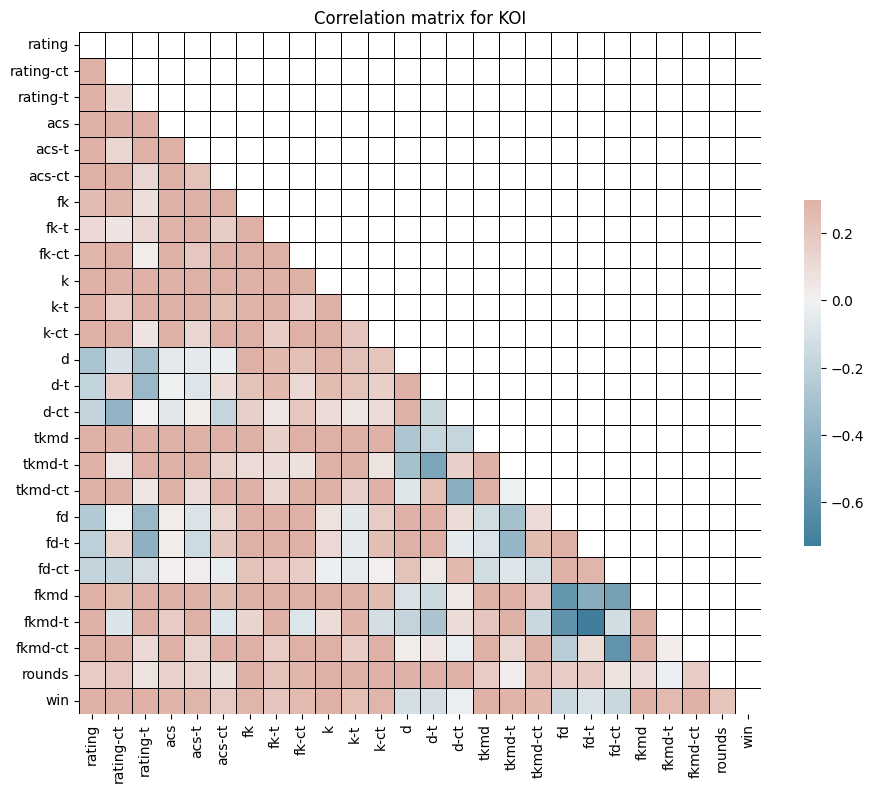

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


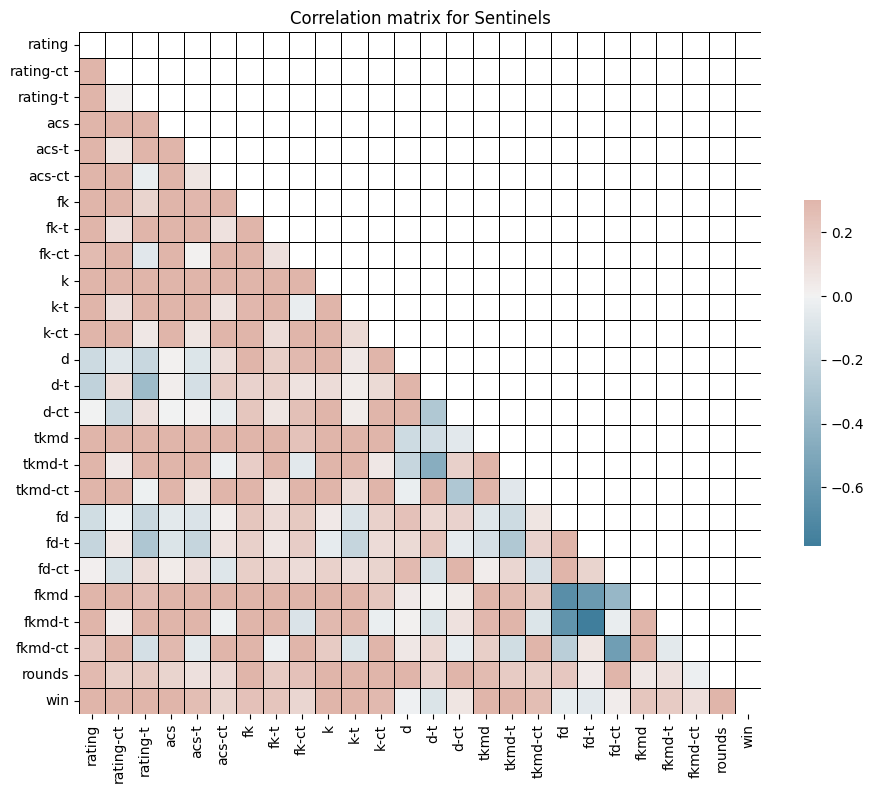

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


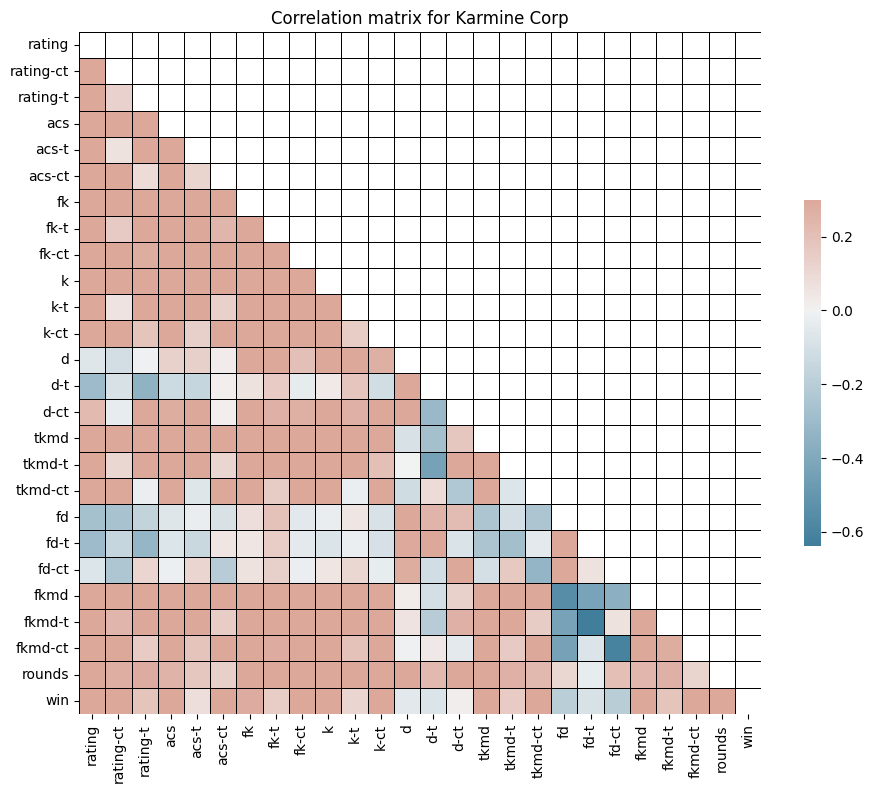

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


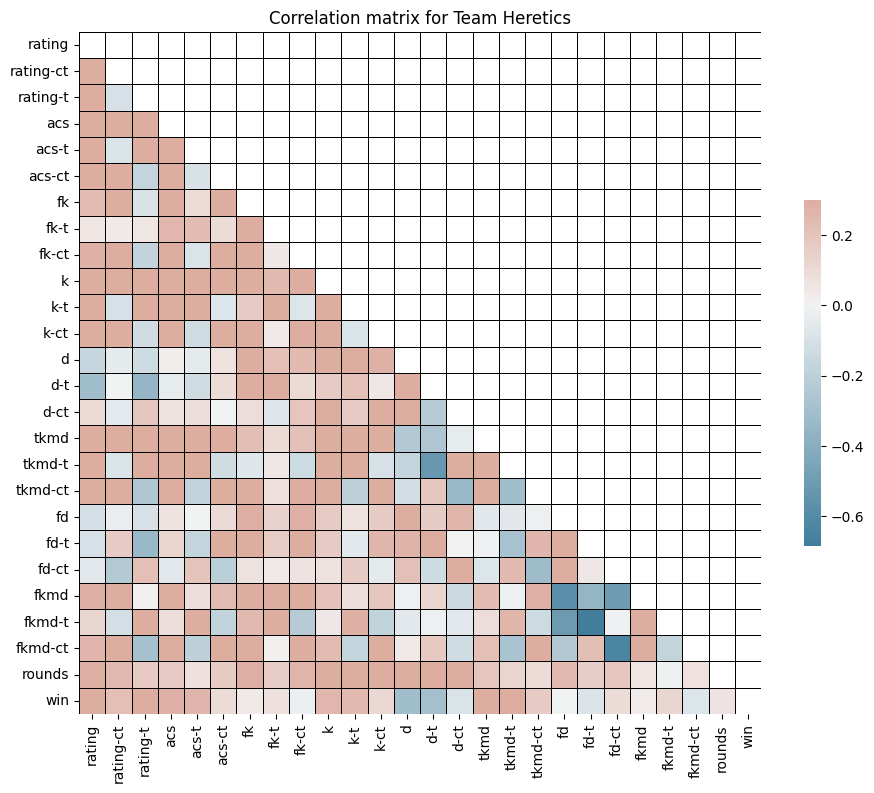

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


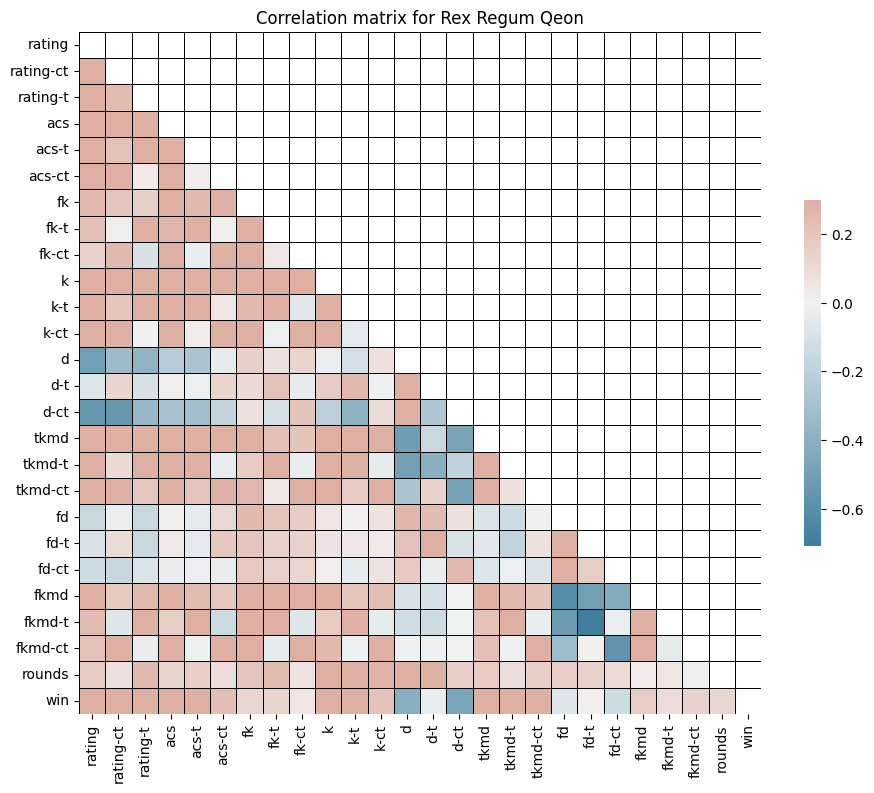

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


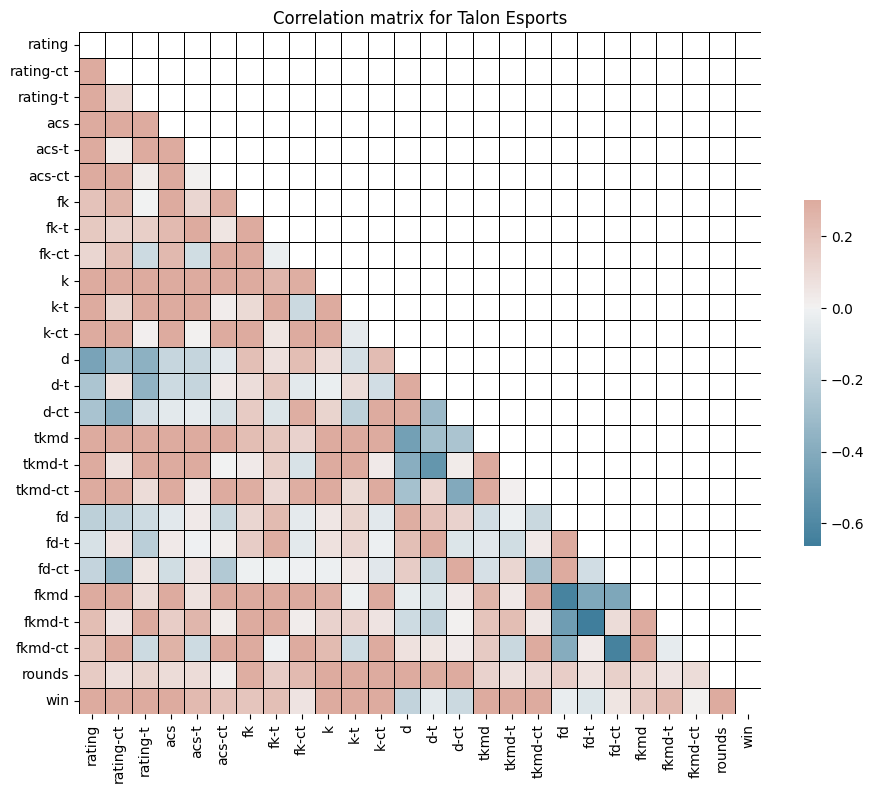

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


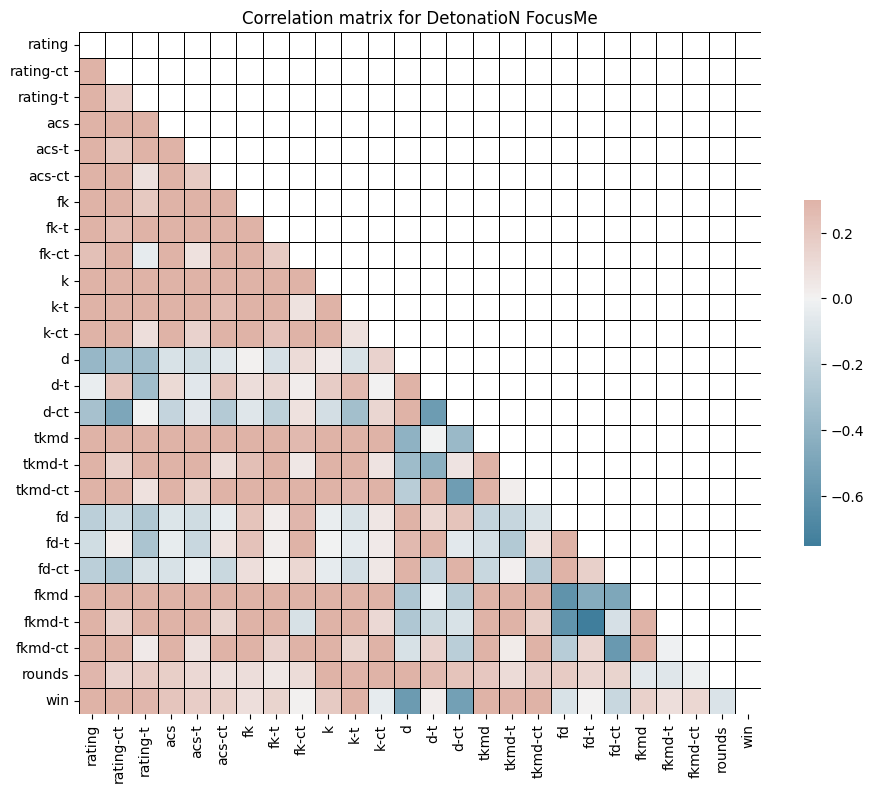

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


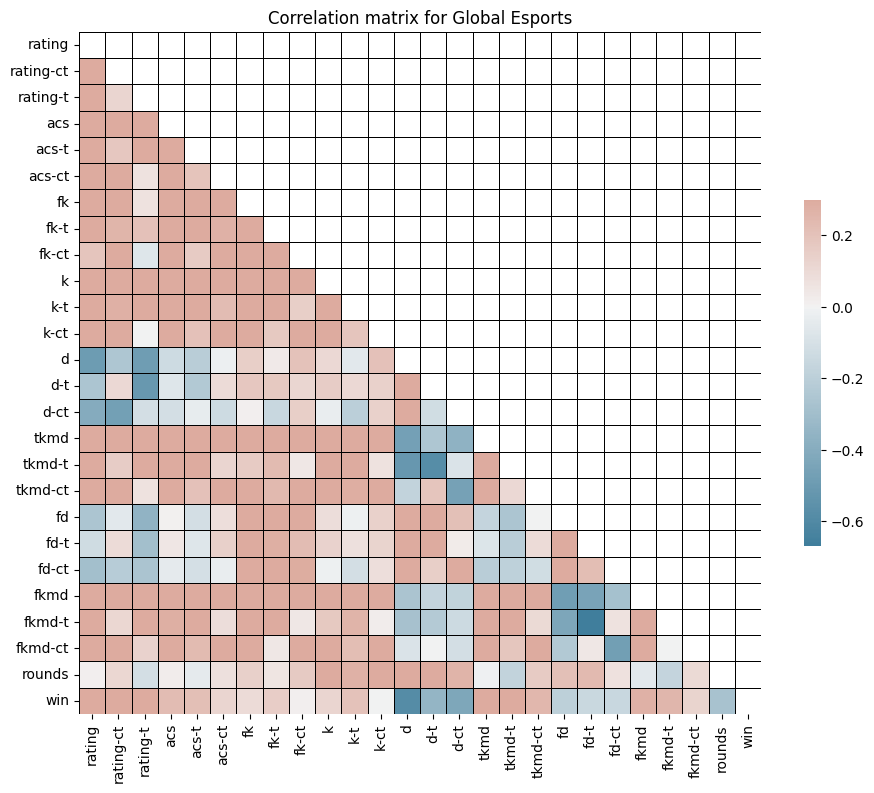

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


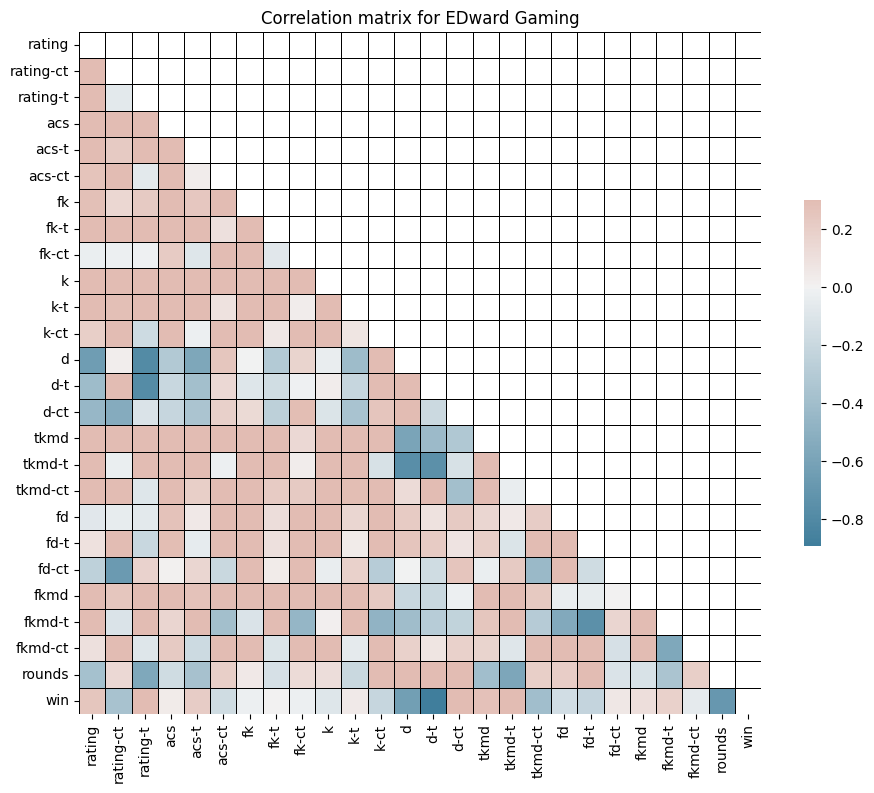

/var/folders/d8/qgb_8zcs7vl6pjzppspg_0sw0000gn/T/ipykernel_57287/2399507493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['win'] = team_df['winner_name'] == team


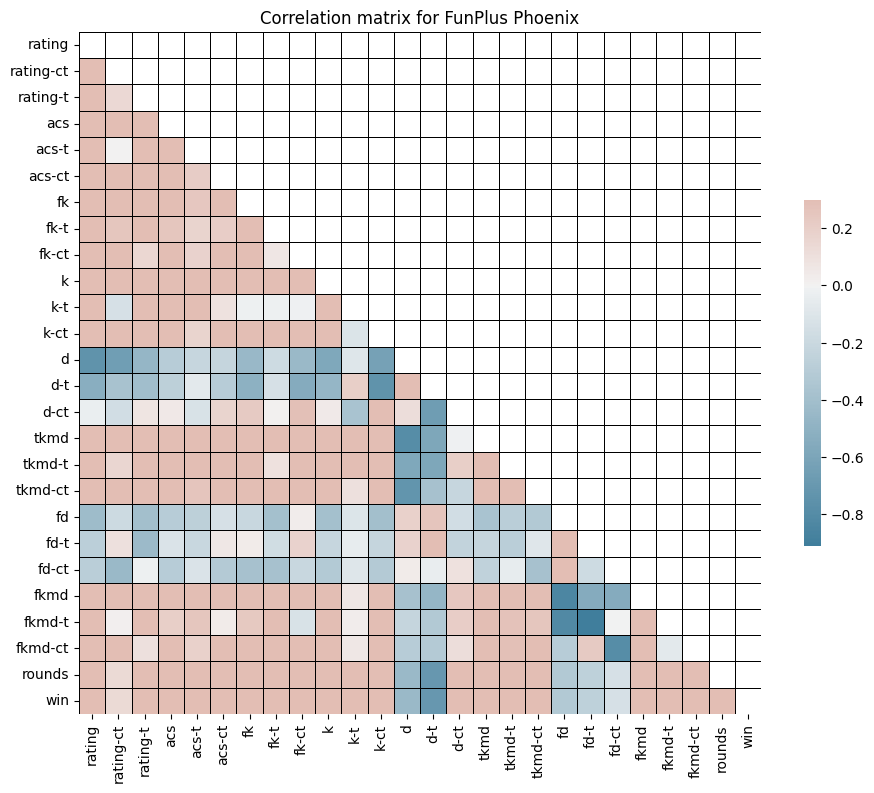

In [ ]:
for team, team_df in team_dfs.items():
    team_df['win'] = team_df['winner_name'] == team

    # Compute correlation matrix
    corr = team_df.corr(numeric_only=True)

    # Generate a mask for the upper triangle (optional)
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, linecolor='black')

    # Set the title
    plt.title(f"Correlation matrix for {team}")

    # Show the plot
    plt.show()


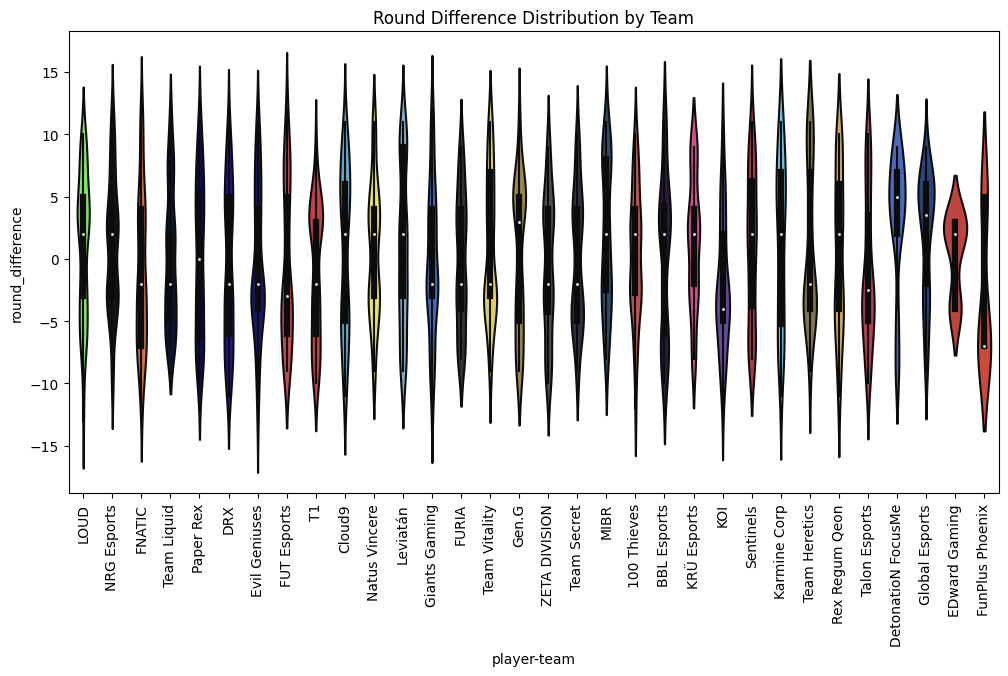

In [ ]:
team_info['round_difference'] = team_info['team1-score'] - team_info['team2-score']
plt.figure(figsize=(12, 6))
sns.violinplot(x='player-team', y='round_difference', data=team_info, palette=team_colors)
plt.title('Round Difference Distribution by Team')
plt.xticks(rotation=90)
plt.show()
